In [1]:

import matplotlib as mpl
mpl.use('Agg')
import os
import h5py
import json
import re
import sys
import datetime
import optparse
import pprint
import copy

import cPickle as pkl
import tifffile as tf
import pylab as pl
import numpy as np
from scipy import ndimage
import cv2
import glob
from scipy.optimize import curve_fit
import seaborn as sns
from pipeline.python.retinotopy import visualize_rois as vis
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy as sp
import pandas as pd


from pipeline.python.utils import natural_keys, label_figure, replace_root
from pipeline.python.retinotopy import visualize_rois as visroi
from pipeline.python.retinotopy import do_retinotopy_analysis as ra
from pipeline.python.retinotopy import target_visual_field as targ
from pipeline.python.retinotopy import utils as rutils

from matplotlib.patches import Ellipse, Rectangle

pp = pprint.PrettyPrinter(indent=4)
from scipy.signal import argrelextrema


In [2]:
%matplotlib notebook

In [3]:

# def extract_options(options):
    
#     parser = optparse.OptionParser()

#     parser.add_option('-D', '--root', action='store', dest='rootdir', default='/n/coxfs01/2p-data', help='data root dir (root project dir containing all animalids) [default: /nas/volume1/2photon/data, /n/coxfs01/2pdata if --slurm]')
#     parser.add_option('-i', '--animalid', action='store', dest='animalid', default='', help='Animal ID')

#     # Set specific session/run for current animal:
#     parser.add_option('-S', '--session', action='store', dest='session', default='', \
#                       help='session dir (format: YYYMMDD_ANIMALID')
#     parser.add_option('-A', '--acq', action='store', dest='acquisition', default='FOV1', \
#                       help="acquisition folder (ex: 'FOV1_zoom3x') [default: FOV1]")
#     parser.add_option('-R', '--run', action='store', dest='run', default='retino_run1', \
#                       help="name of run dir containing tiffs to be processed (ex: gratings_phasemod_run1)")
#     parser.add_option('-t', '--retinoid', action='store', dest='retinoid', default='analysis001', \
#                       help="name of retino ID (roi analysis) [default: analysis001]")
    
#     parser.add_option('--angular', action='store_false', dest='use_linear', default=True, \
#                       help="Plot az/el coordinates in angular spce [default: plots linear coords]")
# #     parser.add_option('-e', '--thr-el', action='store', dest='fit_thresh_el', default=0.2, \
# #                       help="fit threshold for elevation [default: 0.2]")
# #     parser.add_option('-a', '--thr-az', action='store', dest='fit_thresh_az', default=0.2, \
# #                       help="fit threshold for azimuth [default: 0.2]")
    
#     (options, args) = parser.parse_args(options)

#     return options

In [4]:
# def load_retino_analysis_info(animalid, session, fov, run, retinoid, use_pixels=False, rootdir='/n/coxfs01/2p-data'):
    
#     run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
#     fov = os.path.split(os.path.split(run_dir)[0])[-1]
#     print("FOV: %s, run: %s" % (fov, run))
#     retinoids_fpath = glob.glob(os.path.join(run_dir, 'retino_analysis', 'analysisids_*.json'))[0]
#     with open(retinoids_fpath, 'r') as f:
#         rids = json.load(f)
#     if use_pixels:
#         roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] == 'pixels']
#     else:
#         roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] != 'pixels']
#     if retinoid not in roi_analyses:
#         retinoid = sorted(roi_analyses, key=natural_keys)[-1] # use most recent roi analysis
#         print("Fixed retino id to most recent: %s" % retinoid)
        
#     return retinoid, rids[retinoid]


# def get_retino_stimulus_info(mwinfo, runinfo):
    
#     stiminfo = dict((cond, dict()) for cond in conditions)
#     for curr_cond in conditions:
#         # get some info from paradigm and run file
#         stimfreq = np.unique([v['stimuli']['scale'] for k,v in mwinfo.items() if v['stimuli']['stimulus']==curr_cond])[0]
#         stimperiod = 1./stimfreq # sec per cycle
        
#         n_frames = runinfo['nvolumes']
#         fr = runinfo['frame_rate']
        
#         n_cycles = int(round((n_frames/fr) / stimperiod))
#         #print n_cycles

#         n_frames_per_cycle = int(np.floor(stimperiod * fr))
#         cycle_starts = np.round(np.arange(0, n_frames_per_cycle * n_cycles, n_frames_per_cycle)).astype('int')

#         stiminfo[curr_cond] = {'stimfreq': stimfreq,
#                                'frame_rate': fr,
#                                'n_reps': len(trials_by_cond[curr_cond]),
#                                'nframes': n_frames,
#                                'n_cycles': n_cycles,
#                                'n_frames_per_cycle': n_frames_per_cycle,
#                                'cycle_start_ixs': cycle_starts
#                               }

#     return stiminfo



In [5]:
# # Interpolate bar position for found SI frame using upsampled MW tstamps and positions:
# def get_interp_positions(condname, mwinfo, stiminfo, trials_by_cond):
#     mw_fps = 1./np.diff(np.array(mwinfo[str(trials_by_cond[condname][0])]['stiminfo']['tstamps'])/1E6).mean()
#     si_fps = stiminfo[condname]['frame_rate']
#     print "[%s]: Downsampling MW positions (sampled at %.2fHz) to SI frame rate (%.2fHz)" % (condname, mw_fps, si_fps)

#     si_cyc_ixs = stiminfo[condname]['cycle_start_ixs']
#     assert len(np.unique(np.diff(si_cyc_ixs))) == 1, "Uneven cycle durs found!\n--> %s" % str(np.diff(si_cyc_ixs))
#     fr_per_cyc = int(np.unique(np.diff(si_cyc_ixs))[0])
    
#     si_tstamps = runinfo['frame_tstamps_sec']


#     #fig, axes = pl.subplots(1, len(trials_by_cond[condname]))

#     stim_pos_list = []
#     stim_tstamp_list = []

#     for ti, trial in enumerate(trials_by_cond[condname]):
#         #ax = axes[ti]

#         pos_list = []
#         tstamp_list = []
#         mw_cyc_ixs = mwinfo[str(trial)]['stiminfo']['start_indices']
#         for cix in np.arange(0, len(mw_cyc_ixs)):
#             if cix==len(mw_cyc_ixs)-1:
#                 mw_ts = [t/1E6 for t in mwinfo[str(trial)]['stiminfo']['tstamps'][mw_cyc_ixs[cix]:]]
#                 xs = mwinfo[str(trial)]['stiminfo']['values'][mw_cyc_ixs[cix]:]
#                 si_ts = si_tstamps[si_cyc_ixs[cix]:si_cyc_ixs[cix]+fr_per_cyc]
#             else:
#                 mw_ts = np.array([t/1E6 for t in mwinfo[str(trial)]['stiminfo']['tstamps'][mw_cyc_ixs[cix]:mw_cyc_ixs[cix+1]]])
#                 xs = np.array(mwinfo[str(trial)]['stiminfo']['values'][mw_cyc_ixs[cix]:mw_cyc_ixs[cix+1]])
#                 si_ts = si_tstamps[si_cyc_ixs[cix]:si_cyc_ixs[cix+1]]

#             recentered_mw_ts = [t-mw_ts[0] for t in mw_ts]
#             recentered_si_ts = [t-si_ts[0] for t in si_ts]

#             # Since MW tstamps are linear, SI tstamps linear, interpolate position values down to SI's lower framerate:
#             interpos = sp.interpolate.interp1d(recentered_mw_ts, xs, fill_value='extrapolate')
#             resampled_xs = interpos(recentered_si_ts)

#             pos_list.append(pd.Series(resampled_xs, name=trial))
#             tstamp_list.append(pd.Series(recentered_si_ts, name=trial))

#             #ax.plot(recentered_mw_ts, xs, 'ro', alpha=0.5, markersize=2)
#             #ax.plot(recentered_si_ts, resampled_xs, 'bx', alpha=0.5, markersize=2)

#         pos_vals = pd.concat(pos_list, axis=0).reset_index(drop=True) 
#         tstamp_vals = pd.concat(tstamp_list, axis=0).reset_index(drop=True)

#         stim_pos_list.append(pos_vals)
#         stim_tstamp_list.append(tstamp_vals)

#     stim_positions = pd.concat(stim_pos_list, axis=1)
#     stim_tstamps = pd.concat(stim_tstamp_list, axis=1)


#     return stim_positions, stim_tstamps


In [6]:
def get_parsed_cycles(rid, roi_traces, stiminfo, chunksize=1):

    
    parsed_traces = dict()
    parsed_cycle_ixs = dict()
    for curr_cond, trial_nums in stiminfo['trials_by_cond'].items():
        ncycles = stiminfo[curr_cond]['n_cycles']
        resampled = ncycles/chunksize
        
        fr_per_cycle = stiminfo[curr_cond]['n_frames_per_cycle'] * chunksize
        cycle_starts = stiminfo[curr_cond]['cycle_start_ixs'][0::chunksize]
        #print len(cycle_starts)
        ntrials = len(trials_by_cond[curr_cond])

        roi_cycles = []; cycle_indices = [];
        curr_roi_tracearray = roi_traces[curr_cond]
        for tix in np.arange(0, curr_roi_tracearray.shape[0]):

            roi_trace = curr_roi_tracearray[tix, :] #extr_traces['File%03d' % trial]['processed'][rid, :]

            nparsed_cycles = len(cycle_starts) # ncycles/resampled #chunksize
            ptraces_currtrial = np.zeros((nparsed_cycles, fr_per_cycle))
            cindices_currtrial = np.zeros((nparsed_cycles, chunksize))
            cyc_counter = 0
            for cycle in np.arange(0, nparsed_cycles):
                ixs_to_fill = cycle_starts[cycle] + fr_per_cycle
                if ixs_to_fill > len(roi_trace):
                    roi_trace = np.pad(roi_trace, ((0, ixs_to_fill - len(roi_trace))),\
                                       mode='constant', constant_values=0)
                ptraces_currtrial[cycle, :] = roi_trace[cycle_starts[cycle]:(cycle_starts[cycle]+fr_per_cycle)]
                cindices_currtrial[cycle, :] = stiminfo[curr_cond]['cycle_start_ixs'][cyc_counter:cyc_counter+chunksize]
                cyc_counter += chunksize
                
            roi_cycles.append(ptraces_currtrial)
            cycle_indices.append(cindices_currtrial)
        
        parsed_traces[curr_cond] = np.array(roi_cycles)
        parsed_cycle_ixs[curr_cond] = np.array(cycle_indices) #[s for s in cycle_starts] #[s/chunksize for s in cycle_starts]
        
    return parsed_traces, parsed_cycle_ixs

In [7]:
def plot_parsed_cycles_by_roi(parsed_traces, parsed_cycle_ixs):

    c1_color = 'b'
    c2_color = 'orange'
    
    fig, axes = pl.subplots(2,1)

    for axi, (c1, c2) in enumerate([('left', 'right'), ('bottom', 'top')]):
        ax = axes[axi]

        # Plot FW direction of azimuth/elev
        nreps, ncycles_orig, nframes_orig = parsed_traces[c1].shape
        for rep in np.arange(0, nreps):
            ax.plot(parsed_traces[c1][rep,:,:].mean(axis=0), c1_color, lw=0.5)   # Plot each "rep" of chunked cycle
        ax.plot(parsed_traces[c1].mean(axis=1).mean(axis=0), c1_color, label=c1) # Plot average chunked cycle
        ax.legend()
        subcycle_ixs = parsed_cycle_ixs[c1].mean(axis=0)[0,: ]
        for cyc in subcycle_ixs:
            ax.axvline(x=cyc, color='k', lw=0.5)       # Plot cycle start lines

        # Plot BW direction of azimuth/elev
        nreps, ncycles_orig, nframes_orig = parsed_traces[c2].shape
        for rep in np.arange(0, nreps):
            ax.plot(parsed_traces[c2][rep,:,:].mean(axis=0), c2_color, lw=0.5)
        ax.plot(parsed_traces[c2].mean(axis=1).mean(axis=0), c2_color, label=c2)
        ax.legend(loc='upper left')
        subcycle_ixs = parsed_cycle_ixs[c2].mean(axis=0)[0,: ]
        for cyc in subcycle_ixs: #parsed_cycle_ixs[c2][0:chunksize]:
            ax.axvline(x=cyc, color='k', lw=0.5)
            
    return fig


In [8]:
def get_cycle_onsets(avg_cycle_c1, cycle_starts, fr_per_cyc, baseline_window_size=10., nstds_above_baseline=1.5):

    # Find peaks for each cycle:
    cmaxima = []
    cminima = []
    onsets = []
    baseline_values= []
    baseline_indices = []
    
    # Get max, min, and "onset" for each cycle in "mini" roi-trace:
    try:
        for cyc_ix, cyc_start in enumerate(cycle_starts):

            curr_frames = np.arange(cyc_start, cyc_start+fr_per_cyc)
            curr_values = avg_cycle_c1[curr_frames]
            cmax = int(np.where(curr_values==curr_values.max())[0][0])
            startix = 0
            if cmax == 0:
                while cmax < (fr_per_cyc / len(cycle_starts)): #4:
                    print "Getting new cmax..."
                    cmax = int(np.where(curr_values[startix:]==curr_values[startix:].max())[0][0])
                    startix += 1
                cmax = cmax + startix
            #elif (cmax - cmaxima[-1]) < (fr_per_cyc/2):
                
            cmaxima.append((curr_frames[cmax], curr_values.max()))

            minval = curr_values[startix:cmax].min()
            cmin = int(np.where(curr_values[startix:cmax]==minval)[0][0]) + startix
            cminima.append((curr_frames[cmin], minval))

            baseline = curr_values[cmin-baseline_window_size:cmin] #+baseline_window_size]
            bindices = curr_frames[cmin-baseline_window_size:cmin] #+baseline_window_size]
            if cmin-baseline_window_size < 0: # include frames from previous "cycle" since likely at very edge
                if cyc_ix == 0:
                    # No previous cycle to borrow frames from
                    bindices = curr_frames[0:cmin+baseline_window_size]
                    baseline = curr_values[0:cmin+baseline_window_size]
                else:
                    prev_frames = np.arange(cycle_starts[cyc_ix-1], cycle_starts[cyc_ix-1]+fr_per_cyc)
                    prev_values = avg_cycle_c1[prev_frames]
                    nprev = baseline_window_size-cmin
                    bindices = curr_frames[0:cmin] #+baseline_window_size]
                    bindices = sorted(np.append(bindices, prev_frames[-nprev:]))

                    baseline = prev_values[-nprev:]
                    baseline = np.append(baseline, curr_values[0:cmin]) #+baseline_window_size])

            thr_value = baseline.mean() + (baseline.std() * nstds_above_baseline) #curr_values.max()*0.1
            onset = np.where(np.abs(curr_values[cmin:cmax]-thr_value)\
                             ==np.min(np.abs(curr_values[cmin:cmax]-thr_value)))[0] + cmin # Only look b/w max/min 

            onsets.append((curr_frames[onset], curr_values[onset]))
            baseline_values.append(baseline)
            baseline_indices.append(bindices)
    except Exception as e:
        return None
        
    loci = {'maxima': cmaxima,
           'minima': cminima,
           'onsets': onsets,
           'baseline_indices': baseline_indices,
           'baseline_values': baseline_values,
           'nstds_above_baseline': nstds_above_baseline}
        
    return loci #cmaxima, cminima, onsets, (baseline_indices, baseline_values)

        
        

In [9]:


def plot_cycle_loci(avg_cycle_c1, cycle_starts, loci, avg_pos_c1=None, label='cond', ax=None, color='k'):

    if ax is None:
        fig, ax = pl.subplots(figsize=(6,3))

    # Can either plot by frames, or by corresponding bar position:
    if avg_pos_c1 is None:
        avg_pos_c1 = np.arange(0, len(avg_cycle_c1))
    
    # Plot average "chunked-cycle" and each repetition of the full cycle
    ax.plot(avg_pos_c1, avg_cycle_c1, color=color, lw=0.5, label=label)
    for cyc in cycle_starts:
        cycle_ix = avg_pos_c1[cyc]
        ax.axvline(x=cycle_ix, color=color, linestyle='--', lw=0.5)

    # Plot maxima:
    for c in loci['maxima']:
        c_ix = avg_pos_c1[c[0]] 
        c_val = c[1]
        ax.plot(c_ix, c_val, 'k+', markersize=10)

    # Plot minima:
    for c in loci['minima']: #cmin:
        c_ix = avg_pos_c1[c[0]]
        c_val = c[1]
        if color != 'k':
            ax.plot(c_ix, c_val, 'k.', markersize=10)
        else:
            ax.plot(c_ix, c_val, 'y.', markersize=10)

    # Plot "onset" defined by threshold:
    for ons in loci['onsets']:
        if not ons[0].size:
            continue
        on_ix = avg_pos_c1[ons[0]]
        on_val = ons[1]
        
        if color != 'k':
            ax.plot(on_ix, on_val, 'k*', markersize=10)
        else:
            ax.plot(on_ix, on_val, 'g*',  markersize=10)

    # Plot baseline values used to calculate onset reference:
    for bi, bv in zip(loci['baseline_indices'], loci['baseline_values']): #bas_ixs, bas_vals):
        bi_ixs = [avg_pos_c1[b] for b in bi]
        ax.plot(bi_ixs, bv, 'gray')
        
    return ax

In [10]:

def plot_cycle_onsets(avg_cycle_c1, cycle_starts, loci, avg_pos_c1=None, label='cond', ax=None, color='k'): 

    if ax is None:
        fig, ax = pl.subplots(figsize=(6,3))

    # Can either plot by frames, or by corresponding bar position:
    if avg_pos_c1 is None:
        avg_pos_c1 = np.arange(0, len(avg_cycle_c1))

    if len(cycle_starts) > 1:
        assert len(np.unique(np.diff(cycle_starts))) == 1, "Uneven cycle durs found!\n--> %s" % str(np.diff(cycle_starts))
        fr_per_cyc = int(np.unique(np.diff(cycle_starts))[0])
    else:
        fr_per_cyc = len(avg_cycle_c1)
        
    # Plot average "chunked-cycle" and each repetition of the full cycle
    #ax.plot(avg_pos_c1, avg_cycle_c1, color='k', lw=0.5)
    for cix, cyc in enumerate(cycle_starts):
        if cix == len(cycle_starts)-1:
            ax.plot(avg_pos_c1[cyc:], avg_cycle_c1[cyc:cyc+fr_per_cyc], color='k', lw=0.5)
        else:
            ax.plot(avg_pos_c1[cyc:cycle_starts[cix+1]], avg_cycle_c1[cyc:cycle_starts[cix+1]], color='k', lw=0.5)

        cycle_ix = avg_pos_c1[cyc]
        ax.axvline(x=cycle_ix, color='k', linestyle='--', lw=0.2)

    # Plot "onset" defined by threshold:
    for ix, (mxs, ons) in enumerate(zip(loci['maxima'], loci['onsets'])):
        if not ons[0].size:
            continue
        if ix == 0: #len(loci['maxima'])-1:
            label = label
        else:
            label = None
        ax.plot(avg_pos_c1[int(ons[0]):int(mxs[0])], avg_cycle_c1[int(ons[0]):int(mxs[0])], \
                color=color, label=label, alpha=0.7, lw=1.0)
    return ax                

In [11]:
def get_loci_from_averaged_cycle(parsed_traces, parsed_cycle_ixs, stiminfo, \
                                 nstds_above_baseline=2., window_nsecs=1.):

    loci = dict()
    for aix, (c1, c2) in enumerate([('left', 'right'), ('bottom', 'top')]):

        # Plot direction 1
        avg_cycle_c1 = parsed_traces[c1].mean(axis=1).mean(axis=0)
        cycle_starts = [int(c) for c in parsed_cycle_ixs[c1].mean(axis=0)[0,:]] # only need first chunk
        fr_per_cyc = stiminfo[c1]['n_frames_per_cycle'] 
        baseline_window_size = int(round(stiminfo[c1]['frame_rate']*window_nsecs))
        loci[c1] = get_cycle_onsets(avg_cycle_c1, cycle_starts, fr_per_cyc,
                                                                     baseline_window_size=baseline_window_size, 
                                                                     nstds_above_baseline=nstds_above_baseline)

        # Plot direction 2
        avg_cycle_c2 = parsed_traces[c2].mean(axis=1).mean(axis=0)
        cycle_starts = [int(c) for c in parsed_cycle_ixs[c2].mean(axis=0)[0,:]] # only need first chunk
        fr_per_cyc = stiminfo[c2]['n_frames_per_cycle'] 
        baseline_window_size = int(round(stiminfo[c2]['frame_rate']*window_nsecs))
        loci[c2] = get_cycle_onsets(avg_cycle_c2, cycle_starts, fr_per_cyc,
                                                                     baseline_window_size=baseline_window_size, 
                                                                     nstds_above_baseline=nstds_above_baseline)

    return loci 

In [12]:
def plot_loci_from_averaged_cycle(parsed_traces, parsed_cycle_ixs, loci, plot_loci=False, average_positions=None):
    fig, axes = pl.subplots(1, 2, figsize=(12,4))

    for aix, (c1, c2) in enumerate([('left', 'right'), ('bottom', 'top')]):
        ax = axes[aix]
        

        # Plot forward direction
        if average_positions is None:
            xlabel = 'time (frames)'
            avg_pos_c1 = None
        else:
            xlabel = 'position (deg)'
            avg_pos_c1 = average_positions[c1]
        avg_cycle_c1 = parsed_traces[c1].mean(axis=1).mean(axis=0)
        cycle_starts = [int(c) for c in parsed_cycle_ixs[c1].mean(axis=0)[0,:]] # only need first chunk
        if plot_loci:
            ax = plot_cycle_loci(avg_cycle_c1, cycle_starts, loci[c1], avg_pos_c1=avg_pos_c1, \
                                 label=c1, ax=ax, color=c1_color)
        else:
            ax = plot_cycle_onsets(avg_cycle_c1, cycle_starts, loci[c1], ax=ax, avg_pos_c1=avg_pos_c1,
                               label=c1, color=c1_color)
        
        # Plot reverse direction
        if average_positions is None:
            xlabel = 'time (frames)'
            avg_pos_c2 = None
        else:
            xlabel = 'position (deg)'
            avg_pos_c2 = average_positions[c2]
        avg_cycle_c2 = parsed_traces[c2].mean(axis=1).mean(axis=0)
        cycle_starts = [int(c) for c in parsed_cycle_ixs[c2].mean(axis=0)[0,:]] # only need first chunk
        if plot_loci:
            ax = plot_cycle_loci(avg_cycle_c2, cycle_starts, loci[c2], avg_pos_c1=avg_pos_c2, \
                     label=c2, ax=ax, color=c2_color)
        else:
            ax = plot_cycle_onsets(avg_cycle_c2, cycle_starts, loci[c2], ax=ax, avg_pos_c1=avg_pos_c2,
                               label=c2, color=c2_color)
        
        ax.set_xlabel(xlabel)
        ax.legend(loc='upper right')

        ax.set_title('%s, %s' % (c1, c2)) #cond)
        sns.despine(trim=True, offset=4, ax=ax)
        
    return fig

In [13]:
def get_positions_per_cycle(stim_positions, parsed_cycle_ixs):
    positions_by_cycle = {}
    
    for c1 in stim_positions.keys():
        
        # Use indices of parsed "cycle chunk" (should be nchunks=ncycles/chunksize 'traces' to match position to)
        # ----------------------------------------------------------------------------
        # C1: Average position values to match chunked traces:
        mean_pos_vals1 = stim_positions[c1].mean(axis=1)
        avg_pos_list1 = []
        cycle_starts = [int(c) for c in parsed_cycle_ixs[c1].mean(axis=0)[:, 0]] #[0:chunksize]

        assert len(np.unique(np.diff(cycle_starts))) == 1, "Uneven cycle durs found!\n--> %s" % str(np.diff(cycle_starts))
        fr_per_cyc = int(np.unique(np.diff(cycle_starts))[0])


        for cix, cyc in enumerate(cycle_starts):
            #print cix, cyc
            if cix == len(cycle_starts)-1:
                avg_pos_list1.append(mean_pos_vals1[cyc:cyc+fr_per_cyc])
            else:
                avg_pos_list1.append(mean_pos_vals1[cyc:cycle_starts[cix+1]])
        for ai, a in enumerate(avg_pos_list1):
            avg_pos_list1[ai] = a[0:stiminfo[c1]['n_frames_per_cycle']*chunksize]

        positions_by_cycle[c1] = avg_pos_list1
    
    return positions_by_cycle

        

def loci_to_rf_parameters(loci, positions_by_cycle):
    rf_edges = {}
    for c1 in loci.keys():
        avg_pos_list = positions_by_cycle[c1]

        # For each reptition of the "chunked cycle" find corresponding onset position:
        # ----------------------------------------------------------------------------
        onsets = loci[c1]['onsets']

        onset_positions = []; peak_positions = [];
        nchunks = len(avg_pos_list)
        for peak, onset, cyc, bar_pos in zip(loci[c1]['maxima'], onsets, np.arange(0, nchunks), avg_pos_list):
            onset_positions.append(float(bar_pos.iloc[onset[0]]))
            peak_positions.append(float(bar_pos.iloc[peak[0]]))

        mean_onset_pos = np.mean(onset_positions)
        std_onset_pos = np.std(onset_positions)
        mean_peak_pos = np.mean(peak_positions)
        
        print "[%s] Onset %.2f deg (std %.2f). Peak @ %.2f deg." % (c1, mean_onset_pos, std_onset_pos, mean_peak_pos)

        rf_edges[c1] = {'onset_positions': np.array(onset_positions),
                        'peak_positions': np.array(peak_positions),
                        'loci': loci[c1],
                        'nchunks': nchunks,
                        'bar_positions': avg_pos_list}
    
    
    return rf_edges

def get_rf_estimate_params(rid, absolute_coords, rf_edges, verbose=False):
    rfparams = {}
    
    xpos_phase = absolute_coords['linX'][rid]
    ypos_phase = absolute_coords['linY'][rid]

    right_edge = rf_edges['right']['onset_positions'].mean()
    left_edge = rf_edges['left']['onset_positions'].mean()
    top_edge = rf_edges['top']['onset_positions'].mean()
    bottom_edge = rf_edges['bottom']['onset_positions'].mean()

    if verbose:
        print "ROI %i - summary - " % int(rid+1)
        print "Phase coords (x, y): (%.2f, %.2f)" % (xpos_phase, ypos_phase)
        print "Left/Right edges: [%.2f, %.2f]" % (left_edge, right_edge)
        print "--> left onsets:", rf_edges['left']['onset_positions']
        print "--> right onsets:", rf_edges['right']['onset_positions']

        print "Bottom/Top edges: [%.2f, %.2f]" % (bottom_edge, top_edge)
        print "--> top onsets:", rf_edges['top']['onset_positions']
        print "--> bottom onsets:", rf_edges['bottom']['onset_positions']

    rfparams = {'phase_coords': (xpos_phase, ypos_phase),
                'azimuth_bounds': (left_edge, right_edge),
                'elevation_bounds': (bottom_edge, top_edge)}

    return rfparams


In [14]:
def plot_roi_RF(rfparams, screen_info, left_edge=0, right_edge=0, top_edge=0, bottom_edge=0):
    
# ells = [Ellipse(xy=[linX[ri], linY[ri]], width=az_rfs[ri], height=el_rfs[ri]) for ri in range(nrois)
#                 if az_rfs[ri] > 0 and el_rfs[ri] > 0]

    travel_width = right_edge - left_edge
    travel_height = top_edge - bottom_edge

    fig, ax = pl.subplots(1, figsize=(6, 6))
    ax.clear()

    # Plot travel bounds of bar:
    ax.add_patch(Rectangle((left_edge, bottom_edge), travel_width, travel_height, 
                           alpha=1, facecolor='none', edgecolor='k', linestyle=':'))

    # Plot physical screen limits
    screen_width = screen_info['azimuth']
    screen_height = screen_info['elevation']
    screen_aspect = screen_width/screen_height
    ax.add_patch(Rectangle((-screen_width/2, -screen_height/2), screen_width, screen_height, 
                           alpha=.2, facecolor='gray', edgecolor='k', linestyle='-'))


    # Get RF bounds:
    left, right = rfparams['azimuth_bounds']
    top, bottom = rfparams['elevation_bounds']

    xpos_phase, ypos_phase = rfparams['phase_coords']
    x_center = left + (right - left)/2 #absolute_coords['linX'][rid]
    y_center = bottom + (top - bottom)/2
    ells = [Ellipse(xy=[x_center, y_center], \
                    width=right-left,\
                    height=top-bottom)]

    # Plot ellipse vs. measured RF centers:
    ax.plot(xpos_phase, ypos_phase, 'r*', label='phase')
    ax.plot(x_center, y_center, 'b*', label='midpoint')
    
    # Plot ellipse:
    for ei,e in enumerate(ells): #[0:20]):
        ax.add_artist(e)
        e.set_alpha(1)
        e.set_facecolor('none')
        e.set_linestyle('-')
        e.set_edgecolor('k')
    
    #ax.set_xlim([-screen_info['azimuth']/2, screen_info['azimuth']/2])
    #ax.set_ylim([-screen_info['elevation']/2, screen_info['elevation']/2])
    ax.set_xlim([left_edge-10, right_edge+10])
    ax.set_ylim([bottom_edge-10, top_edge+10])

    ax.legend()

    return fig


# Select data set

In [15]:
options = ['-i', 'JC047', '-S', '20190215', '-A', 'FOV1']
#options = ['-i', 'JC073', '-S', '20190322', '-R', 'retino_run1', '-A', 'FOV1']
#options = ['-i', 'JC073', '-S', '20190327', '-R', 'retino_run2', '-A', 'FOV1']

In [16]:
opts = extract_options(options)

rootdir = opts.rootdir
animalid = opts.animalid
session = opts.session
fov = opts.acquisition
run = opts.run
retinoid = opts.retinoid
use_linear = opts.use_linear
#fit_thresh_az = float(opts.fit_thresh_az)
#fit_thresh_el = float(opts.fit_thresh_el) #0.2


# Load data

In [17]:
# Select which retino analysis to use:
use_pixels = False
retinoid, rinfo = rutils.load_retino_analysis_info(animalid, session, fov, run, retinoid, 
                                            use_pixels=use_pixels, rootdir=rootdir)

# Create data identifier for figures:
data_identifier = '|'.join([animalid, session, fov, run, retinoid])
print("*** Dataset: %s ***" % data_identifier)

# Get processed retino data:
run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
processed_dir = glob.glob(os.path.join(run_dir, 'retino_analysis', '%s*' % retinoid))[0]
processed_fpaths = glob.glob(os.path.join(processed_dir, 'files', '*.h5'))
print("Found %i processed retino runs." % len(processed_fpaths))

# Get condition info for trials:
conditions_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', '*.json'))[0]
with open(conditions_fpath, 'r') as f:
    mwinfo = json.load(f)
conditions = list(set([cdict['stimuli']['stimulus'] for trial_num, cdict in mwinfo.items()]))
trials_by_cond = dict((cond, [int(k) for k, v in mwinfo.items() if v['stimuli']['stimulus']==cond]) \
                      for cond in conditions)

# Get run info:
runinfo_fpath = glob.glob(os.path.join(run_dir, '*.json'))[0]
with open(runinfo_fpath, 'r') as f:
    runinfo = json.load(f)
print "---------------------------------"
print "Trials by condN:", trials_by_cond

# Get stimulus info:
stiminfo = rutils.get_retino_stimulus_info(mwinfo, runinfo)
stiminfo['trials_by_cond'] = trials_by_cond

# Load raw traces -- Use 'processed' (np-corrected + preprocessing)
extracted_traces_fpath = glob.glob(os.path.join(processed_dir, 'traces', '*.h5'))[0]
extr_traces = h5py.File(extracted_traces_fpath)
print 'Extracted retino traces contains:' 
print '---', extr_traces.keys()
print 'Each parsed file contains:'
print "--- ---", extr_traces[extr_traces.keys()[0]].keys()

print "---------------------------------"
print "Current retino run: %s" % run
print "---------------------------------"
for param in stiminfo['right'].keys():
    if param == 'cycle_start_ixs': continue
    print param, ':', stiminfo['right'][param]

FOV: FOV1_zoom4p0x, run: retino_run1
Fixed retino id to most recent: analysis002
*** Dataset: JC047|20190215|FOV1|retino_run1|analysis002 ***
Found 12 processed retino runs.
---------------------------------
Trials by condN: {u'top': [11, 5, 6], u'right': [1, 4, 8], u'left': [10, 2, 7], u'bottom': [12, 3, 9]}
Extracted retino traces contains:
--- [u'File001', u'File002', u'File003', u'File004', u'File005', u'File006', u'File007', u'File008', u'File009', u'File010', u'File011', u'File012']
Each parsed file contains:
--- --- [u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']
---------------------------------
Current retino run: retino_run1
---------------------------------
nframes : 4125
n_cycles : 12
stimfreq : 0.13
frame_rate : 44.6329
n_reps : 3
n_frames_per_cycle : 343


# Get bar positions (MW) and corresponding phase data (SI):

In [18]:
print "-----------------------------------"
print "Getting MW info (stimulus positions)"
stim_positions = dict()
stim_tstamps = dict()
for cond in trials_by_cond.keys():
    stim_positions[cond], stim_tstamps[cond] = rutils.get_interp_positions(cond, mwinfo, stiminfo, trials_by_cond)

print "Stimulus conditions (bar start/end):"
for cond in stim_positions.keys():
    print '--- %s: [%.2f, %.2f]' %(cond, stim_positions[cond].iloc[0,:].mean(), stim_positions[cond].iloc[-1,:].mean())


# Get FFT results and format
print "-----------------------------------"
print "Getting formatted FFT analysis"
fit, magratio, phase, trials_by_cond = targ.trials_to_dataframes(processed_fpaths, conditions_fpath)

print "-----------------------------------"
print "Getting screen info"
screen_info = visroi.get_screen_info(animalid, session, fov=fov.split('_')[0], interactive=True, rootdir=rootdir)

left_edge = stim_positions['left'].mean(axis=1).iloc[0]
right_edge = stim_positions['right'].mean(axis=1).iloc[0]
top_edge = stim_positions['top'].mean(axis=1).iloc[0]
bottom_edge = stim_positions['bottom'].mean(axis=1).iloc[0]
print "L/R edges:", left_edge, right_edge
print "B/T edges:", bottom_edge, top_edge


-----------------------------------
Getting MW info (stimulus positions)
[top]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[right]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[left]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[bottom]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
Stimulus conditions (bar start/end):
--- top: [43.72, -47.60]
--- right: [43.72, -47.52]
--- bottom: [-43.72, 47.56]
--- left: [-43.72, 47.53]
-----------------------------------
Getting formatted FFT analysis
TRIALS BY COND:
{u'top': [11, 5, 6], u'right': [1, 4, 8], u'left': [10, 2, 7], u'bottom': [12, 3, 9]}
Trials: [11, 10, 12, 1, 3, 2, 5, 4, 7, 6, 9, 8]
1: retino_data_FOV1_retino_Slice01_Channel01_File001.h5
2: retino_data_FOV1_retino_Slice01_Channel01_File002.h5
3: retino_data_FOV1_retino_Slice01_Channel01_File003.h5
4: retino_data_FOV1_retino_Slice01_Channel01_File004.h5
5: retino_dat

In [19]:
print stim_positions['left'].head()
print stim_positions['left'].tail()

          10         2          7 
0 -43.715256 -43.715256 -43.715256
1 -43.526281 -43.462792 -43.564004
2 -43.267698 -43.196865 -43.293076
3 -43.002577 -42.929420 -43.027523
4 -42.733597 -42.658419 -42.754942
             10         2          7 
4111  46.479228  46.491739  46.512408
4112  46.750320  46.756888  46.770097
4113  47.007771  47.014130  47.024682
4114  47.265222  47.271371  47.284863
4115  47.522673  47.528612  47.545044


In [26]:
# Convert phase info to absolute coords
mag_thr = magratio.mean(axis=1).max() * 0.5 #0.02
delay_thr = np.pi #/ 2.
absolute_coords = targ.get_absolute_centers(phase, magratio, trials_by_cond, stim_positions, \
                                            equal_travel_lengths=True, absolute=True,
                                            mag_thr=mag_thr, delay_thr=delay_thr)
# Also get mean magratios:
mean_magratios = pd.concat([pd.Series(magratio[trialnums].mean(axis=1), name=cond) \
                            for cond, trialnums in trials_by_cond.items()], axis=1)
print mean_magratios.shape
mean_magratios.head()

('ROIs with best mag-ratio (n=16, thr=0.04):', [3, 13, 26, 27, 28, 36, 37, 42, 46, 53, 55, 63, 77, 80, 83, 97])
[AZ] Average delay (std): -0.57 (0.65)
[EL] Average delay (std): 0.99 (1.50)
(108, 4)


top     right      left    bottom
0  0.005262  0.009136  0.003781  0.005904
1  0.005768  0.009894  0.007314  0.008743
2  0.004250  0.005627  0.005135  0.004913
3  0.072648  0.050793  0.050863  0.057089
4  0.008493  0.013418  0.011699  0.013822

# Set output dir

In [27]:
datestr = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
output_dir = os.path.join(processed_dir, 'visualization', 'rf_estimates', datestr)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print "Saving figures to:\n", output_dir

Saving figures to:
/n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/rf_estimates/20190404160119


# Threshold by magratio or fit to get top N cells

In [28]:
mag_thr = magratio.mean(axis=1).max() * 0.5 #0.02

mag_thr_stat = 'allconds'
mag_thr = magratio.mean(axis=1).max() * 0.3 #0.02
use_fit = False


print "-----------------------------------"
if use_fit: 
    print "Filtering ROIs by best fit."
    print 'LinX min/max found:', absolute_coords['linX'].min(), absolute_coords['linX'].max()
    print 'LinY min/max found:', absolute_coords['linY'].min(), absolute_coords['linY'].max()

    [bottom_pos, left_pos, top_pos, right_pos] = absolute_coords['screen_bb']

    top_rois = np.array(absolute_coords['strong_cells'])
    mag_thr = absolute_coords['mag_thr']
    mag_thr_stat = 'mean'
else:
    print "Filtering ROIs by strongest mag-ratios."
    top_rois = rutils.select_rois(mean_magratios, mag_thr=mag_thr, mag_thr_stat=mag_thr_stat)

print "Strongest cells (n=%i, mag-ratio >= %.2f):" % (len(top_rois), mag_thr)
print top_rois                   
print "-----------------------------------"





7

In [1]:
# def select_rois(mean_magratios, mag_thr=0.02, mag_thr_stat='max'):

# #     mag_thr_stat = 'allconds'
# #     mag_thr = magratio.mean(axis=1).max() * 0.3 #0.02
# #     use_fit = False

#     if mag_thr_stat == 'mean':
#         best_mags = mean_magratios.loc[mean_magratios.mean(axis=1)>mag_thr].index.tolist()
#     elif mag_thr_stat == 'max':
#         best_mags = mean_magratios.loc[mean_magratios.max(axis=1)>mag_thr].index.tolist()
#     else:
#         mag_thr_stat == 'allconds'
#         best_mags = [rid for rid in mean_magratios.index.tolist() if all(mean_magratios.iloc[rid] > mag_thr)]
#     top_rois = copy.copy(np.array(best_mags))

#     return top_rois


# Visualize best/worst conditions for single ROI

In [34]:
sorted_rois = np.argsort(mean_magratios.max(axis=1))[::-1].values
sorted_top_roi_ixs = np.argsort(mean_magratios.max(axis=1)[top_rois])[::-1].values
sorted_top_rois = np.array([top_rois[ix] for ix in sorted_top_roi_ixs])
print "Total %i of %i rois" % (len(sorted_top_rois), len(sorted_rois))
print sorted_top_rois
print "----- best -----"
for r in sorted_top_rois[0:5]:
    print r, mean_magratios.max(axis=1)[r]
print "----- worst -----"
for r in sorted_top_rois[-5:]:
    print r, mean_magratios.max(axis=1)[r]

Total 22 of 108 rois
[ 37  55   3  42  28  27  77  36  80  63  26  83  53  46  19  97  13 107
  34  65   5 100]
----- best -----
37 0.105197713844
55 0.0777084414023
3 0.072648281175
42 0.06921431672
28 0.067422536766
----- worst -----
107 0.0389862459193
34 0.0385902325084
65 0.0385013242417
5 0.0306689257198
100 0.0290442880858


107


<IPython.core.display.Javascript object>


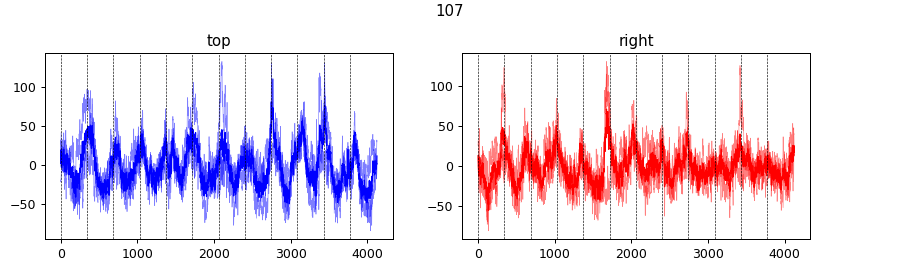

34


<IPython.core.display.Javascript object>


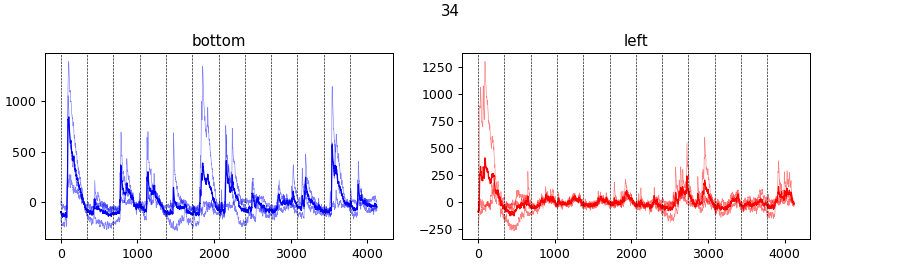

65


<IPython.core.display.Javascript object>


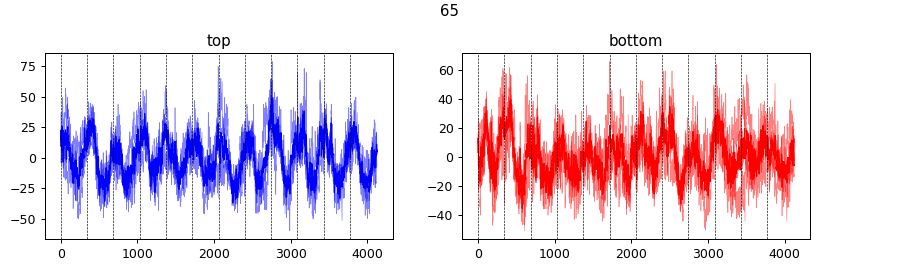

5


<IPython.core.display.Javascript object>


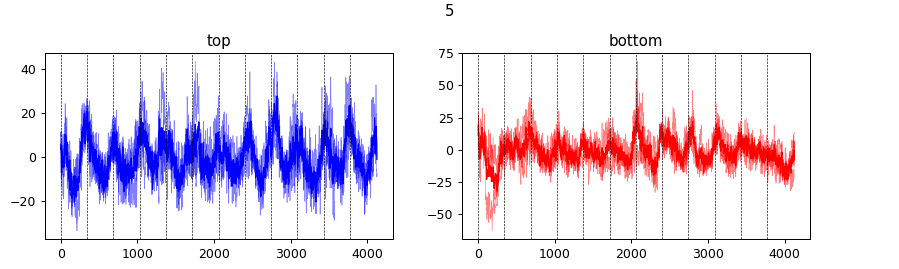

100


<IPython.core.display.Javascript object>


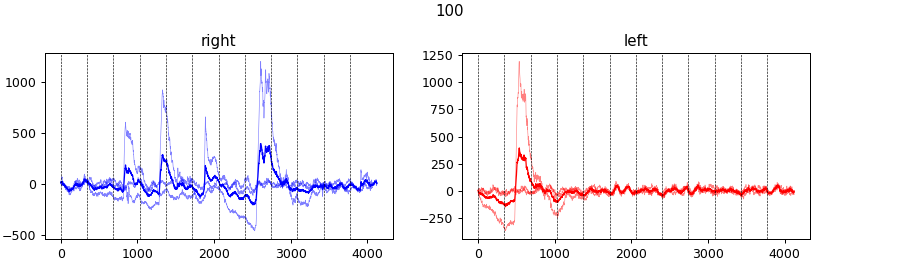

In [35]:
plot_each_condition=True

if plot_each_condition:
    
    for rid in sorted_top_rois[-5:]:
        print rid
        #c1 = mean_magratios.iloc[rid]
        c_best = mean_magratios.iloc[rid][mean_magratios.iloc[rid]==mean_magratios.iloc[rid].max()].index[0]
        c_worst = mean_magratios.iloc[rid][mean_magratios.iloc[rid]==mean_magratios.iloc[rid].min()].index[0]

        tmp_traces= dict()
        for condition in trials_by_cond.keys():
            tmp_traces[condition] = np.array([extr_traces['File%03d' % f]['processed'][rid, :] for f in trials_by_cond[condition]])
            #print"%s:" % condition, tmp_traces[condition].shape

        fig, axes = pl.subplots(1,2, figsize=(10,3))
        for aix, (c1, color) in enumerate(zip([c_best, c_worst], ['b', 'r'])):
            ax = axes[aix]
            for tr in np.arange(0, tmp_traces[c1].shape[0]):
                ax.plot(tmp_traces[c1][tr,:], color, lw=0.5, alpha=0.5)
            ax.plot(tmp_traces[c1].mean(axis=0), color, lw=1, alpha=1)
            ax.set_title(c1)
            for cyc in stiminfo[c1]['cycle_start_ixs']:
                ax.axvline(x=cyc, color='k', lw=0.5, linestyle='--')
        fig.suptitle('%i' % rid)
        pl.subplots_adjust(left=0.05, top=0.8)

# Filter data

In [36]:

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    #print nyq, normal_cutoff
    b, a = sp.signal.butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    #y = sp.signal.lfilter(b, a, data)
    y = sp.signal.filtfilt(b, a, data)
    return y



#### Test different filter params

In [37]:
# Make output dir for processing tests:
curr_figdir = os.path.join(output_dir, 'processing_filters')
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)
print "Saving processing test figs to:\n%s" % curr_figdir

Saving processing test figs to:
/n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/rf_estimates/20190404160119/processing_filters


##### Test different orders

In [38]:
# Pick an ROI to test filters on:

rid = sorted_top_rois[-1]
print "RID: %i" % int(rid+1)

tmp_traces= dict()
for condition in trials_by_cond.keys():
    tmp_traces[condition] = np.array([extr_traces['File%03d' % f]['processed'][rid, :] for f in trials_by_cond[condition]])
    #print"%s:" % condition, tmp_traces[condition].shape


RID: 101


<IPython.core.display.Javascript object>


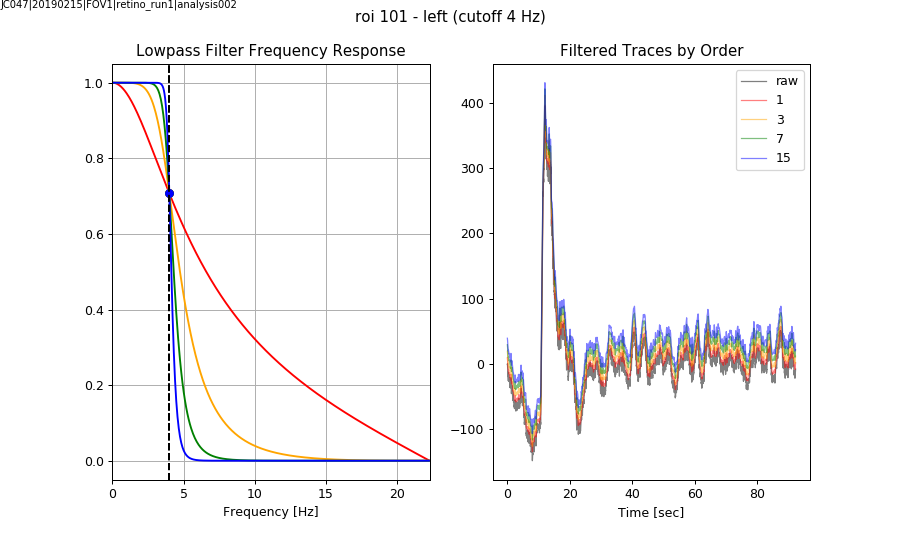

LP_freq_results_by_order_roi00101_cutoff4Hz.png
Saved to: /n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/rf_estimates/20190404160119/processing_filters


In [39]:
orders_to_test = [1,3,7, 15]
colors = ['r', 'orange', 'green', 'blue', 'purple']

cutoff = 4  # desired cutoff frequency of the filter, Hz
fs = stiminfo[c1]['frame_rate'] #30.0       # sample rate, Hz


fig, axes = pl.subplots(1,2, figsize=(10,6))
plot_offset = 10

c_best = mean_magratios.iloc[rid][mean_magratios.iloc[rid]==mean_magratios.iloc[rid].max()].index[0]
c_worst = mean_magratios.iloc[rid][mean_magratios.iloc[rid]==mean_magratios.iloc[rid].min()].index[0]

filts = []
for ai, order in enumerate(orders_to_test):
    
    ax = axes[0]
    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)

    # Plot the frequency response.
    w, h = sp.signal.freqz(b, a) #, worN=8000)
    ax.plot(0.5*fs*w/np.pi, np.abs(h), colors[ai])
    ax.plot(cutoff, 0.5*np.sqrt(2), marker='o', color=colors[ai], label=order)
    ax.axvline(cutoff, color='k', linestyle='--')
    ax.set_xlim([0, 0.5*fs])
    ax.grid('on')
    ax.set_title("Lowpass Filter Frequency Response")
    ax.set_xlabel('Frequency [Hz]')


    ax = axes[1]
    T = (1./stiminfo[c1]['stimfreq']) * stiminfo[c1]['n_cycles'] #* #5.0         # seconds
    n = int(stiminfo[c1]['nframes']) #int(T * fs) # total number of samples
    t = np.linspace(0, T, n, endpoint=False)
    data = tmp_traces[c1].mean(axis=0) 

    # Filter the data, and plot both the original and filtered signals.
    y = butter_lowpass_filter(data, cutoff, fs, order)
    filts.append(y)
    if ai==0:
        ax.plot(t, data, 'k-', linewidth=1, alpha=0.5, label='raw')
    ax.plot(t, y + ((ai+1)*plot_offset), color=colors[ai], linestyle='-', linewidth=1, alpha=0.5, label=order)
    ax.set_xlabel('Time [sec]')
    ax.set_title('Filtered Traces by Order')

pl.legend()
    
fig.suptitle('roi %i - %s (cutoff %i Hz)' % (int(rid+1), c1, cutoff))
label_figure(fig, data_identifier)
figname = 'LP_freq_results_by_order_roi%05d_cutoff%iHz.png' % (int(rid+1), cutoff)

pl.savefig(os.path.join(curr_figdir, '%s.png' % figname))
print figname
print "Saved to:", curr_figdir

##### Test different cutoff frequencies

<IPython.core.display.Javascript object>


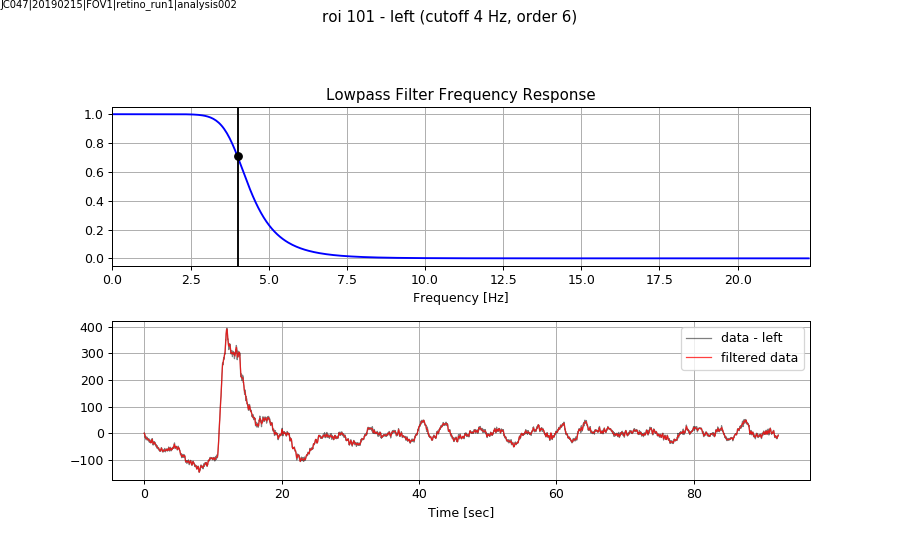

example_filter_results_roi00101_order6_cutoff4Hz
Saved to: /n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/rf_estimates/20190404160119/processing_filters


In [40]:

# Filter requirements.
# -------------------------------------------------------------------
order = 6
cutoff = 4  # desired cutoff frequency of the filter, Hz
fs = stiminfo[c1]['frame_rate'] #30.0       # sample rate, Hz
# -------------------------------------------------------------------


fig = pl.figure(figsize=(10,6))

#for order in [1,3,5,7,9]:
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = sp.signal.freqz(b, a) #, worN=8000)
pl.subplot(2, 1, 1)
pl.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
pl.plot(cutoff, 0.5*np.sqrt(2), 'ko')
pl.axvline(cutoff, color='k')
pl.xlim(0, 0.5*fs)
pl.title("Lowpass Filter Frequency Response")
pl.xlabel('Frequency [Hz]')
pl.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = (1./stiminfo[c1]['stimfreq']) * stiminfo[c1]['n_cycles'] #* #5.0         # seconds
n = int(stiminfo[c1]['nframes']) #int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
data = tmp_traces[c1].mean(axis=0) 

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

pl.subplot(2, 1, 2)
pl.plot(t, data, 'k-', linewidth=1, alpha=0.5, label='data - %s' % c1)
pl.plot(t, y, 'r-', linewidth=1, alpha=0.75, label='filtered data')
pl.xlabel('Time [sec]')
pl.grid()
pl.legend()

pl.subplots_adjust(hspace=0.35, top=0.8)

fig.suptitle('roi %i - %s (cutoff %i Hz, order %i)' % (int(rid+1), c1, cutoff, order))
label_figure(fig, data_identifier)
figname = 'example_filter_results_roi%05d_order%i_cutoff%iHz' % (int(rid+1), order, cutoff)
pl.savefig(os.path.join(curr_figdir, '%s.png' % figname))

print figname
print "Saved to:", curr_figdir

##### Use filter params to filter each individual rep of each conditon (full trace)

<IPython.core.display.Javascript object>


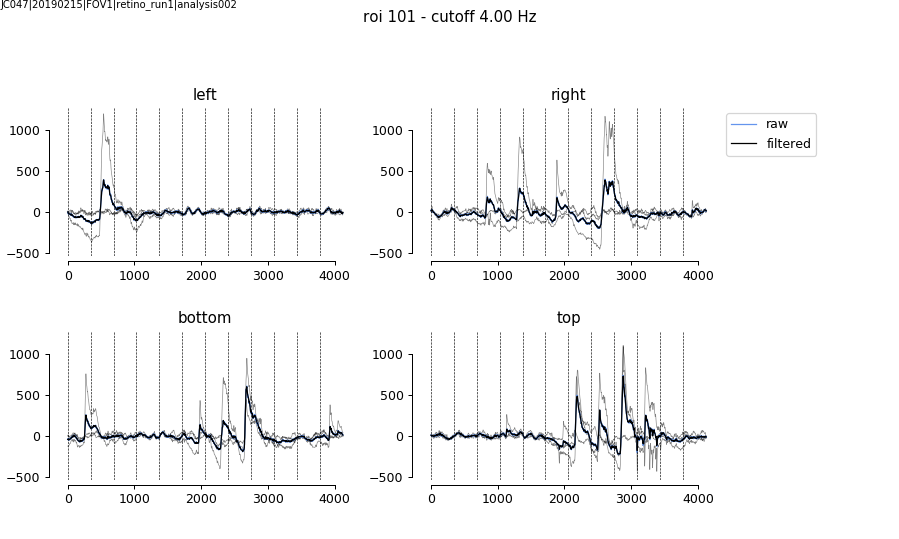

traces_by_cond_roi00101_lowpass4Hz
Saved to: /n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/rf_estimates/20190404160119/processing_filters


In [41]:
filt_traces = {}
for cond in trials_by_cond.keys():
    filt_traces[cond] = np.empty(tmp_traces[cond].shape, dtype=tmp_traces[cond].dtype)
    for repnum in np.arange(0, tmp_traces[cond].shape[0]):
        y = butter_lowpass_filter(tmp_traces[cond][repnum,:], cutoff, fs, order)
        filt_traces[cond][repnum, :] = y


fig, axes = pl.subplots(2,2, sharex=True, sharey=True, figsize=(10,6)) #, figsize=(8,))

for aix, cond in enumerate(['left', 'right', 'bottom', 'top']):
    ax = axes.flat[aix]
    for repnum in np.arange(0, filt_traces[cond].shape[0]):
        ax.plot(filt_traces[cond][repnum, :], 'k', alpha=0.5, lw=0.5)
    filt_label = 'filtered' if aix==1 else None
    raw_label = 'raw' if aix==1 else None
    ax.plot(tmp_traces[cond].mean(axis=0), 'cornflowerblue', alpha=1, linewidth=1, label=raw_label)
    ax.plot(filt_traces[cond].mean(axis=0), 'k', linewidth=1, label=filt_label)
    ax.set_title(cond)
    for cyc in stiminfo[cond]['cycle_start_ixs']:
        ax.axvline(x=cyc, color='k', linestyle='--', linewidth=0.5)
        
fig.suptitle("roi %i - cutoff %.2f Hz" % (int(rid+1), cutoff))
pl.subplots_adjust(hspace=0.5, top=0.8, left=0.06, right=0.8)
axes.flat[1].legend(bbox_to_anchor=(1, 1))
sns.despine(offset=4, trim=True)

label_figure(fig, data_identifier)
figname = 'traces_by_cond_roi%05d_lowpass%iHz' % (int(rid+1), cutoff) #%.2f'
pl.savefig(os.path.join(curr_figdir, '%s.png' % figname))
print figname
print "Saved to:", curr_figdir

# Update output_dir to be more descriptive


In [42]:
# Update output_dir to be more descriptive


roi_set_str = 'select_top_%s_magthr_%.2f_by_%s' % ('fit' if use_fit else 'magr', mag_thr, mag_thr_stat)
filter_params_str = 'filter_lowpass_%iHz' % cutoff

print roi_set_str

os.rename(output_dir, '%s_%s_%s' % (output_dir, roi_set_str, filter_params_str))
output_dir = '%s_%s_%s' % (output_dir, roi_set_str, filter_params_str)
print "Renamed tmp output dir to:\n", os.path.join(output_dir)


select_top_magr_magthr_0.02_by_allconds
Renamed tmp output dir to:
/n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/rf_estimates/20190404160119_select_top_magr_magthr_0.02_by_allconds_filter_lowpass_4Hz


In [49]:
mag_thr

0.023966320036674947

# Get averaged "cycle" and identify onset/offset and peaks

### RF estimates for all ROIs

In [45]:
print sorted_top_rois

[ 37  55   3  42  28  27  77  36  80  63  26  83  53  46  19  97  13 107
  34  65   5 100]


In [67]:
# Set params for cycle-parsing, filtering, and thresholding:
# -----------------------------------------------------------------------------------------------
roi_list = sorted_top_rois.copy() #absolute_coords['strong_cells']
print "ROIs (%i):" % len(roi_list), roi_list

chunksize = 3
plot_each_condition = True
filter_traces = True

# cutoff = 4
# fs = stiminfo['left']['frame_rate'] #30.0       # sample rate, Hz
# order = 6

# Set params for calcuting "onset" response:
nstds_above_baseline = 2
window_nsecs = 0.5

# Plot colors:
c1_color = 'blue'
c2_color = 'orange'


ROIs (22): [ 37  55   3  42  28  27  77  36  80  63  26  83  53  46  19  97  13 107
  34  65   5 100]


# Parse and fit ALL rois

In [68]:
stiminfo[cond]

{'cycle_start_ixs': array([   0,  343,  686, 1029, 1372, 1715, 2058, 2401, 2744, 3087, 3430,
        3773]),
 'frame_rate': 44.6329,
 'n_cycles': 12,
 'n_frames_per_cycle': 343,
 'n_reps': 3,
 'nframes': 4125,
 'stimfreq': 0.13}

Saving ROI figures to: /n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/rf_estimates/20190404160119_select_top_magr_magthr_0.02_by_allconds_filter_lowpass_4Hz/cyclesize3/parsed_cycles_by_roi
37
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


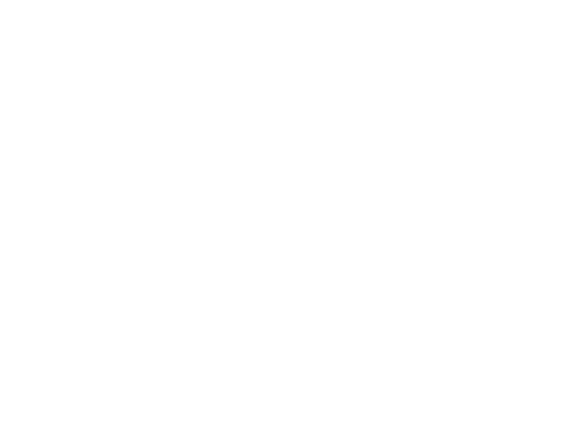

traces_by_cond_roi00038_lowpass4Hz


<IPython.core.display.Javascript object>


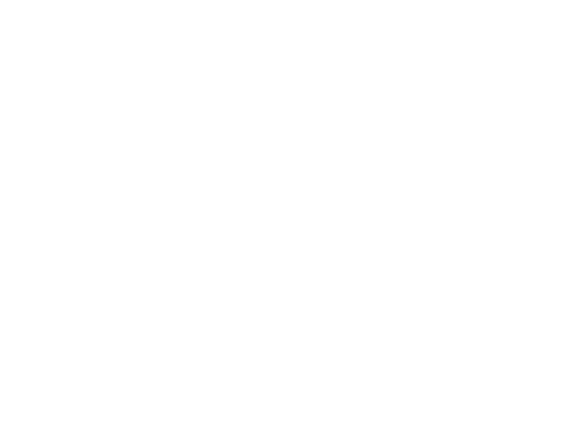

avg_3cycle_by_cond_roi00038


<IPython.core.display.Javascript object>


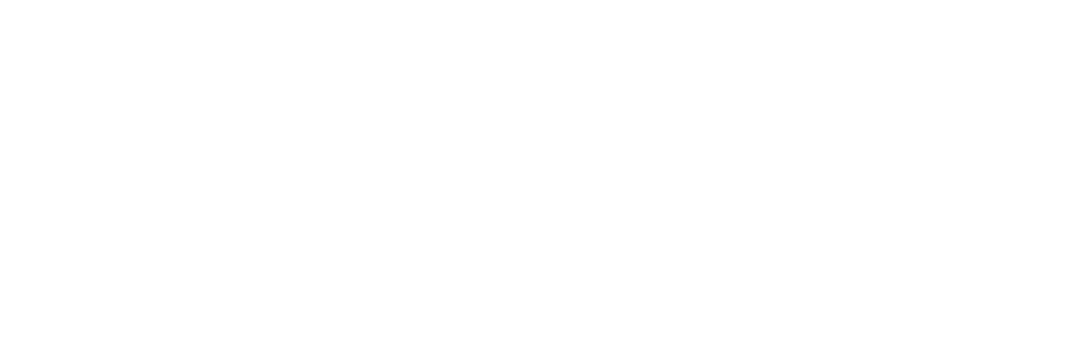

time_v_intensity_cycle_loci_3cycle_by_cond_roi00038
[top] Onset 21.32 deg (std 5.08). Peak @ -3.77 deg.
[right] Onset 31.20 deg (std 2.68). Peak @ 10.74 deg.
[bottom] Onset -2.00 deg (std 6.66). Peak @ 23.08 deg.
[left] Onset 10.08 deg (std 1.76). Peak @ 28.67 deg.
Relative coords? False
Lin coords from phase x, y = (28.56, -3.40)
ROI 38 - summary - 
Phase coords (x, y): (28.56, -3.40)
Left/Right edges: [10.08, 31.20]
--> left onsets: [ 10.38652973  12.05900988   7.78963428]
--> right onsets: [ 34.21084623  31.70230463  27.69996922]
Bottom/Top edges: [-2.00, 21.32]
--> top onsets: [ 17.89649268  28.50971905  17.56017047]
--> bottom onsets: [  2.69655604   2.72652396 -11.42413694]


<IPython.core.display.Javascript object>


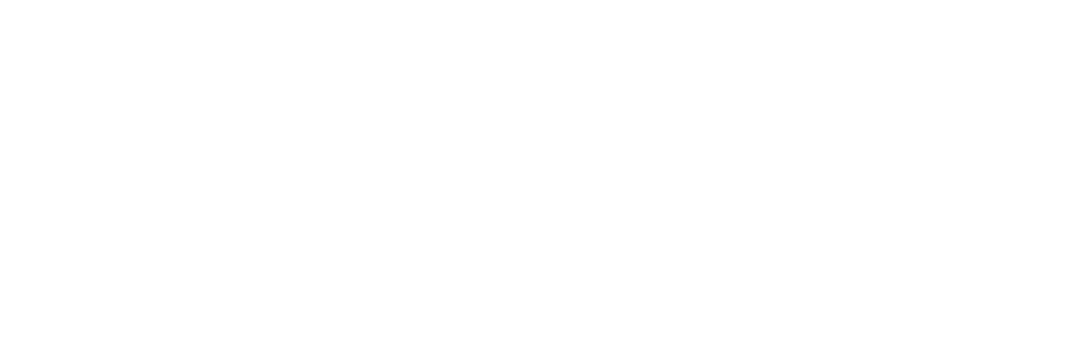

position_v_intensity_cycle_loci_3cycle_by_cond_roi00038


<IPython.core.display.Javascript object>


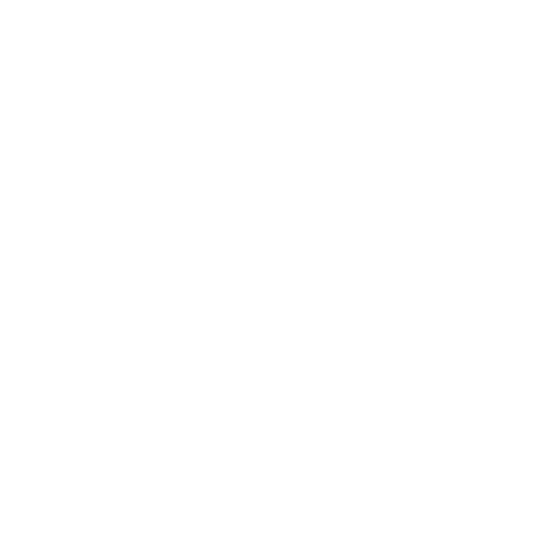

55
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


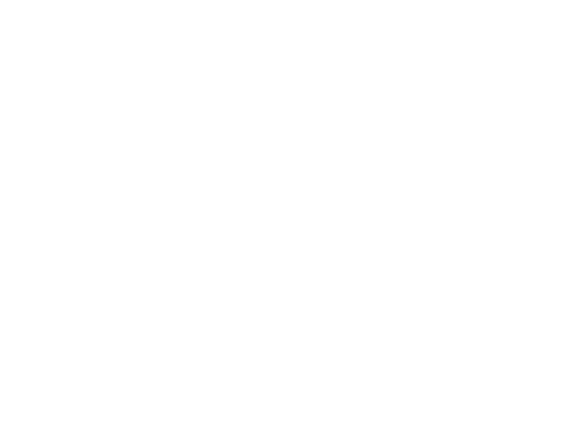

traces_by_cond_roi00056_lowpass4Hz


<IPython.core.display.Javascript object>


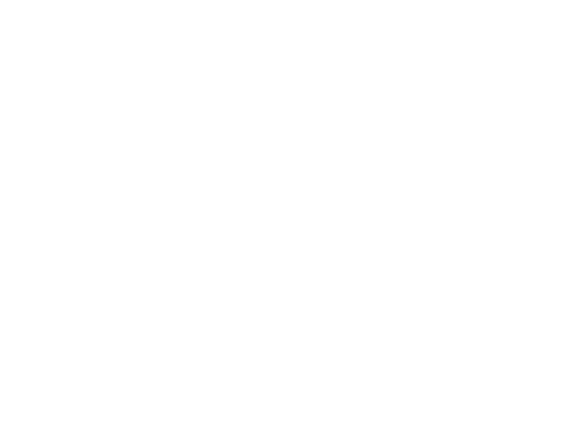

avg_3cycle_by_cond_roi00056


<IPython.core.display.Javascript object>


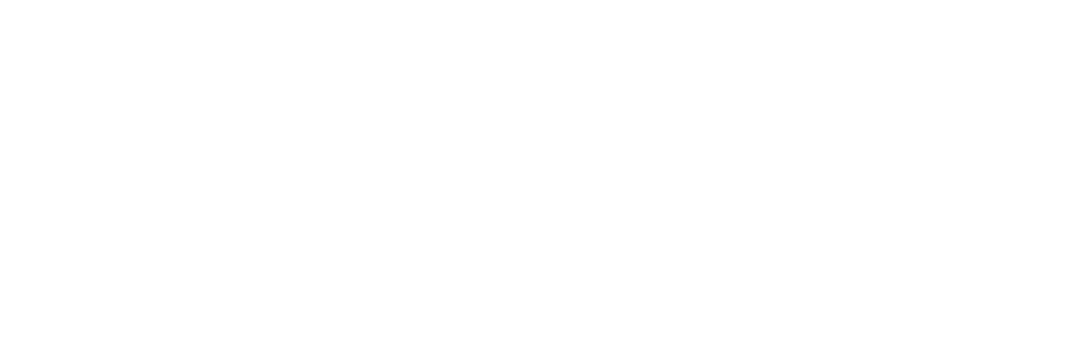

time_v_intensity_cycle_loci_3cycle_by_cond_roi00056
[top] Onset 18.12 deg (std 6.61). Peak @ -4.48 deg.
[right] Onset 33.96 deg (std 7.95). Peak @ 19.82 deg.
[bottom] Onset -2.80 deg (std 6.12). Peak @ 21.30 deg.
[left] Onset 13.01 deg (std 2.20). Peak @ 39.35 deg.
Relative coords? False
Lin coords from phase x, y = (18.98, -4.04)
ROI 56 - summary - 
Phase coords (x, y): (18.98, -4.04)
Left/Right edges: [13.01, 33.96]
--> left onsets: [ 10.92559932  16.06251268  12.05110407]
--> right onsets: [ 22.733346    39.97737325  39.17853156]
Bottom/Top edges: [-2.80, 18.12]
--> top onsets: [ 12.82589659  27.44379582  14.08572542]
--> bottom onsets: [-11.45073281   1.38982529   1.65022509]


<IPython.core.display.Javascript object>


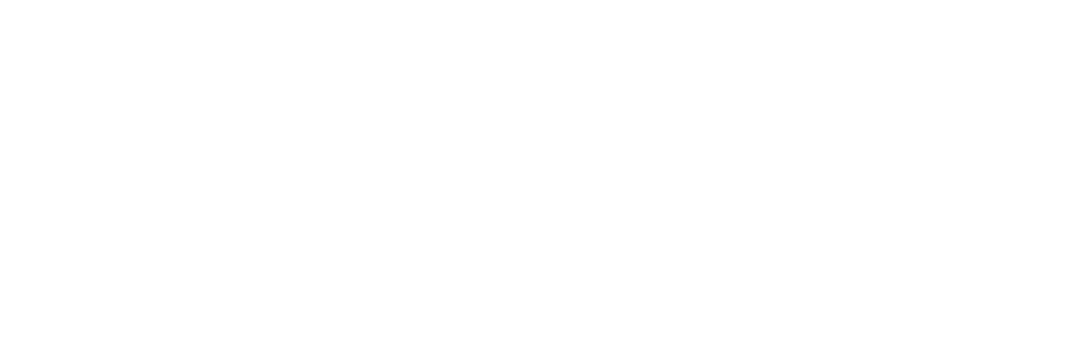

position_v_intensity_cycle_loci_3cycle_by_cond_roi00056


<IPython.core.display.Javascript object>


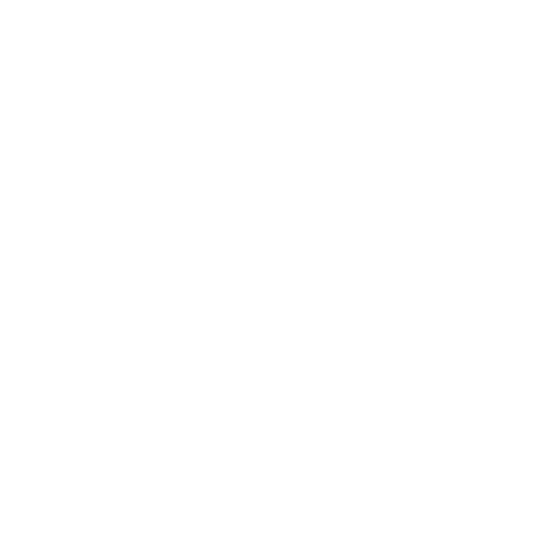

3
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


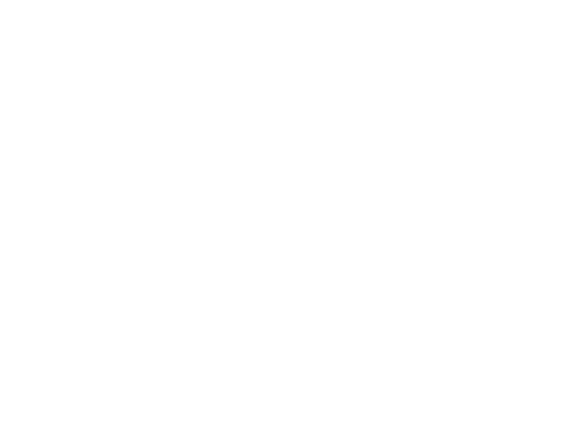

traces_by_cond_roi00004_lowpass4Hz


<IPython.core.display.Javascript object>


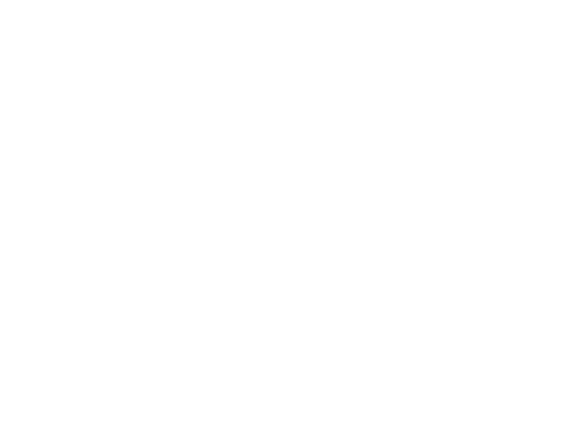

avg_3cycle_by_cond_roi00004


<IPython.core.display.Javascript object>


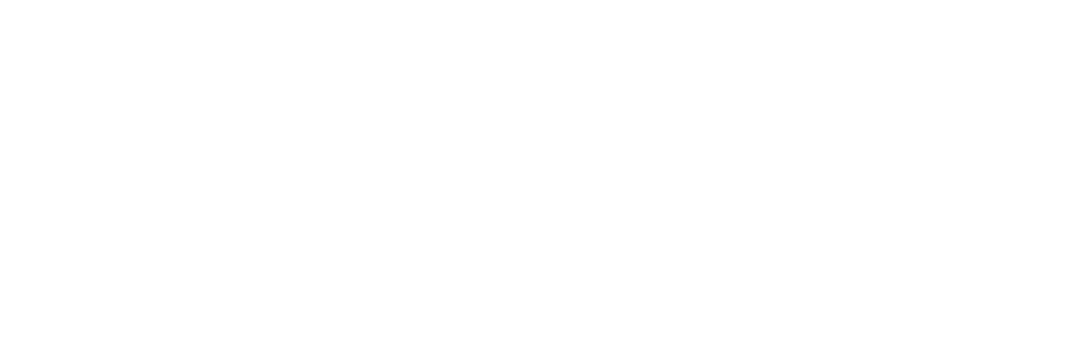

time_v_intensity_cycle_loci_3cycle_by_cond_roi00004
[top] Onset 15.27 deg (std 22.56). Peak @ 4.60 deg.
[right] Onset 42.86 deg (std 1.21). Peak @ 40.99 deg.
[bottom] Onset -40.97 deg (std 3.16). Peak @ -33.23 deg.
[left] Onset -28.26 deg (std 20.55). Peak @ -11.01 deg.
Relative coords? False
Lin coords from phase x, y = (-20.99, -1.28)
ROI 4 - summary - 
Phase coords (x, y): (-20.99, -1.28)
Left/Right edges: [-28.26, 42.86]
--> left onsets: [  0.7793873  -41.84676313 -43.71525574]
--> right onsets: [ 41.14810672  43.71525574  43.71525574]
Bottom/Top edges: [-40.97, 15.27]
--> top onsets: [ 27.23419043 -16.3258801   34.91205707]
--> bottom onsets: [-36.5414684  -42.64671141 -43.71525574]


<IPython.core.display.Javascript object>


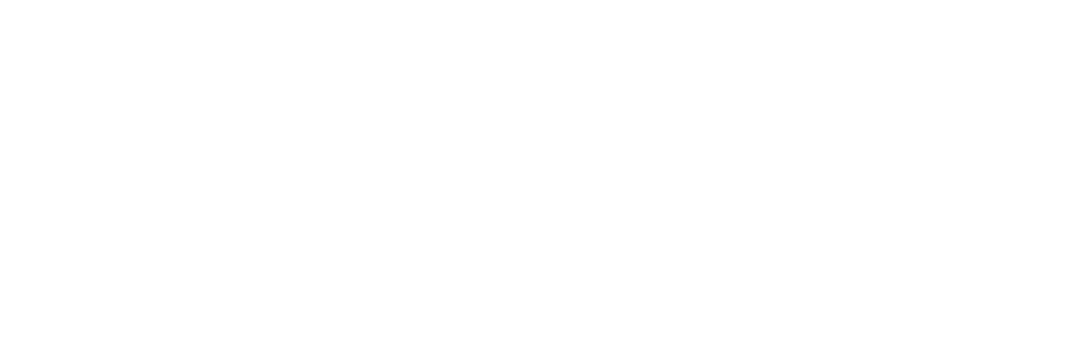

position_v_intensity_cycle_loci_3cycle_by_cond_roi00004


<IPython.core.display.Javascript object>


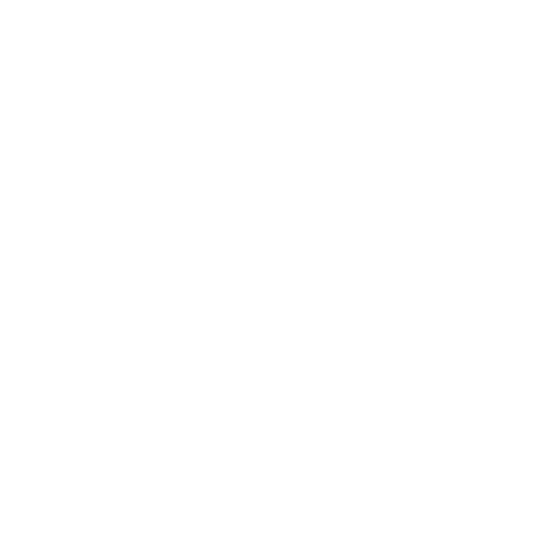

42
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


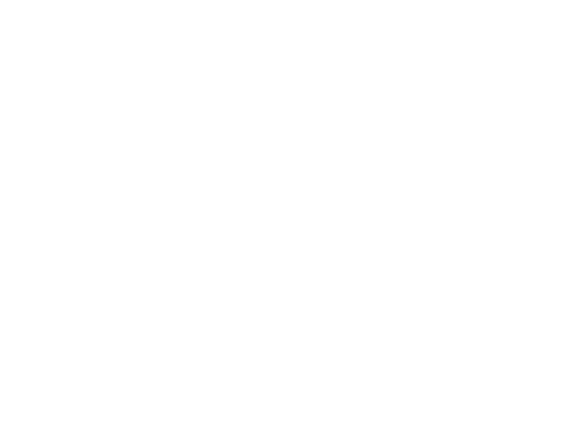

traces_by_cond_roi00043_lowpass4Hz


<IPython.core.display.Javascript object>


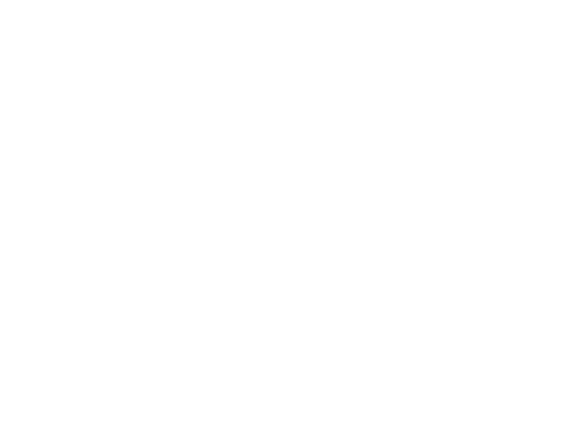

avg_3cycle_by_cond_roi00043


<IPython.core.display.Javascript object>


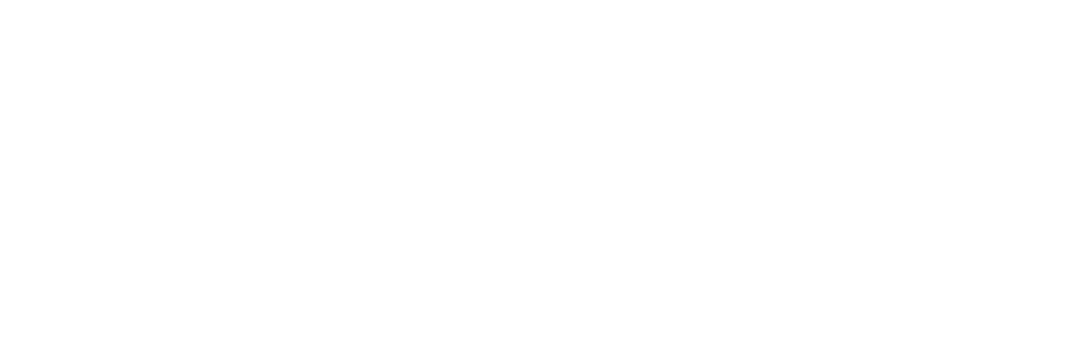

time_v_intensity_cycle_loci_3cycle_by_cond_roi00043
[top] Onset 26.40 deg (std 6.47). Peak @ 4.60 deg.
[right] Onset 38.85 deg (std 3.12). Peak @ 8.96 deg.
[bottom] Onset -0.49 deg (std 11.51). Peak @ 20.95 deg.
[left] Onset 11.33 deg (std 0.57). Peak @ 42.64 deg.
Relative coords? False
Lin coords from phase x, y = (21.23, -7.84)
ROI 43 - summary - 
Phase coords (x, y): (21.23, -7.84)
Left/Right edges: [11.33, 38.85]
--> left onsets: [ 10.66148246  12.05900988  11.25869769]
--> right onsets: [ 35.01001182  38.90832019  42.64580919]
Bottom/Top edges: [-0.49, 26.40]
--> top onsets: [ 17.89649268  33.58364581  27.71000462]
--> bottom onsets: [  7.23411573   8.05956508 -16.76518709]


<IPython.core.display.Javascript object>


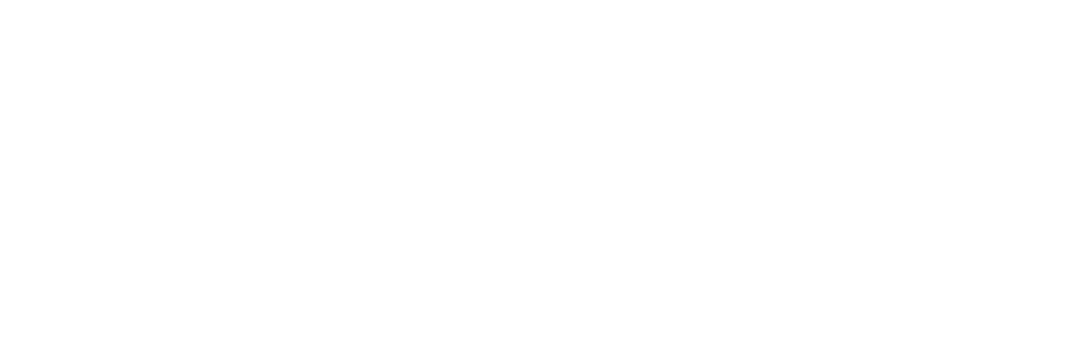

position_v_intensity_cycle_loci_3cycle_by_cond_roi00043


<IPython.core.display.Javascript object>


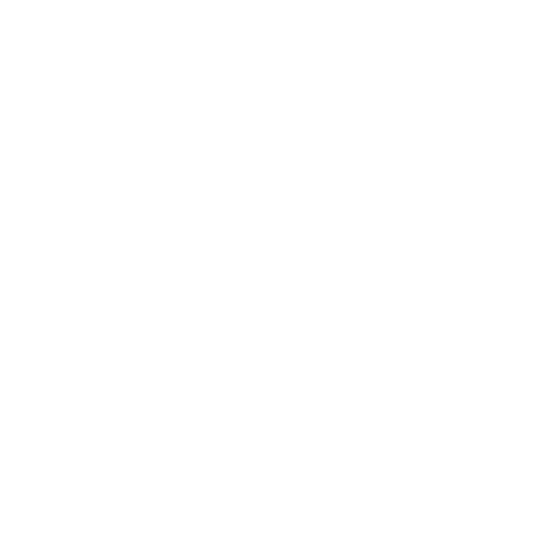

28
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


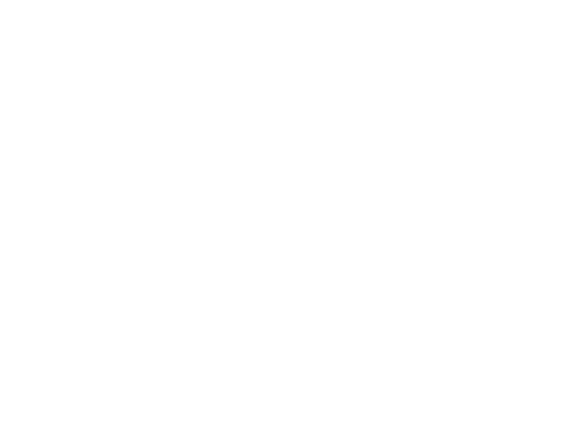

traces_by_cond_roi00029_lowpass4Hz


<IPython.core.display.Javascript object>


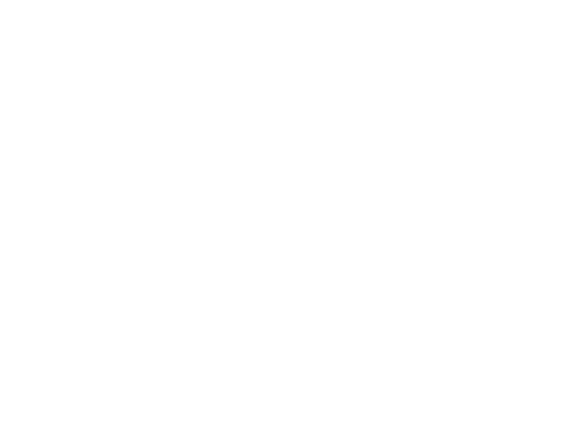

avg_3cycle_by_cond_roi00029


<IPython.core.display.Javascript object>


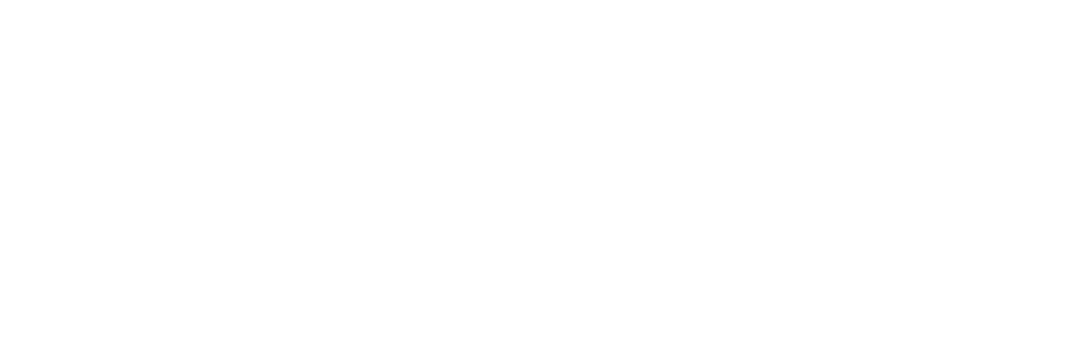

time_v_intensity_cycle_loci_3cycle_by_cond_roi00029
[top] Onset 32.88 deg (std 6.39). Peak @ 20.79 deg.
[right] Onset 42.15 deg (std 2.22). Peak @ 39.39 deg.
[bottom] Onset -34.92 deg (std 3.94). Peak @ -19.35 deg.
[left] Onset -39.12 deg (std 3.07). Peak @ -24.17 deg.
Relative coords? False
Lin coords from phase x, y = (-10.16, -0.43)
ROI 29 - summary - 
Phase coords (x, y): (-10.16, -0.43)
Left/Right edges: [-39.12, 42.15]
--> left onsets: [-35.77481364 -43.18399315 -38.38779687]
--> right onsets: [ 39.0114855   43.71525574  43.71525574]
Bottom/Top edges: [-34.92, 32.88]
--> top onsets: [ 31.50597375  25.8345168   41.31232112]
--> bottom onsets: [-34.39628973 -39.98356424 -30.36772889]


<IPython.core.display.Javascript object>


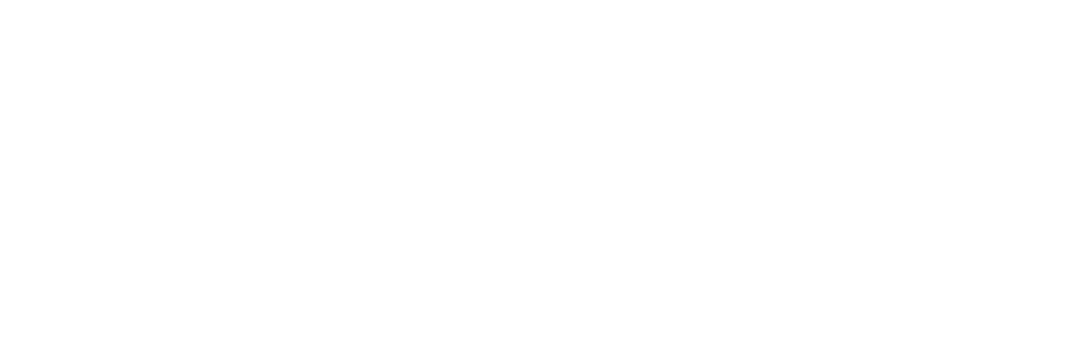

position_v_intensity_cycle_loci_3cycle_by_cond_roi00029


<IPython.core.display.Javascript object>


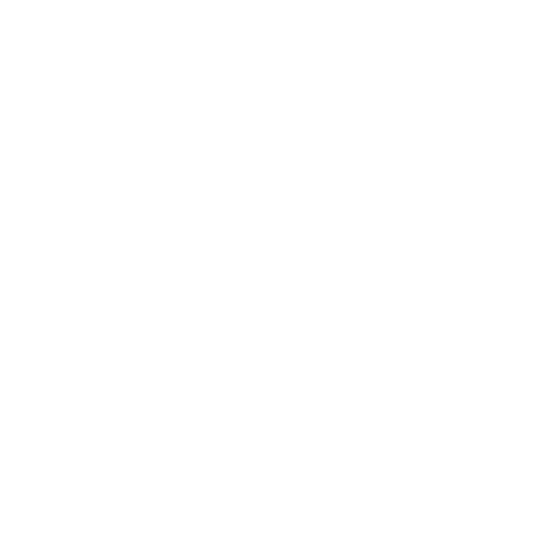

27
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


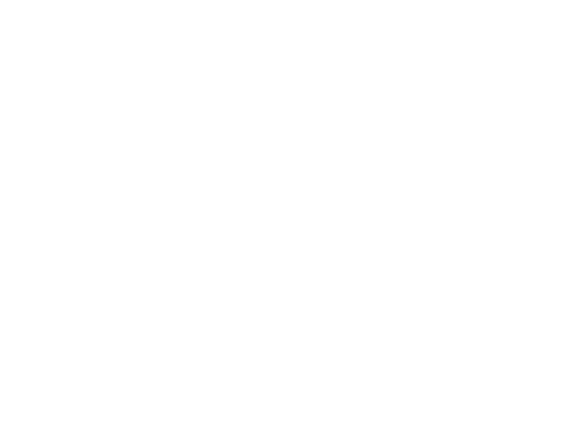

traces_by_cond_roi00028_lowpass4Hz


<IPython.core.display.Javascript object>


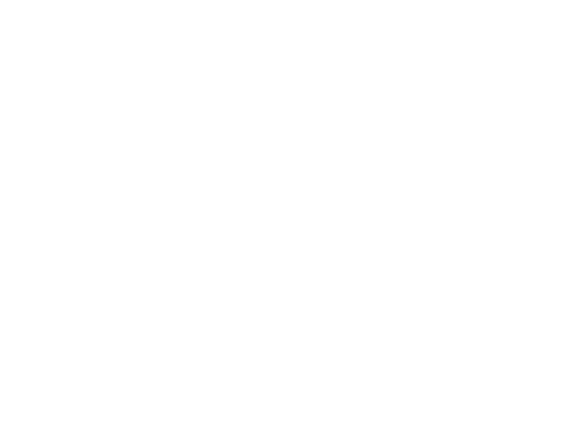

avg_3cycle_by_cond_roi00028


<IPython.core.display.Javascript object>


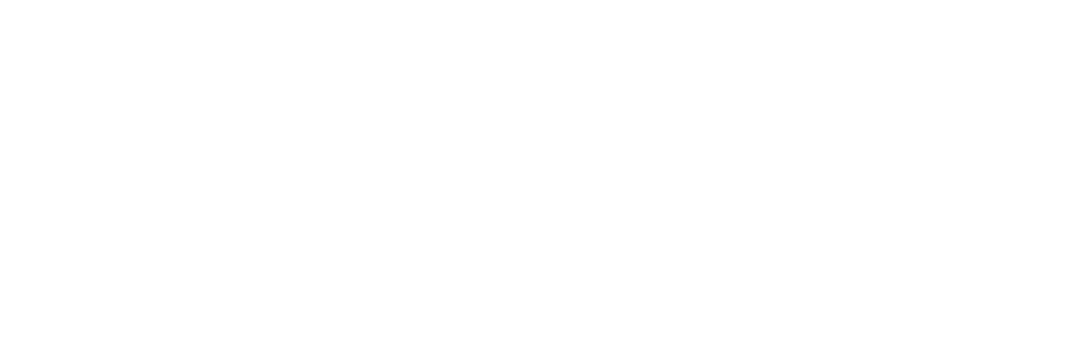

time_v_intensity_cycle_loci_3cycle_by_cond_roi00028
[top] Onset 18.65 deg (std 1.88). Peak @ 3.00 deg.
[right] Onset 35.21 deg (std 2.71). Peak @ 10.30 deg.
[bottom] Onset -15.88 deg (std 10.88). Peak @ 17.30 deg.
[left] Onset 3.94 deg (std 3.21). Peak @ 23.33 deg.
Relative coords? False
Lin coords from phase x, y = (29.32, -4.33)
ROI 28 - summary - 
Phase coords (x, y): (29.32, -4.33)
Left/Right edges: [3.94, 35.21]
--> left onsets: [ 5.31928267  6.98889443 -0.48926295]
--> right onsets: [ 34.21084623  38.90832019  32.50117692]
Bottom/Top edges: [-15.88, 18.65]
--> top onsets: [ 17.09090111  17.56865446  21.29847529]
--> bottom onsets: [-12.25755024  -4.74881193 -30.64335685]


<IPython.core.display.Javascript object>


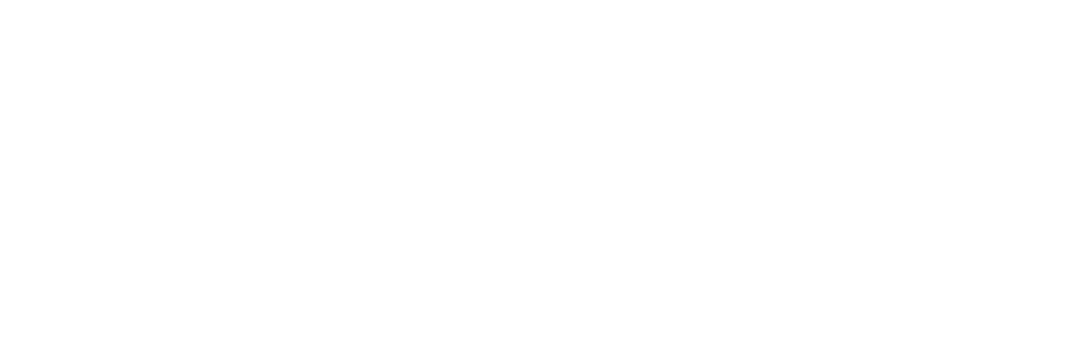

position_v_intensity_cycle_loci_3cycle_by_cond_roi00028


<IPython.core.display.Javascript object>


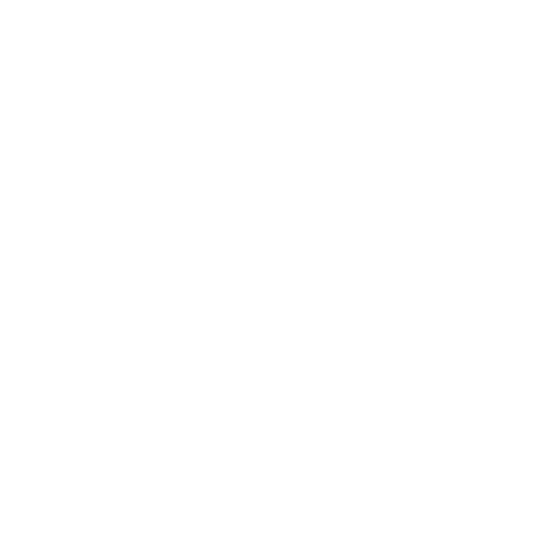

77
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


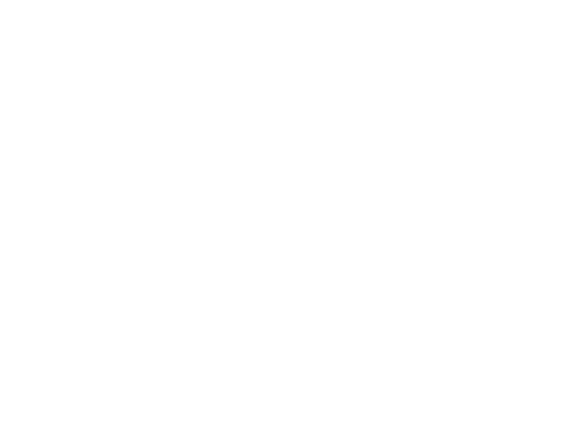

traces_by_cond_roi00078_lowpass4Hz


<IPython.core.display.Javascript object>


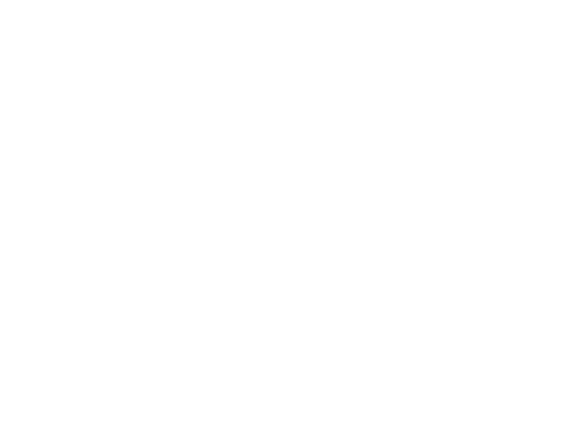

avg_3cycle_by_cond_roi00078


<IPython.core.display.Javascript object>


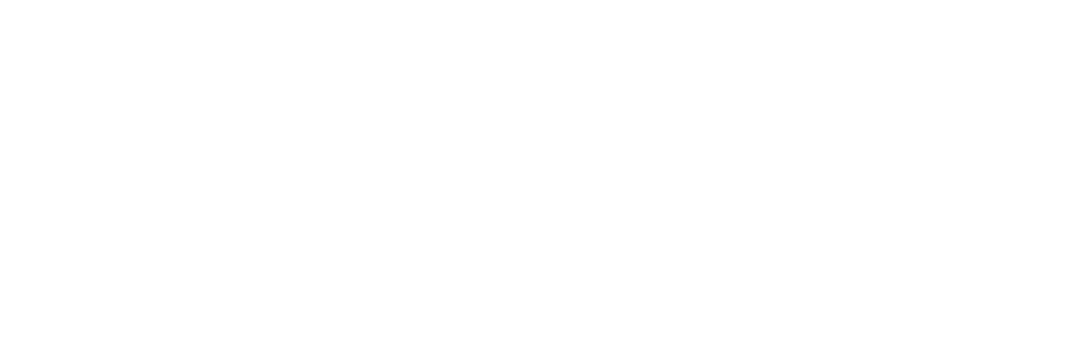

time_v_intensity_cycle_loci_3cycle_by_cond_roi00078
[top] Onset 11.09 deg (std 1.65). Peak @ -4.65 deg.
[right] Onset 37.52 deg (std 0.73). Peak @ 19.10 deg.
[bottom] Onset -1.83 deg (std 2.26). Peak @ 9.12 deg.
[left] Onset 12.30 deg (std 3.60). Peak @ 32.58 deg.
Relative coords? False
Lin coords from phase x, y = (21.21, -0.33)
ROI 78 - summary - 
Phase coords (x, y): (21.21, -0.33)
Left/Right edges: [12.30, 37.52]
--> left onsets: [  9.85820465  17.39778015   9.64950207]
--> right onsets: [ 38.21169653  36.50467456  37.84248492]
Bottom/Top edges: [-1.83, 11.09]
--> top onsets: [ 12.29029998  12.23273874   8.75449123]
--> bottom onsets: [-0.24348179 -5.01646494 -0.21666027]


<IPython.core.display.Javascript object>


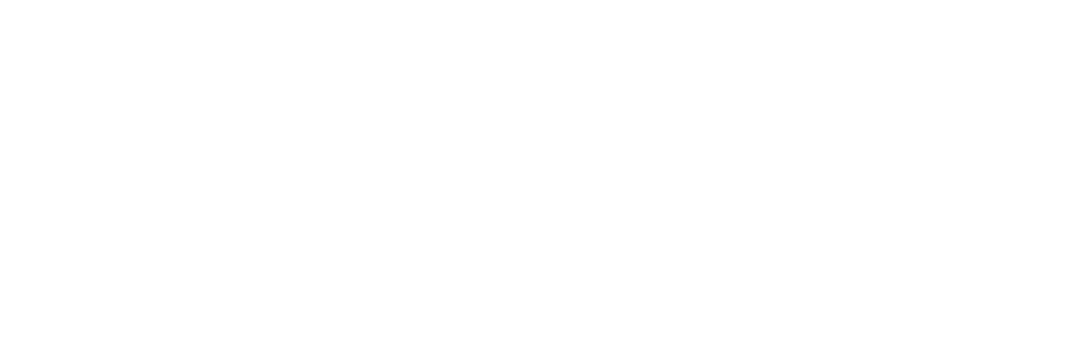

position_v_intensity_cycle_loci_3cycle_by_cond_roi00078


<IPython.core.display.Javascript object>


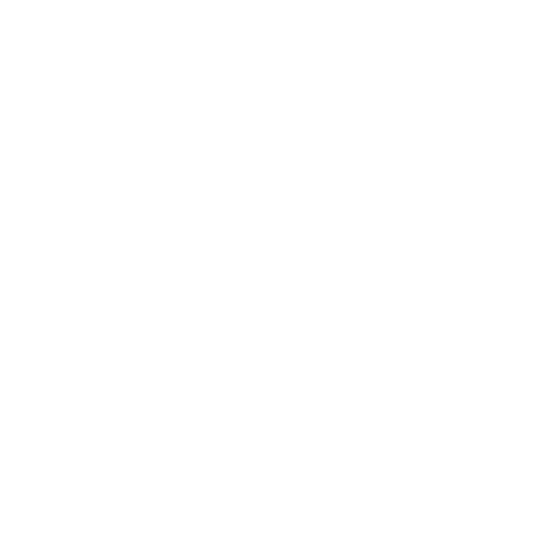

36
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


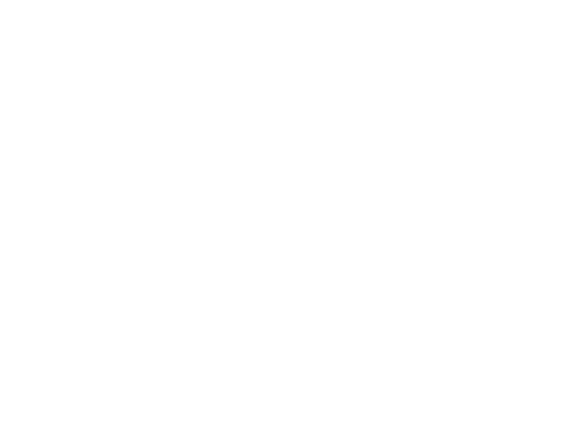

traces_by_cond_roi00037_lowpass4Hz


<IPython.core.display.Javascript object>


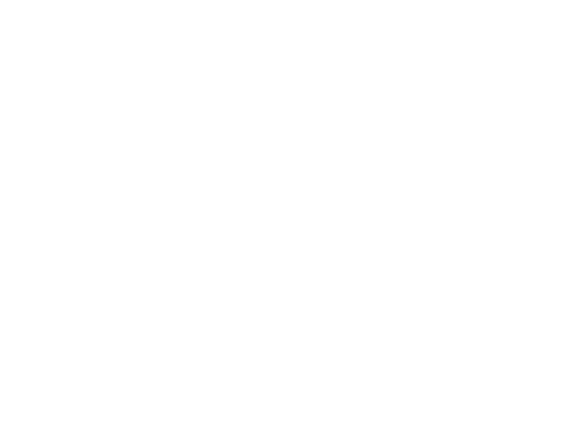

avg_3cycle_by_cond_roi00037


<IPython.core.display.Javascript object>


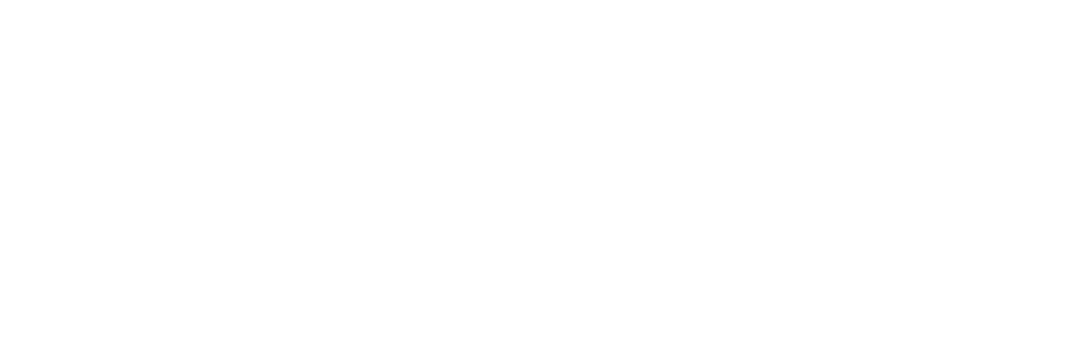

time_v_intensity_cycle_loci_3cycle_by_cond_roi00037
[top] Onset 42.14 deg (std 2.23). Peak @ 40.45 deg.
[right] Onset 13.41 deg (std 21.67). Peak @ -16.21 deg.
[bottom] Onset -36.96 deg (std 2.66). Peak @ -33.58 deg.
[left] Onset -41.16 deg (std 3.25). Peak @ -27.82 deg.
Relative coords? False
Lin coords from phase x, y = (-13.49, -2.64)
ROI 37 - summary - 
Phase coords (x, y): (-13.49, -2.64)
Left/Right edges: [-41.16, 13.41]
--> left onsets: [-36.58046565 -43.18399315 -43.71525574]
--> right onsets: [ -6.88959689  43.44147303   3.67837036]
Bottom/Top edges: [-36.96, 42.14]
--> top onsets: [ 38.97889709  43.71525574  43.71525574]
--> bottom onsets: [-36.26787771 -40.51701678 -34.10914161]


<IPython.core.display.Javascript object>


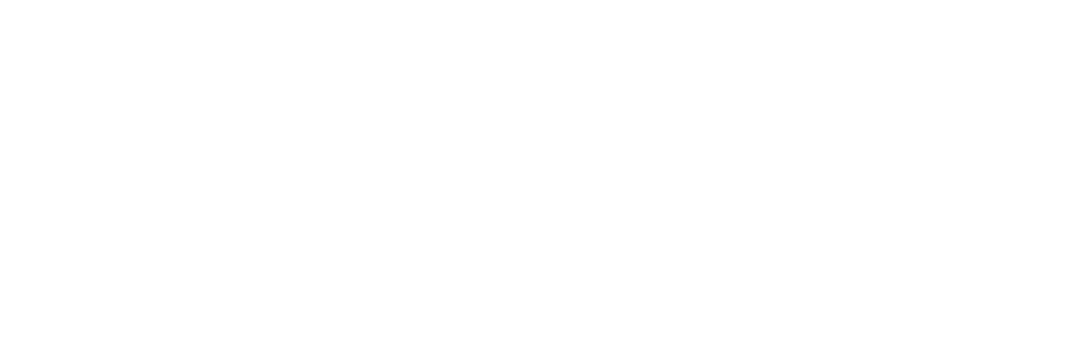

position_v_intensity_cycle_loci_3cycle_by_cond_roi00037


<IPython.core.display.Javascript object>


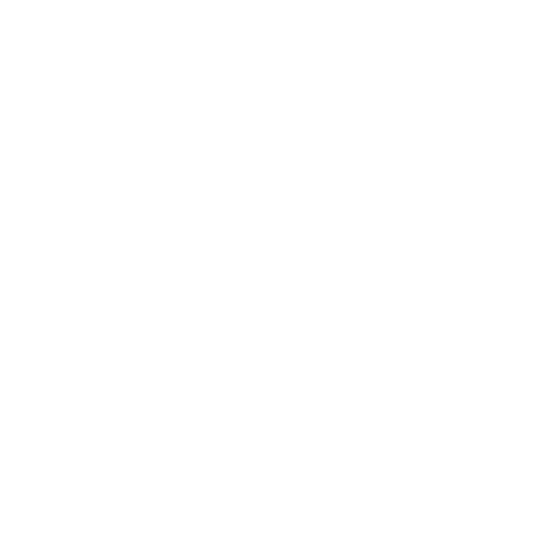

80
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


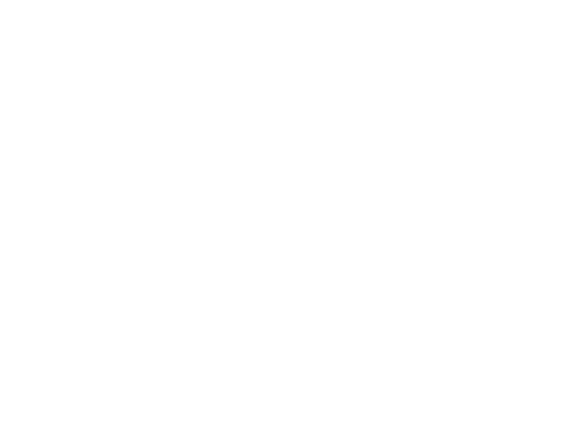

traces_by_cond_roi00081_lowpass4Hz


<IPython.core.display.Javascript object>


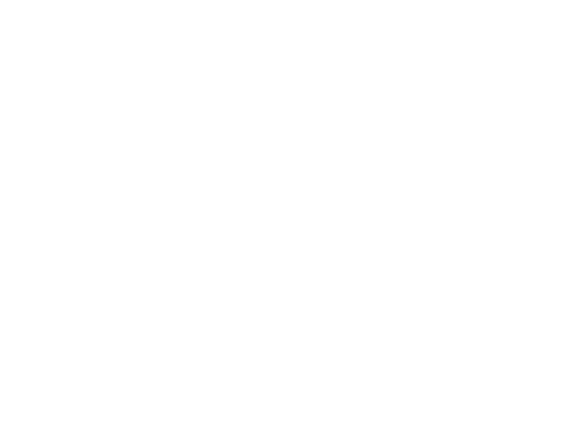

avg_3cycle_by_cond_roi00081
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...


<IPython.core.display.Javascript object>


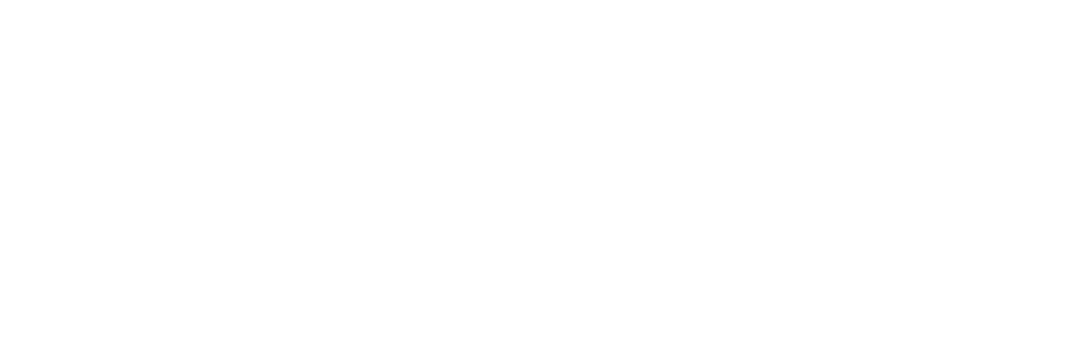

time_v_intensity_cycle_loci_3cycle_by_cond_roi00081
[top] Onset -2.52 deg (std 22.02). Peak @ -21.02 deg.
[right] Onset 18.66 deg (std 16.28). Peak @ -15.14 deg.
[bottom] Onset 2.45 deg (std 32.33). Peak @ 15.43 deg.
[left] Onset -34.05 deg (std 1.17). Peak @ -16.61 deg.
Relative coords? False
Lin coords from phase x, y = (-21.05, 1.86)
ROI 81 - summary - 
Phase coords (x, y): (-21.05, 1.86)
Left/Right edges: [-34.05, 18.66]
--> left onsets: [-32.57907916 -34.11173595 -35.44746957]
--> right onsets: [ 41.68315039   7.15252914   7.1462755 ]
Bottom/Top edges: [2.45, -2.52]
--> top onsets: [-22.13415432 -13.65801419  28.23490265]
--> bottom onsets: [-43.20781491  27.53726285  23.00728718]


<IPython.core.display.Javascript object>


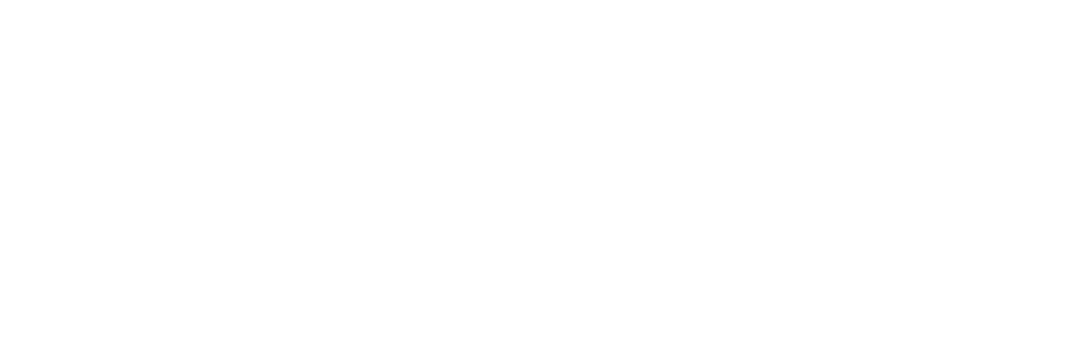

position_v_intensity_cycle_loci_3cycle_by_cond_roi00081


<IPython.core.display.Javascript object>


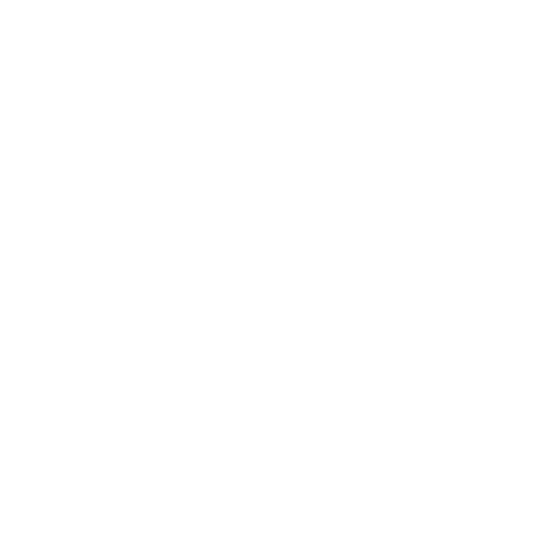

63
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


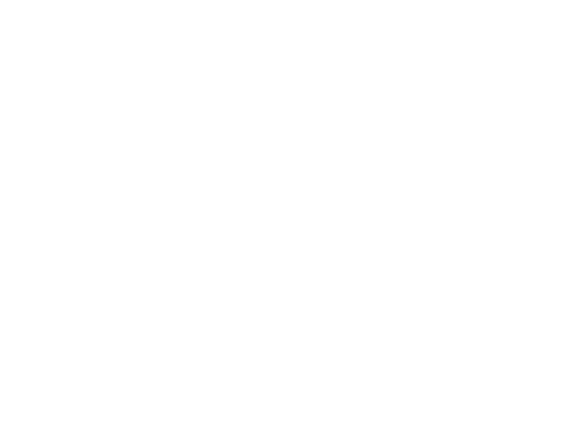

traces_by_cond_roi00064_lowpass4Hz


<IPython.core.display.Javascript object>


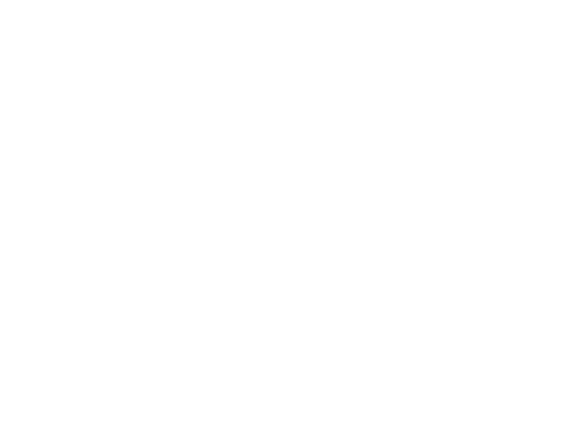

avg_3cycle_by_cond_roi00064


<IPython.core.display.Javascript object>


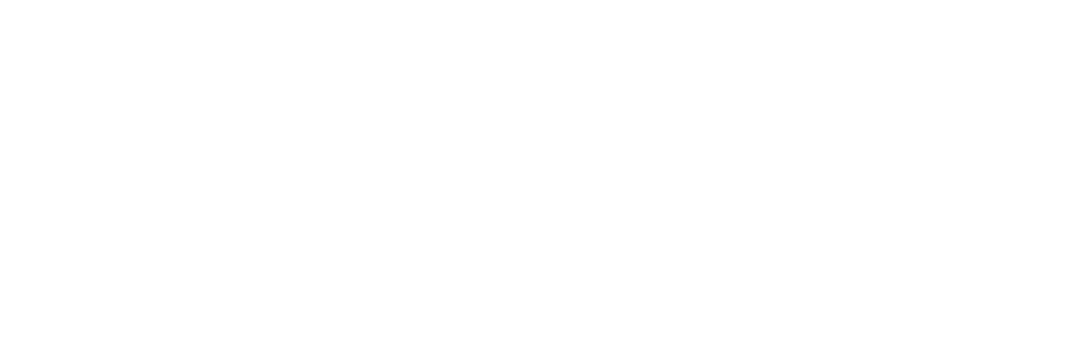

time_v_intensity_cycle_loci_3cycle_by_cond_roi00064
[top] Onset 18.48 deg (std 1.48). Peak @ -20.76 deg.
[right] Onset 38.23 deg (std 1.71). Peak @ 16.26 deg.
[bottom] Onset -15.08 deg (std 4.13). Peak @ 22.28 deg.
[left] Onset 8.57 deg (std 2.87). Peak @ 41.12 deg.
Relative coords? False
Lin coords from phase x, y = (22.27, 1.21)
ROI 64 - summary - 
Phase coords (x, y): (22.27, 1.21)
Left/Right edges: [8.57, 38.23]
--> left onsets: [  6.11598045  12.59339382   6.98579781]
--> right onsets: [ 35.81077671  39.44306635  39.44310358]
Bottom/Top edges: [-15.08, 18.48]
--> top onsets: [ 17.89649268  20.50276163  17.02989345]
--> bottom onsets: [-20.79491886 -11.15574709 -13.29156375]


<IPython.core.display.Javascript object>


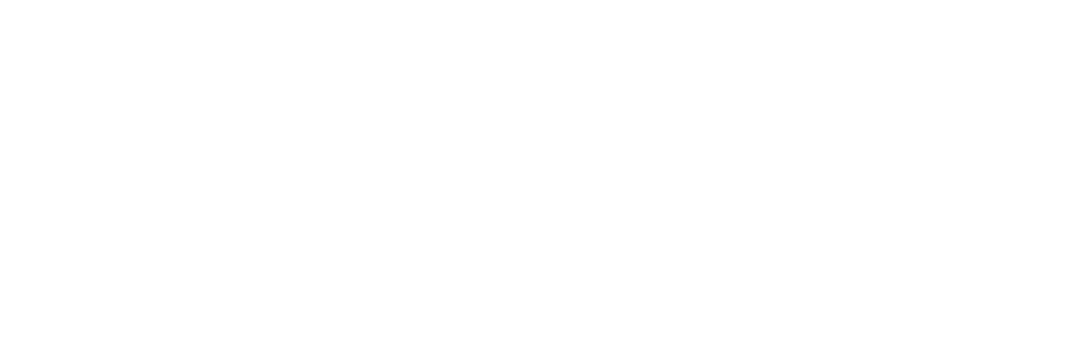

position_v_intensity_cycle_loci_3cycle_by_cond_roi00064


<IPython.core.display.Javascript object>


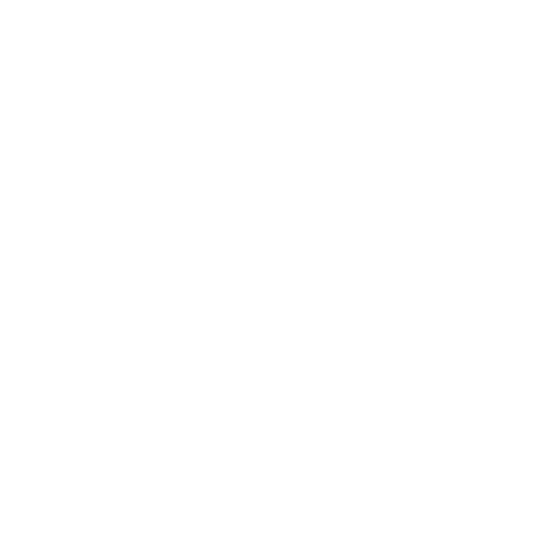

26
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


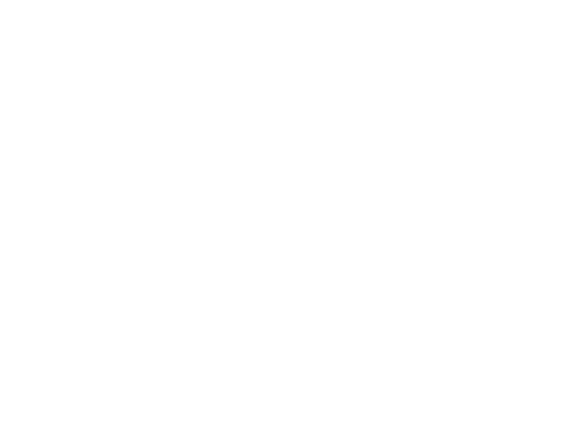

traces_by_cond_roi00027_lowpass4Hz


<IPython.core.display.Javascript object>


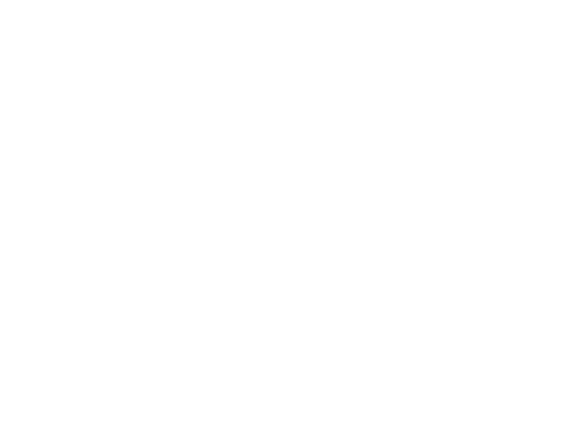

avg_3cycle_by_cond_roi00027


<IPython.core.display.Javascript object>


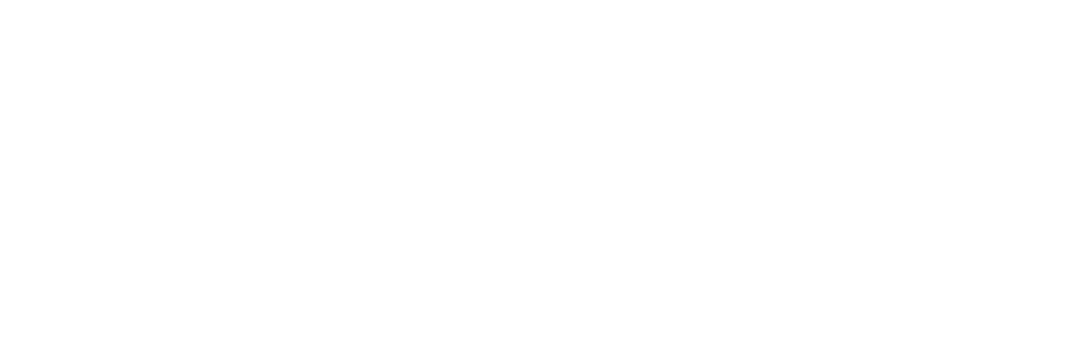

time_v_intensity_cycle_loci_3cycle_by_cond_roi00027
[top] Onset 40.27 deg (std 3.05). Peak @ 24.17 deg.
[right] Onset 42.06 deg (std 1.38). Peak @ 40.10 deg.
[bottom] Onset -36.07 deg (std 5.34). Peak @ -19.97 deg.
[left] Onset -37.78 deg (std 1.59). Peak @ -11.36 deg.
Relative coords? False
Lin coords from phase x, y = (-18.80, 0.21)
ROI 27 - summary - 
Phase coords (x, y): (-18.80, 0.21)
Left/Right edges: [-37.78, 42.06]
--> left onsets: [-36.31230513 -39.98257096 -37.04418233]
--> right onsets: [ 40.34510387  42.10963036  43.71525574]
Bottom/Top edges: [-36.07, 40.27]
--> top onsets: [ 36.3041996   40.7857641   43.71525574]
--> bottom onsets: [-28.52902319 -39.4480635  -40.24140016]


<IPython.core.display.Javascript object>


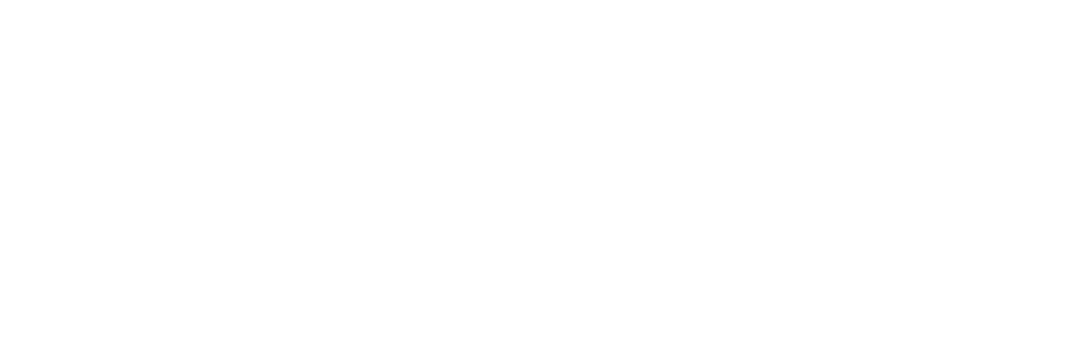

position_v_intensity_cycle_loci_3cycle_by_cond_roi00027


<IPython.core.display.Javascript object>


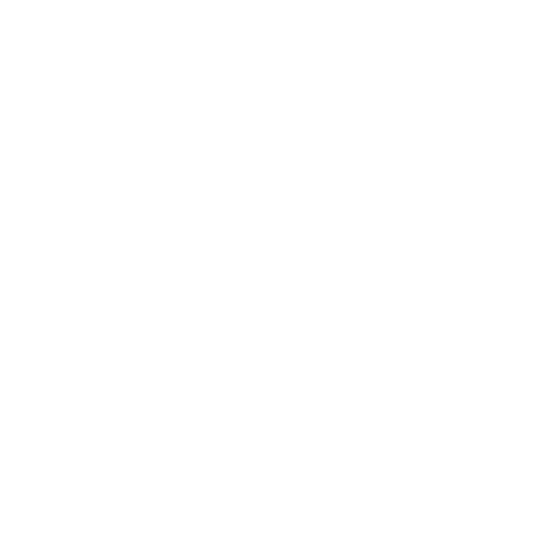

83
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


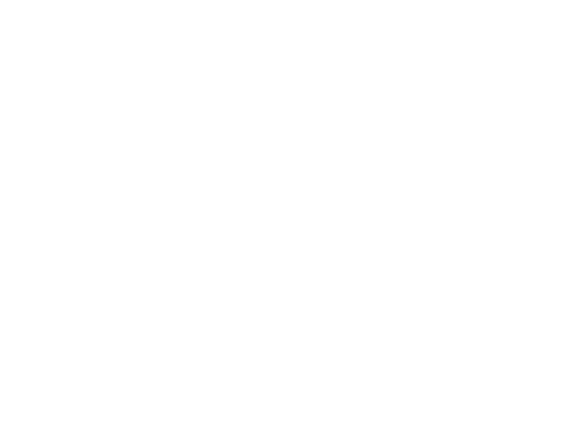

traces_by_cond_roi00084_lowpass4Hz


<IPython.core.display.Javascript object>


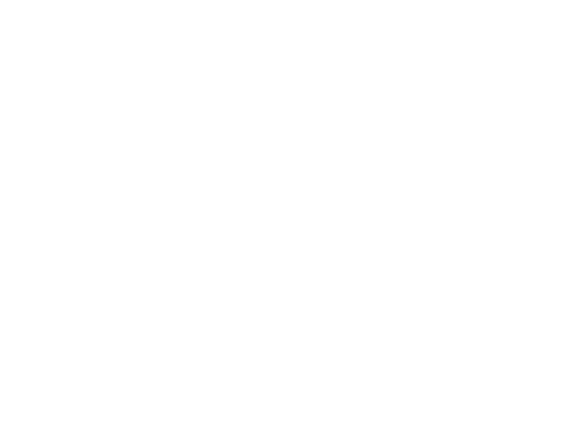

avg_3cycle_by_cond_roi00084


<IPython.core.display.Javascript object>


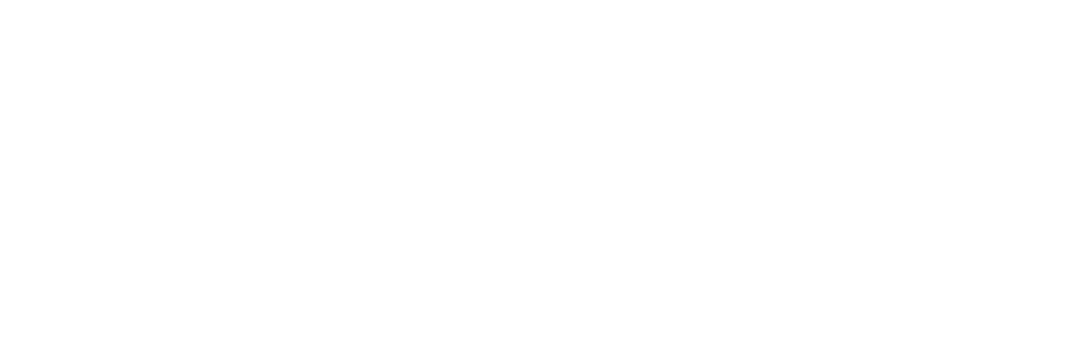

time_v_intensity_cycle_loci_3cycle_by_cond_roi00084
[top] Onset 21.59 deg (std 2.05). Peak @ 3.80 deg.
[right] Onset 39.48 deg (std 2.79). Peak @ 34.67 deg.
[bottom] Onset -17.04 deg (std 0.57). Peak @ 23.00 deg.
[left] Onset 11.14 deg (std 1.02). Peak @ 41.30 deg.
Relative coords? False
Lin coords from phase x, y = (18.89, -4.04)
ROI 84 - summary - 
Phase coords (x, y): (18.89, -4.04)
Left/Right edges: [11.14, 39.48]
--> left onsets: [ 10.38652973  12.59339382  10.45500747]
--> right onsets: [ 36.07849328  39.44306635  42.91454546]
Bottom/Top edges: [-17.04, 21.59]
--> top onsets: [ 19.23053102  21.30536125  24.2349212 ]
--> bottom onsets: [-16.79234805 -17.82472809 -16.49833576]


<IPython.core.display.Javascript object>


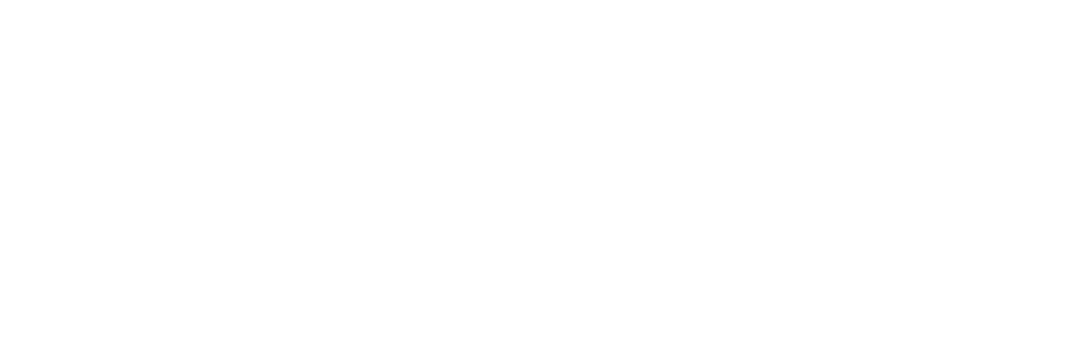

position_v_intensity_cycle_loci_3cycle_by_cond_roi00084


<IPython.core.display.Javascript object>


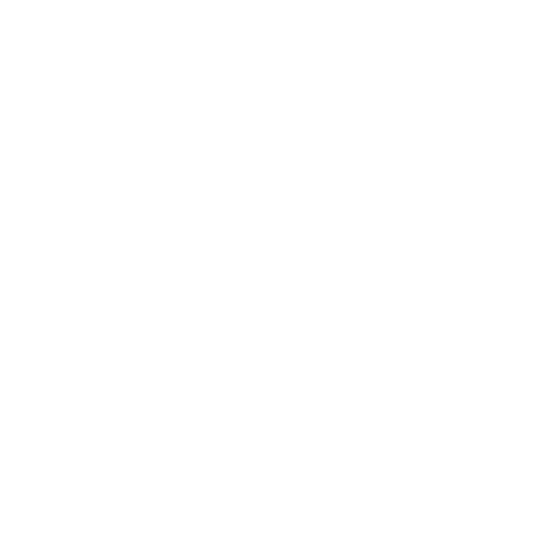

53
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


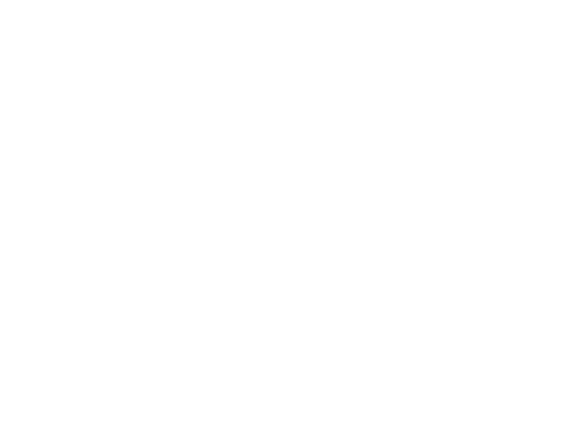

traces_by_cond_roi00054_lowpass4Hz


<IPython.core.display.Javascript object>


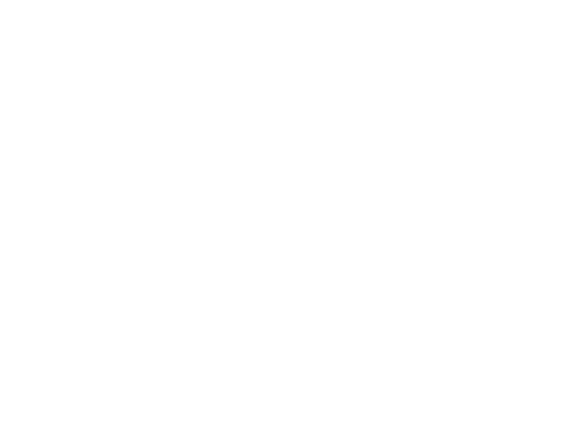

avg_3cycle_by_cond_roi00054


<IPython.core.display.Javascript object>


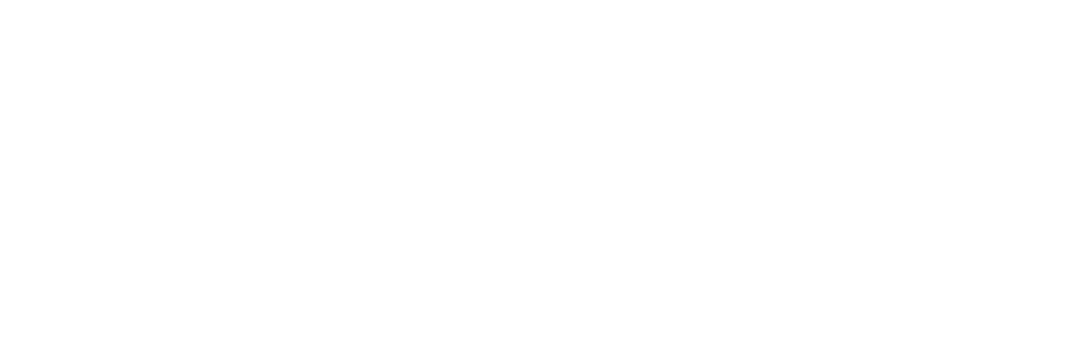

time_v_intensity_cycle_loci_3cycle_by_cond_roi00054
[top] Onset 12.88 deg (std 0.16). Peak @ 3.44 deg.
[right] Onset 24.71 deg (std 1.50). Peak @ 4.52 deg.
[bottom] Onset 2.62 deg (std 1.60). Peak @ 22.64 deg.
[left] Onset 10.34 deg (std 0.16). Peak @ 31.61 deg.
Relative coords? False
Lin coords from phase x, y = (-16.35, -6.17)
ROI 54 - summary - 
Phase coords (x, y): (-16.35, -6.17)
Left/Right edges: [10.34, 24.71]
--> left onsets: [ 10.12110976  10.45577967  10.45500747]
--> right onsets: [ 26.73854221  24.22776912  23.16509494]
Bottom/Top edges: [2.62, 12.88]
--> top onsets: [ 13.0961706   12.76758055  12.76473371]
--> bottom onsets: [ 4.83157974  1.92351314  1.1159861 ]


<IPython.core.display.Javascript object>


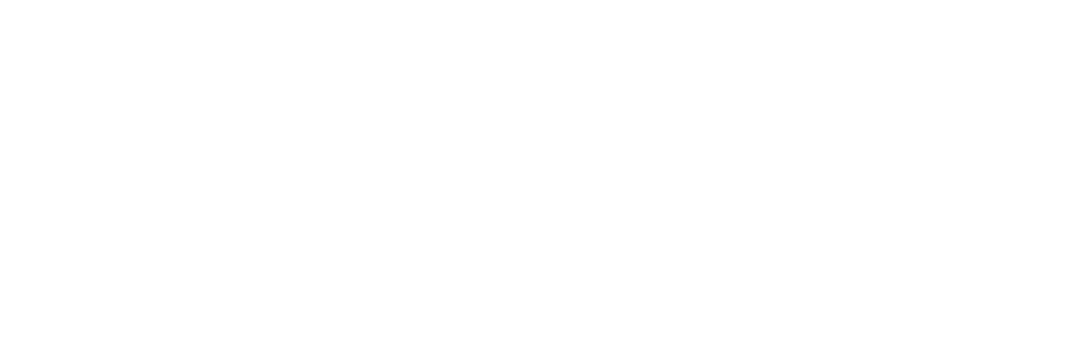

position_v_intensity_cycle_loci_3cycle_by_cond_roi00054


<IPython.core.display.Javascript object>


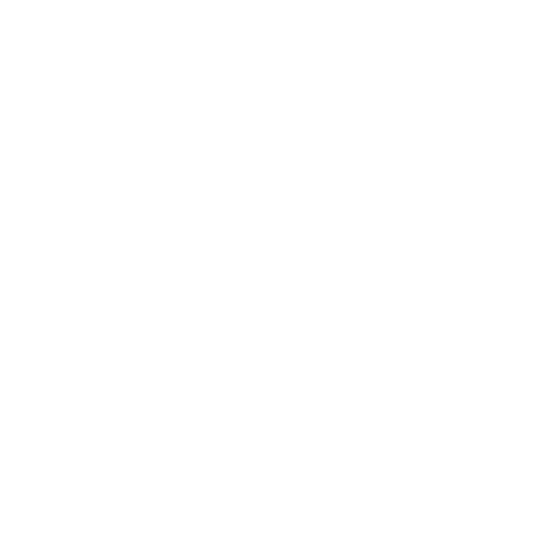

46
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


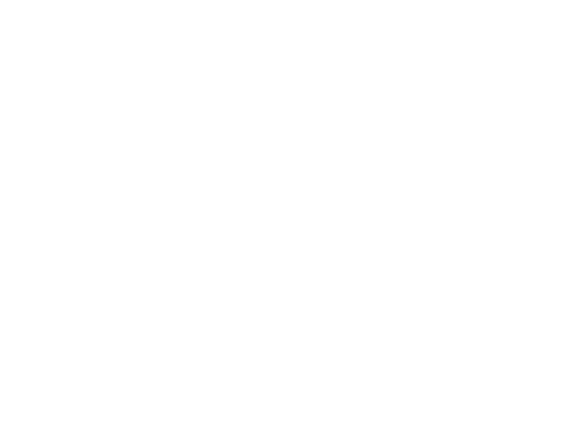

traces_by_cond_roi00047_lowpass4Hz


<IPython.core.display.Javascript object>


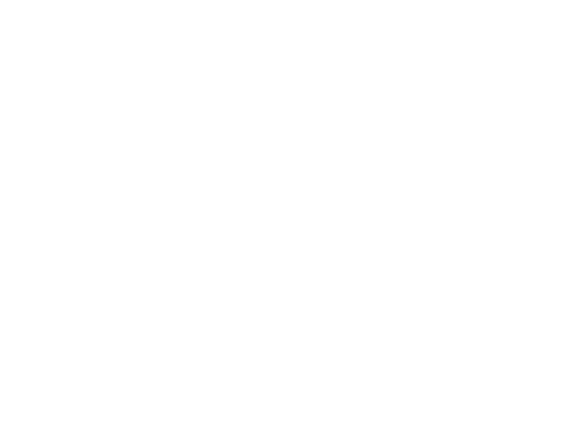

avg_3cycle_by_cond_roi00047


<IPython.core.display.Javascript object>


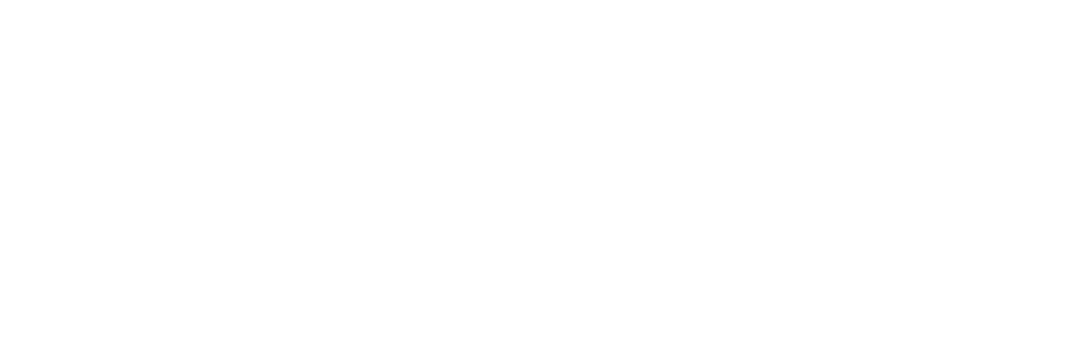

time_v_intensity_cycle_loci_3cycle_by_cond_roi00047
[top] Onset 23.72 deg (std 2.43). Peak @ -2.96 deg.
[right] Onset 33.87 deg (std 3.40). Peak @ 12.52 deg.
[bottom] Onset -15.70 deg (std 14.18). Peak @ 12.59 deg.
[left] Onset 9.19 deg (std 0.65). Peak @ 24.76 deg.
Relative coords? False
Lin coords from phase x, y = (27.86, -0.26)
ROI 47 - summary - 
Phase coords (x, y): (27.86, -0.26)
Left/Right edges: [9.19, 33.87]
--> left onsets: [ 9.85820465  9.39236703  8.31749314]
--> right onsets: [ 32.07360923  38.63786839  30.90348698]
Bottom/Top edges: [-15.70, 23.72]
--> top onsets: [ 24.29907906  26.37325678  20.49462993]
--> bottom onsets: [ -0.50901769 -11.95437417 -34.64038361]


<IPython.core.display.Javascript object>


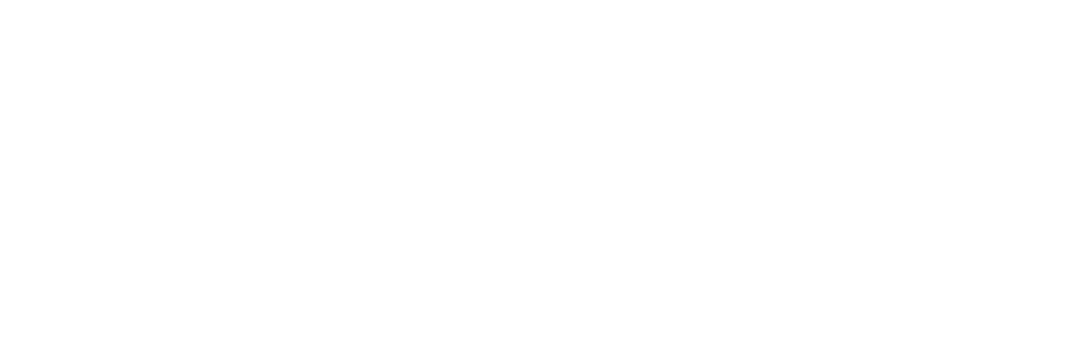

position_v_intensity_cycle_loci_3cycle_by_cond_roi00047


<IPython.core.display.Javascript object>


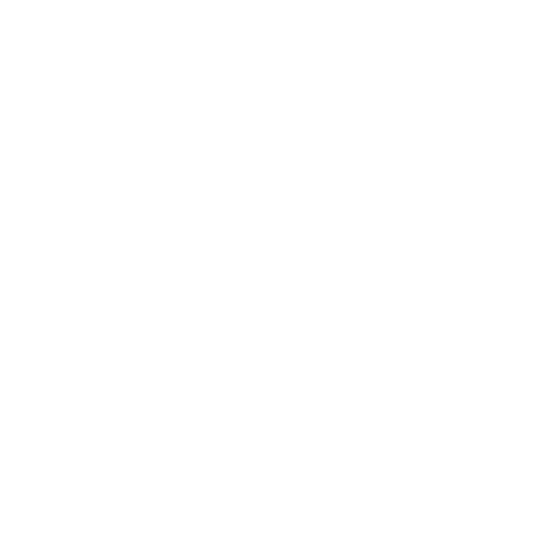

19
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


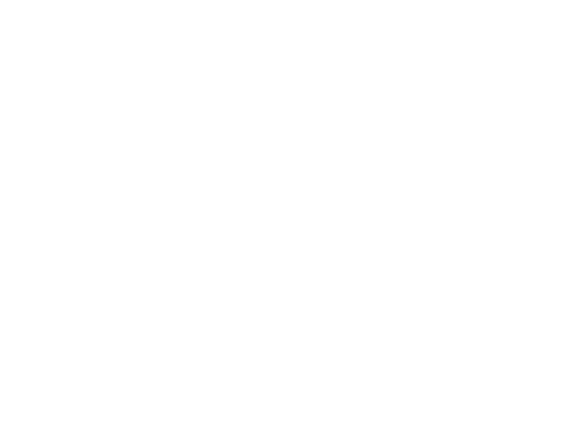

traces_by_cond_roi00020_lowpass4Hz


<IPython.core.display.Javascript object>


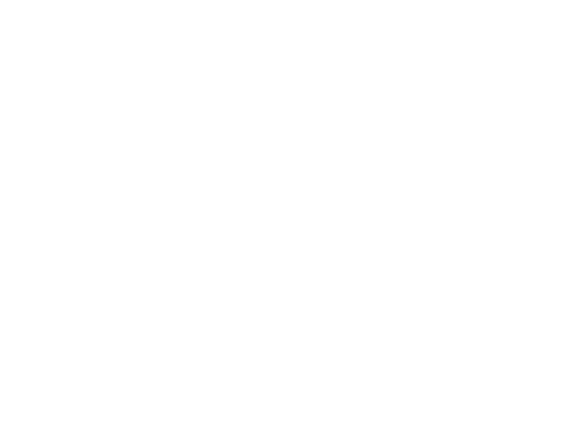

avg_3cycle_by_cond_roi00020


<IPython.core.display.Javascript object>


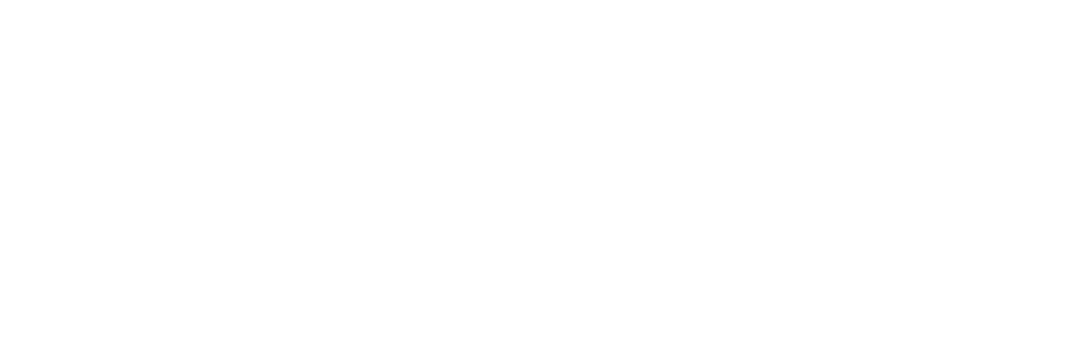

time_v_intensity_cycle_loci_3cycle_by_cond_roi00020
[top] Onset 16.69 deg (std 5.89). Peak @ 3.09 deg.
[right] Onset 36.28 deg (std 2.60). Peak @ 14.30 deg.
[bottom] Onset -1.91 deg (std 0.70). Peak @ 21.39 deg.
[left] Onset 3.94 deg (std 8.02). Peak @ 28.94 deg.
Relative coords? False
Lin coords from phase x, y = (24.52, -7.73)
ROI 20 - summary - 
Phase coords (x, y): (24.52, -7.73)
Left/Right edges: [3.94, 36.28]
--> left onsets: [ -6.42319031  13.12613408   5.11402487]
--> right onsets: [ 32.60751993  38.37627867  37.84248492]
Bottom/Top edges: [-1.91, 16.69]
--> top onsets: [ 17.09090111  23.70468989   9.28443739]
--> bottom onsets: [-1.57531329 -1.27653563 -2.88891501]


<IPython.core.display.Javascript object>


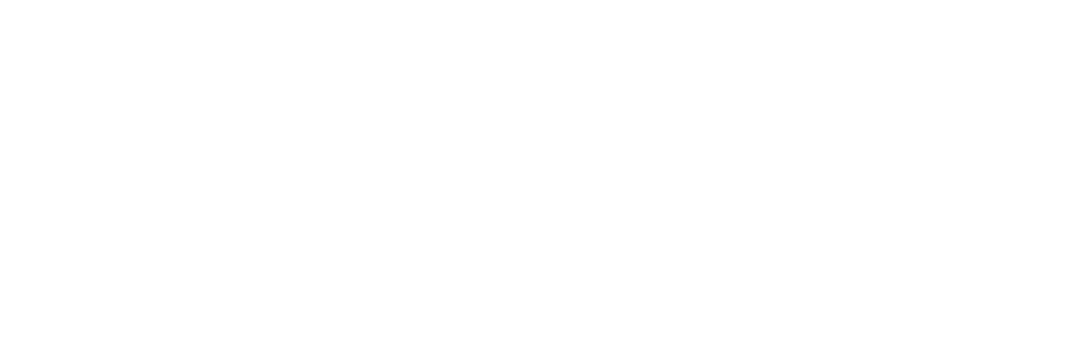

position_v_intensity_cycle_loci_3cycle_by_cond_roi00020


<IPython.core.display.Javascript object>


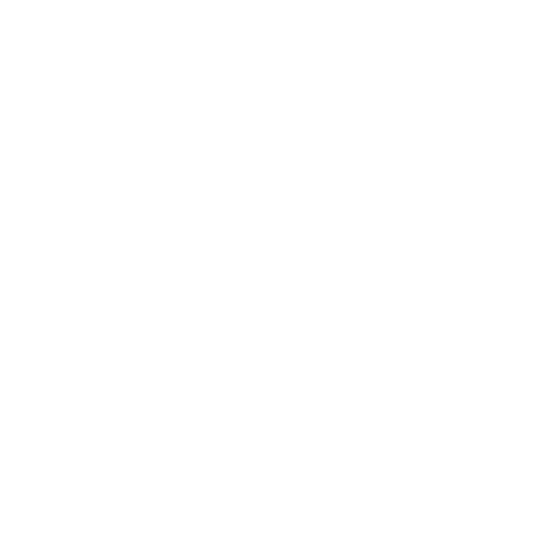

97
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


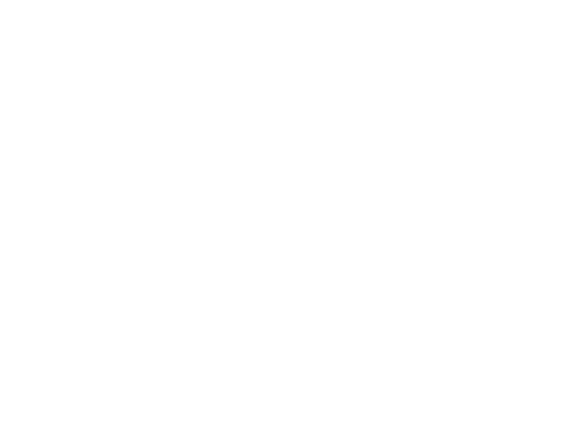

traces_by_cond_roi00098_lowpass4Hz


<IPython.core.display.Javascript object>


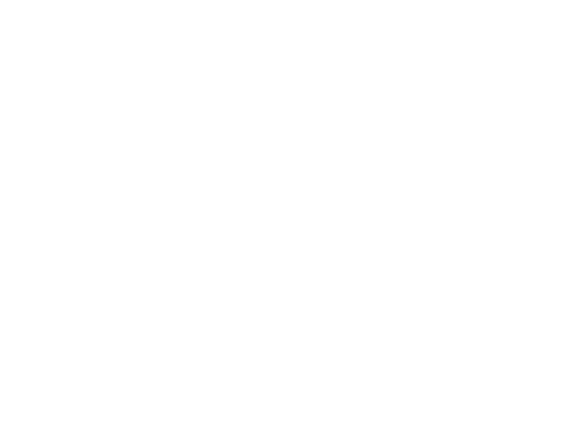

avg_3cycle_by_cond_roi00098


<IPython.core.display.Javascript object>


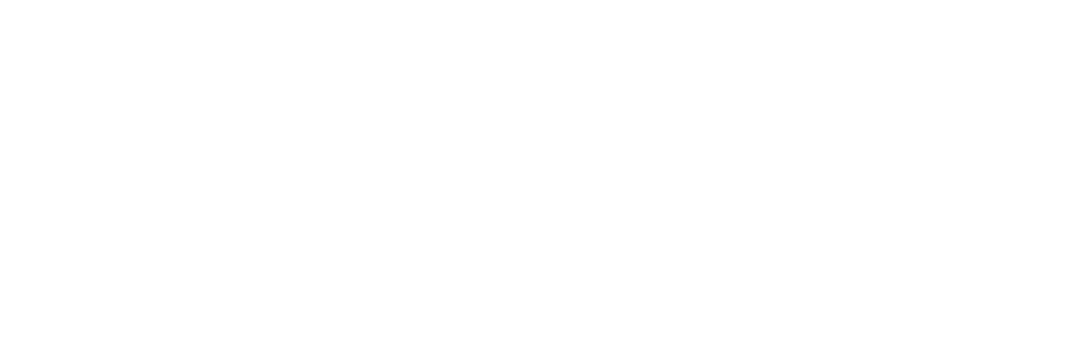

time_v_intensity_cycle_loci_3cycle_by_cond_roi00098
[top] Onset 36.09 deg (std 5.92). Peak @ 28.35 deg.
[right] Onset 11.90 deg (std 18.24). Peak @ -13.72 deg.
[bottom] Onset -22.01 deg (std 30.51). Peak @ -13.03 deg.
[left] Onset -32.27 deg (std 4.59). Peak @ -8.51 deg.
Relative coords? False
Lin coords from phase x, y = (-23.46, 3.44)
ROI 98 - summary - 
Phase coords (x, y): (-23.46, 3.44)
Left/Right edges: [-32.27, 11.90]
--> left onsets: [-34.71050527 -25.8366471  -36.24855246]
--> right onsets: [ 37.67551907  -1.65650772  -0.32777135]
Bottom/Top edges: [-22.01, 36.09]
--> top onsets: [ 27.77355075  41.05829287  39.44994326]
--> bottom onsets: [-43.71525574  21.13768663 -43.45217156]


<IPython.core.display.Javascript object>


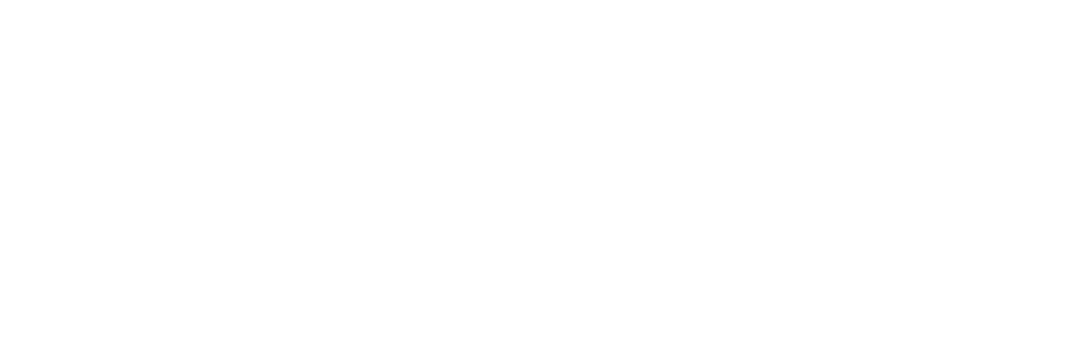

position_v_intensity_cycle_loci_3cycle_by_cond_roi00098


<IPython.core.display.Javascript object>


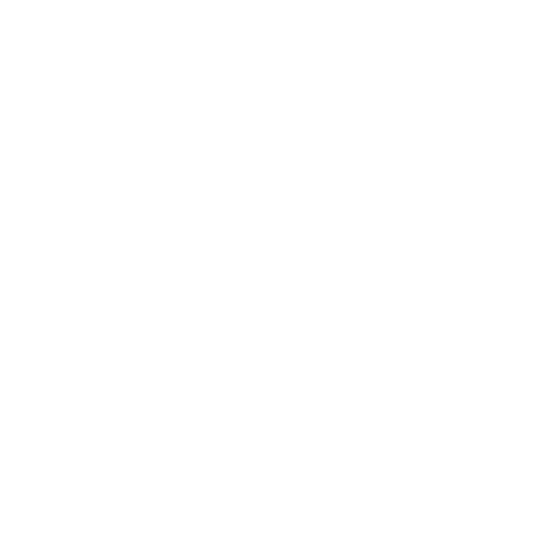

13
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


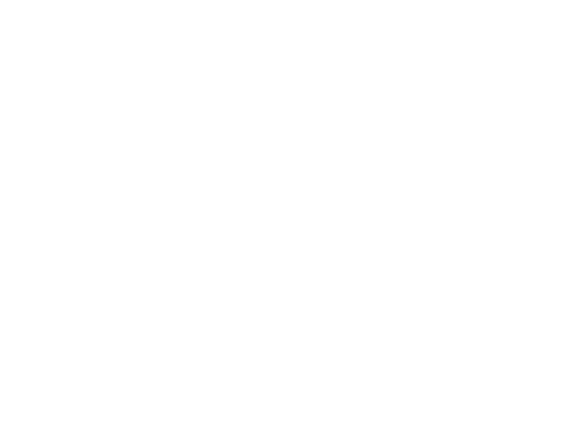

traces_by_cond_roi00014_lowpass4Hz


<IPython.core.display.Javascript object>


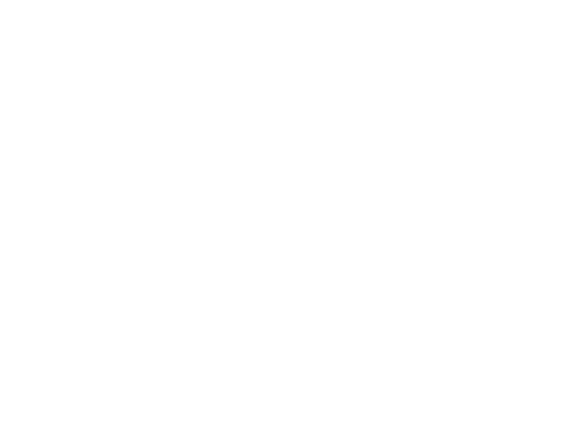

avg_3cycle_by_cond_roi00014


<IPython.core.display.Javascript object>


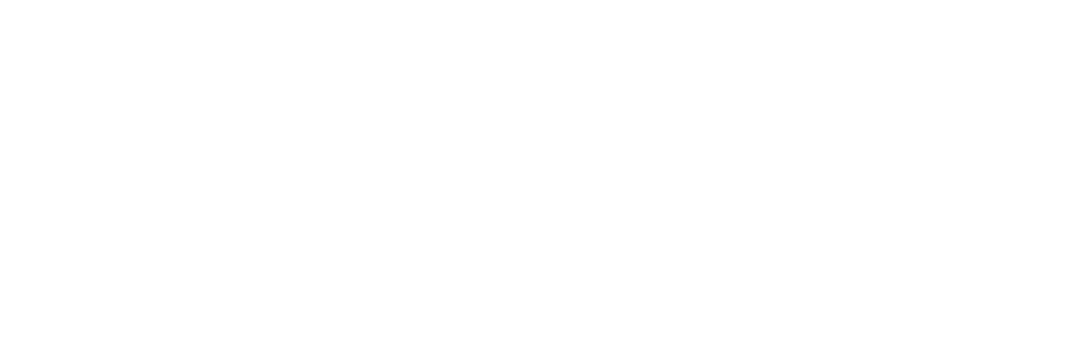

time_v_intensity_cycle_loci_3cycle_by_cond_roi00014
[top] Onset 24.53 deg (std 4.01). Peak @ 2.73 deg.
[right] Onset 36.63 deg (std 3.03). Peak @ 26.22 deg.
[bottom] Onset 0.13 deg (std 2.97). Peak @ 19.34 deg.
[left] Onset 4.74 deg (std 2.57). Peak @ 30.18 deg.
Relative coords? False
Lin coords from phase x, y = (22.03, 36.84)
ROI 14 - summary - 
Phase coords (x, y): (22.03, 36.84)
Left/Right edges: [4.74, 36.63]
--> left onsets: [ 2.38364561  8.32105083  3.5165955 ]
--> right onsets: [ 32.33827765  38.63786839  38.90653012]
Bottom/Top edges: [0.13, 24.53]
--> top onsets: [ 26.70201384  27.97895335  18.89639314]
--> bottom onsets: [-3.70965676  0.58824781  3.52477664]


<IPython.core.display.Javascript object>


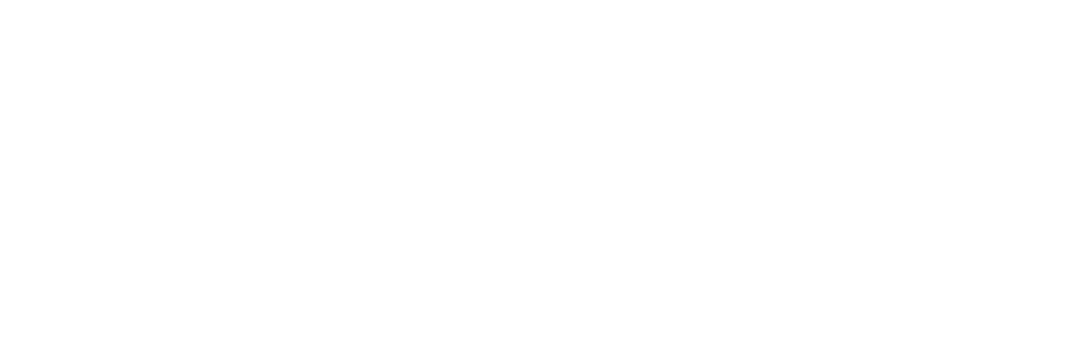

position_v_intensity_cycle_loci_3cycle_by_cond_roi00014


<IPython.core.display.Javascript object>


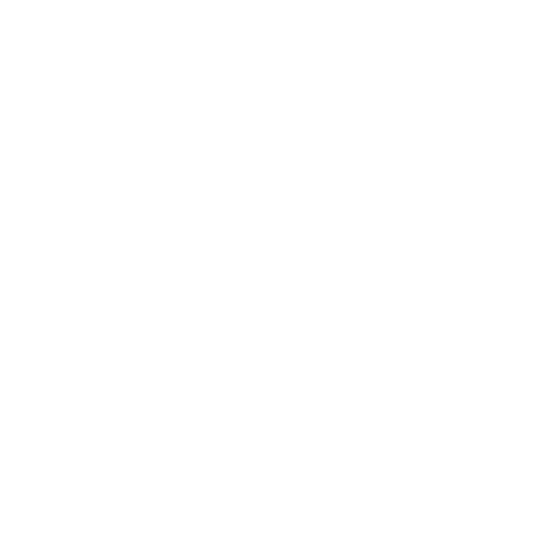

107
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


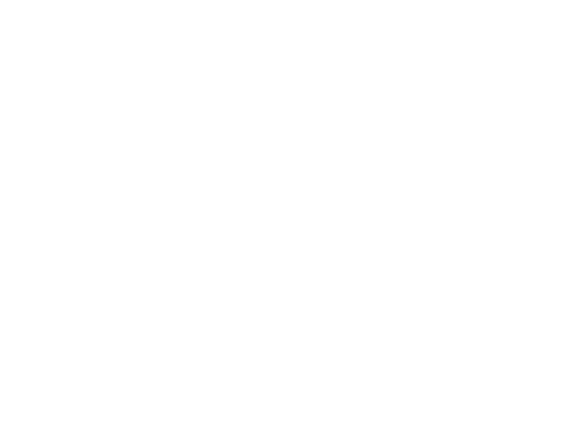

traces_by_cond_roi00108_lowpass4Hz


<IPython.core.display.Javascript object>


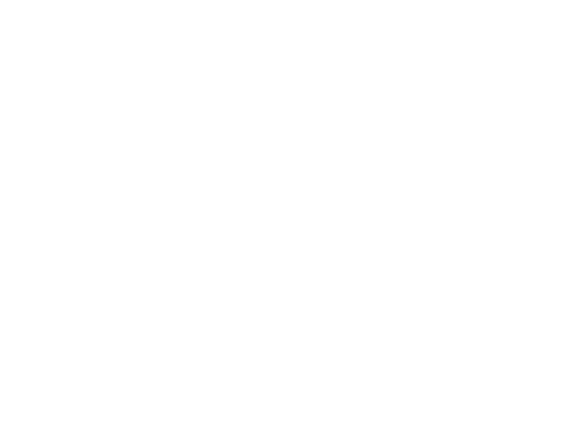

avg_3cycle_by_cond_roi00108


<IPython.core.display.Javascript object>


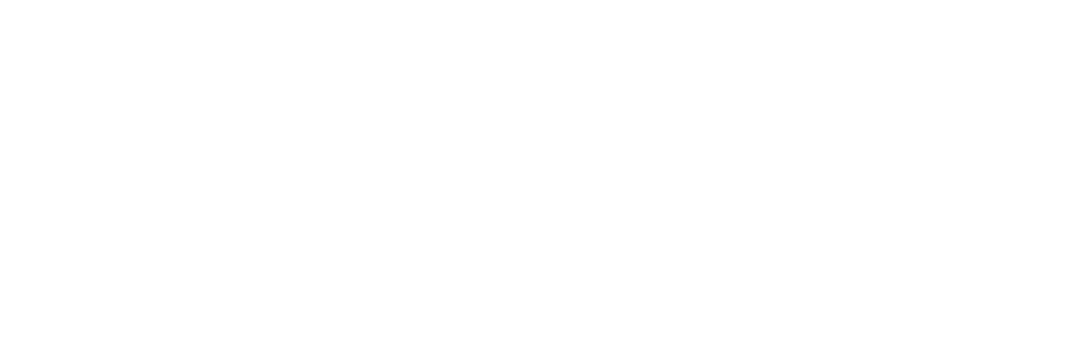

time_v_intensity_cycle_loci_3cycle_by_cond_roi00108
[top] Onset 40.54 deg (std 2.49). Peak @ 37.51 deg.
[right] Onset -10.52 deg (std 6.92). Peak @ -40.59 deg.
[bottom] Onset -11.70 deg (std 21.28). Peak @ -6.63 deg.
[left] Onset -26.31 deg (std 8.77). Peak @ -20.79 deg.
Relative coords? False
Lin coords from phase x, y = (-10.78, 1.73)
ROI 108 - summary - 
Phase coords (x, y): (-10.78, 1.73)
Left/Right edges: [-26.31, -10.52]
--> left onsets: [-36.58046565 -15.16037922 -27.17603945]
--> right onsets: [-19.69650168  -8.8658148   -2.99222688]
Bottom/Top edges: [-11.70, 40.54]
--> top onsets: [ 37.10639949  41.5868878   42.92252677]
--> bottom onsets: [ 18.17176097 -23.42904113 -29.83501184]


<IPython.core.display.Javascript object>


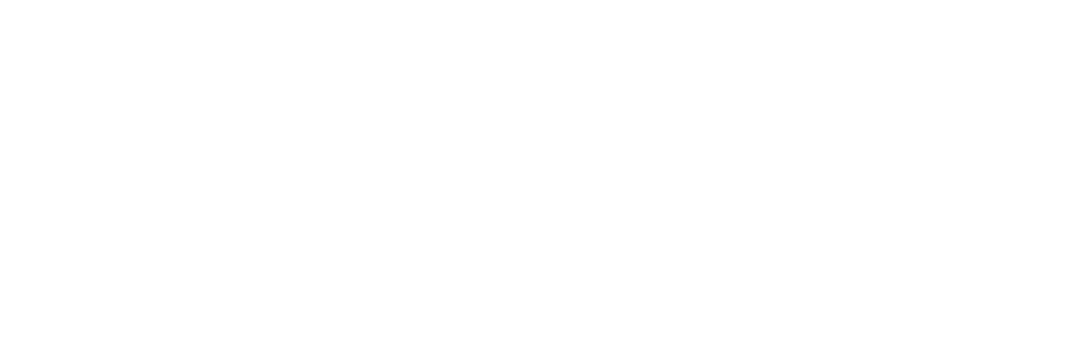

position_v_intensity_cycle_loci_3cycle_by_cond_roi00108


<IPython.core.display.Javascript object>


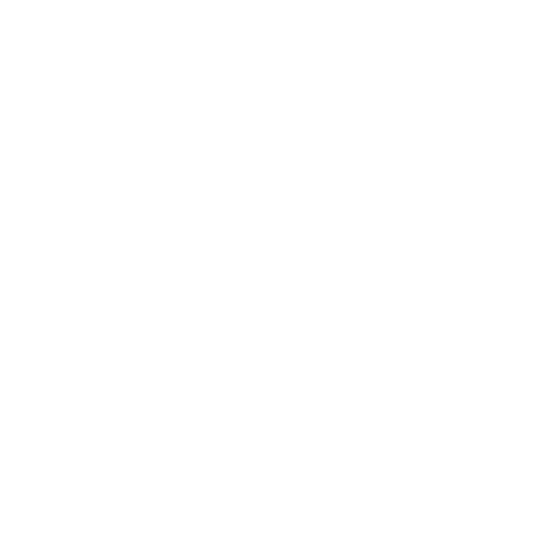

34
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


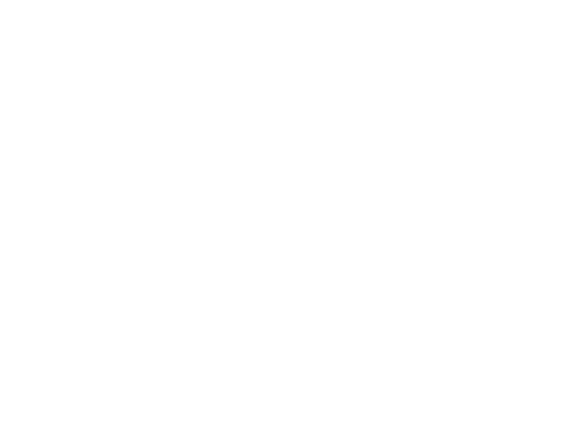

traces_by_cond_roi00035_lowpass4Hz


<IPython.core.display.Javascript object>


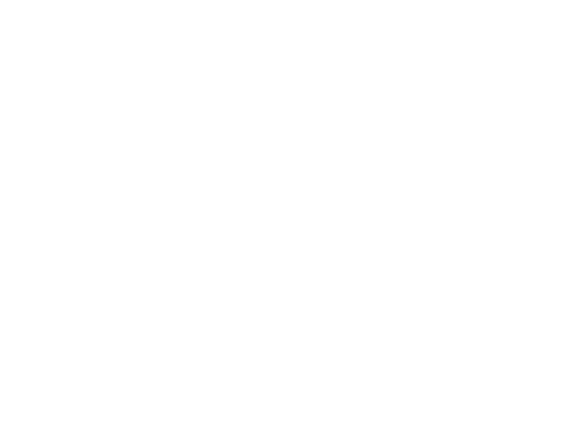

avg_3cycle_by_cond_roi00035


<IPython.core.display.Javascript object>


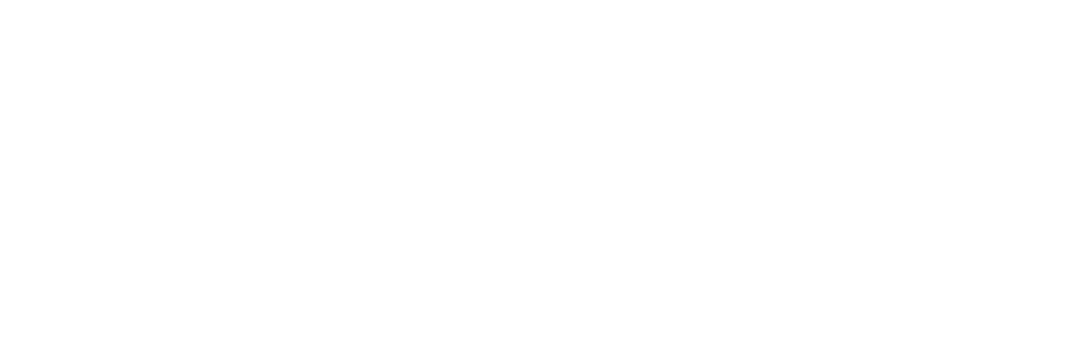

time_v_intensity_cycle_loci_3cycle_by_cond_roi00035
[top] Onset 22.39 deg (std 0.03). Peak @ 17.85 deg.
[right] Onset 37.79 deg (std 1.96). Peak @ 23.64 deg.
[bottom] Onset -24.16 deg (std 2.32). Peak @ -15.17 deg.
[left] Onset -12.87 deg (std 5.91). Peak @ 13.10 deg.
Relative coords? False
Lin coords from phase x, y = (28.64, 0.86)
ROI 35 - summary - 
Phase coords (x, y): (28.64, 0.86)
Left/Right edges: [-12.87, 37.79]
--> left onsets: [-20.03388327  -5.54945977 -13.03624793]
--> right onsets: [ 35.01001182  39.1729408   39.17853156]
Bottom/Top edges: [-24.16, 22.39]
--> top onsets: [ 22.4284537   22.36511526  22.36495703]
--> bottom onsets: [-22.39872042 -27.43515451 -22.63123277]


<IPython.core.display.Javascript object>


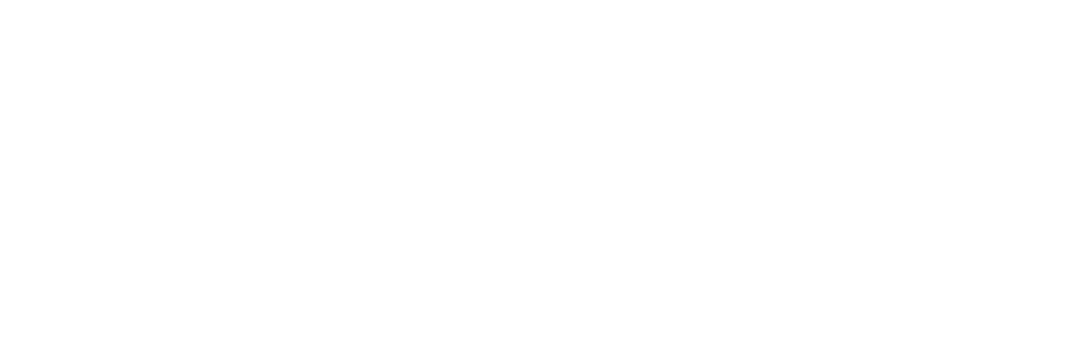

position_v_intensity_cycle_loci_3cycle_by_cond_roi00035


<IPython.core.display.Javascript object>


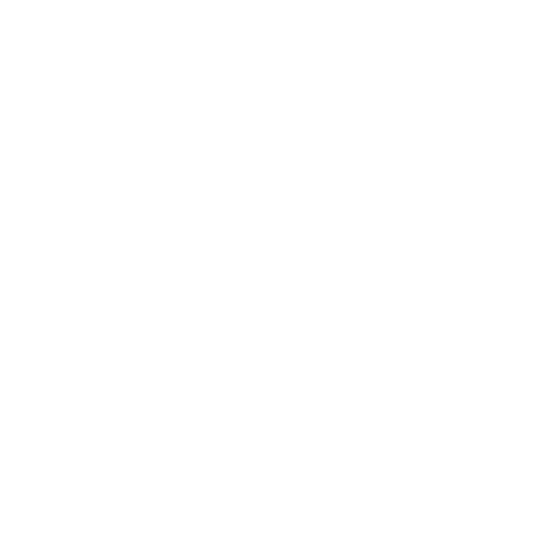

65
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


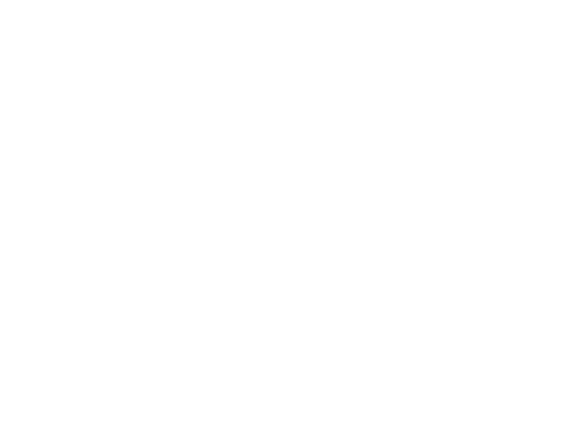

traces_by_cond_roi00066_lowpass4Hz


<IPython.core.display.Javascript object>


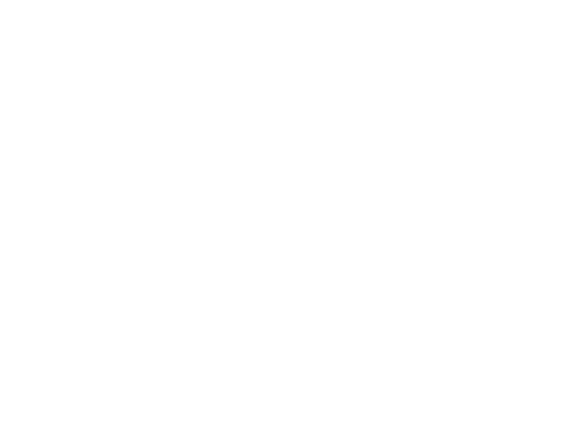

avg_3cycle_by_cond_roi00066
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...


<IPython.core.display.Javascript object>


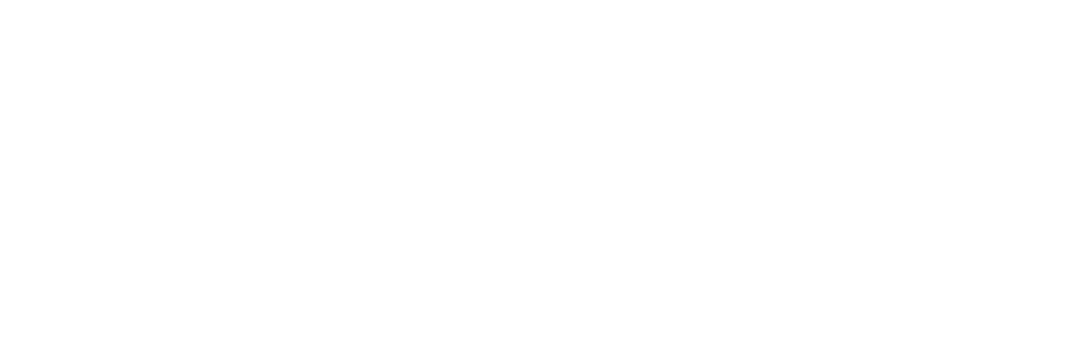

time_v_intensity_cycle_loci_3cycle_by_cond_roi00066
[top] Onset 36.18 deg (std 4.80). Peak @ 32.71 deg.
[right] Onset 2.11 deg (std 3.72). Peak @ -44.32 deg.
[bottom] Onset -25.93 deg (std 3.72). Peak @ -22.73 deg.
[left] Onset -39.56 deg (std 2.30). Peak @ -9.67 deg.
Relative coords? False
Lin coords from phase x, y = (-20.80, -0.94)
ROI 66 - summary - 
Phase coords (x, y): (-20.80, -0.94)
Left/Right edges: [-39.56, 2.11]
--> left onsets: [-36.31230513 -41.04908242 -41.31862733]
--> right onsets: [ 1.64336421  6.88136508 -2.18908275]
Bottom/Top edges: [-25.93, 36.18]
--> top onsets: [ 29.64273253  37.846893    41.05126614]
--> bottom onsets: [-22.92827421 -23.70203293 -31.16967847]


<IPython.core.display.Javascript object>


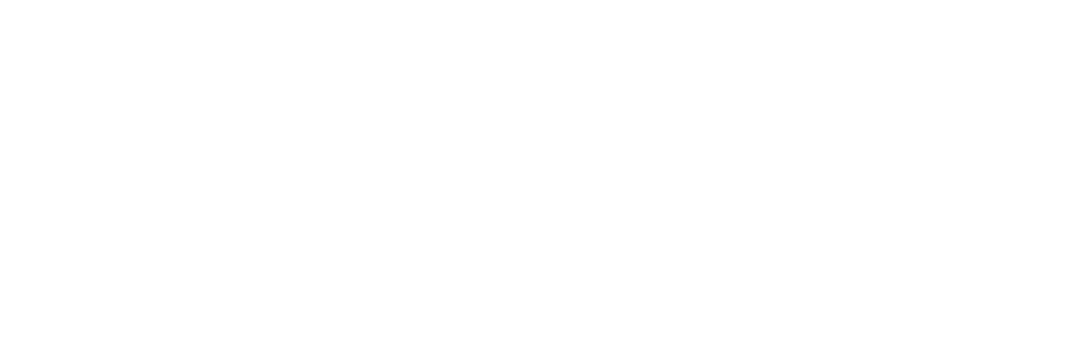

position_v_intensity_cycle_loci_3cycle_by_cond_roi00066


<IPython.core.display.Javascript object>


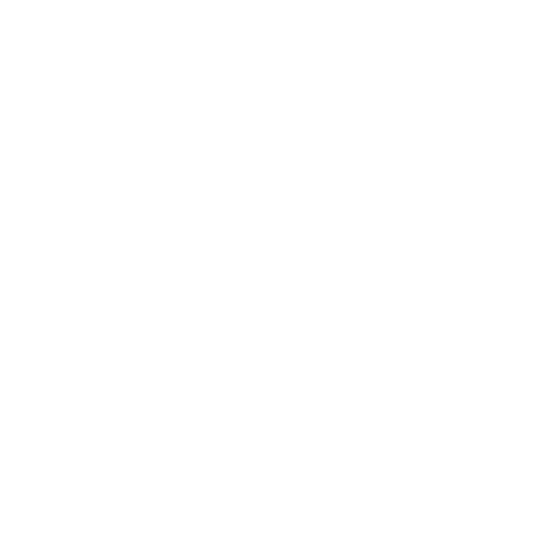

5
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


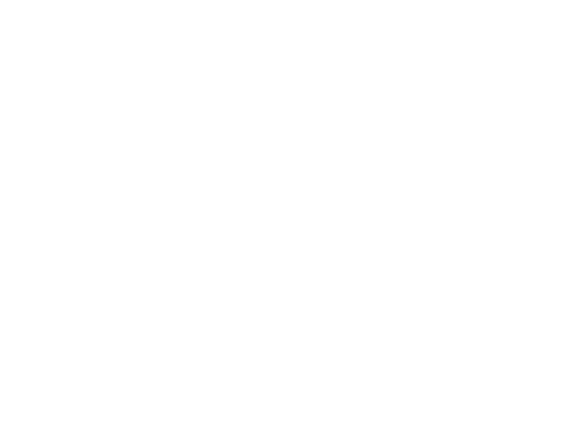

traces_by_cond_roi00006_lowpass4Hz


<IPython.core.display.Javascript object>


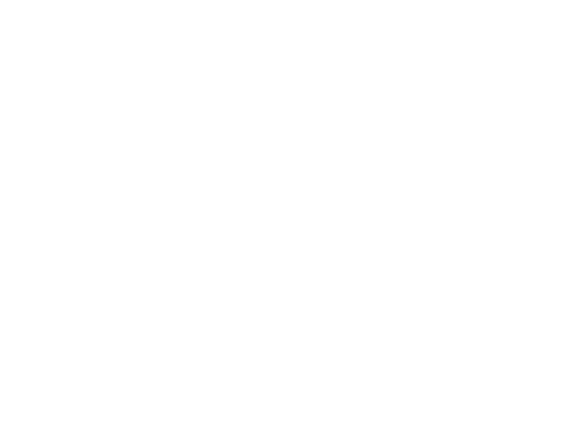

avg_3cycle_by_cond_roi00006
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new 

<IPython.core.display.Javascript object>


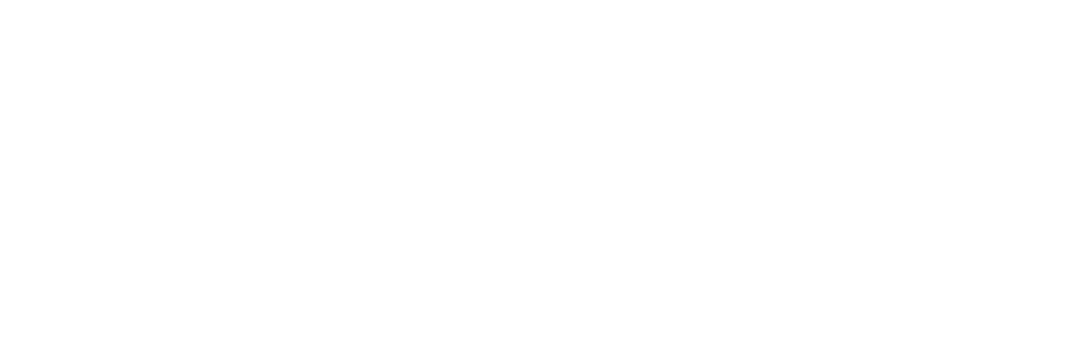

time_v_intensity_cycle_loci_3cycle_by_cond_roi00006
[top] Onset -2.08 deg (std 27.85). Peak @ -20.13 deg.
[right] Onset 27.73 deg (std 19.09). Peak @ 19.91 deg.
[bottom] Onset -40.70 deg (std 2.28). Peak @ -39.54 deg.
[left] Onset -41.07 deg (std 3.19). Peak @ -16.52 deg.
Relative coords? False
Lin coords from phase x, y = (-20.53, -0.84)
ROI 6 - summary - 
Phase coords (x, y): (-20.53, -0.84)
Left/Right edges: [-41.07, 27.73]
--> left onsets: [-36.58046565 -42.91898454 -43.71525574]
--> right onsets: [ 40.88095624   0.7417303   41.57850469]
Bottom/Top edges: [-40.70, -2.08]
--> top onsets: [-21.86976986 -21.66257005  37.30685536]
--> bottom onsets: [-37.87468835 -43.44676457 -40.77914536]


<IPython.core.display.Javascript object>


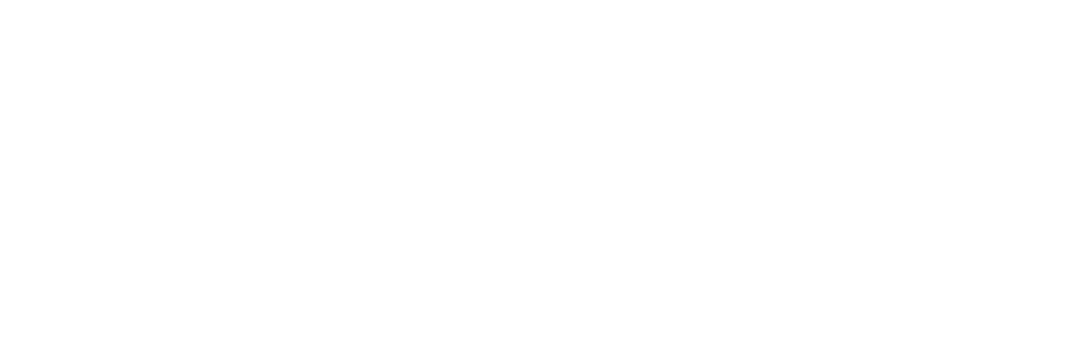

position_v_intensity_cycle_loci_3cycle_by_cond_roi00006


<IPython.core.display.Javascript object>


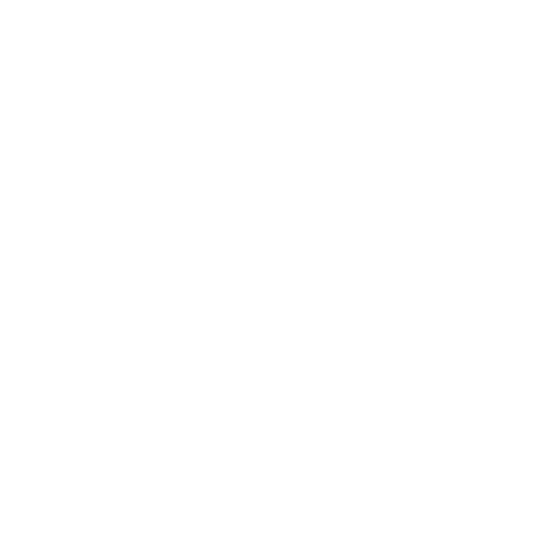

100
top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


<IPython.core.display.Javascript object>


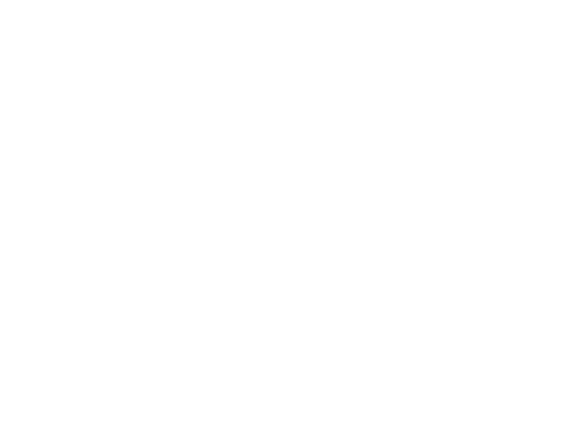

traces_by_cond_roi00101_lowpass4Hz


<IPython.core.display.Javascript object>


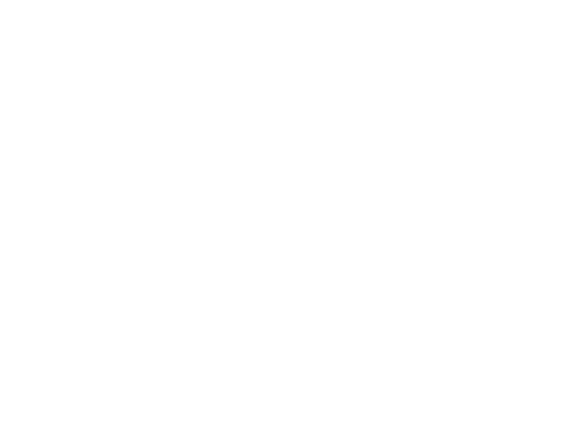

avg_3cycle_by_cond_roi00101


<IPython.core.display.Javascript object>


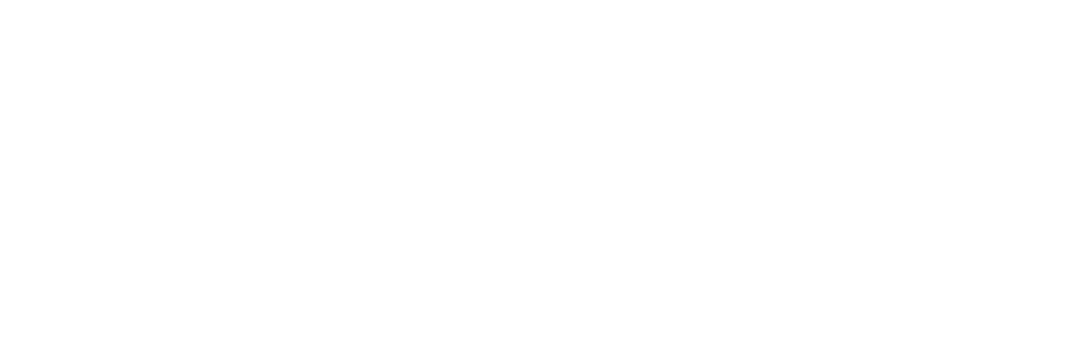

time_v_intensity_cycle_loci_3cycle_by_cond_roi00101
[top] Onset 17.32 deg (std 0.94). Peak @ 8.69 deg.
[right] Onset 5.14 deg (std 1.87). Peak @ -19.50 deg.
[bottom] Onset -1.56 deg (std 29.70). Peak @ 5.82 deg.
[left] Onset -31.29 deg (std 2.82). Peak @ 2.60 deg.
Relative coords? False
Lin coords from phase x, y = (14.00, 22.43)
ROI 101 - summary - 
Phase coords (x, y): (14.00, 22.43)
Left/Right edges: [-31.29, 5.14]
--> left onsets: [-32.30816621 -34.11173595 -27.44289663]
--> right onsets: [ 3.25191084  4.47584572  7.68176591]
Bottom/Top edges: [-1.56, 17.32]
--> top onsets: [ 16.8276448   16.50139099  18.63664806]
--> bottom onsets: [ 16.83644232  21.9377841  -43.45217156]


<IPython.core.display.Javascript object>


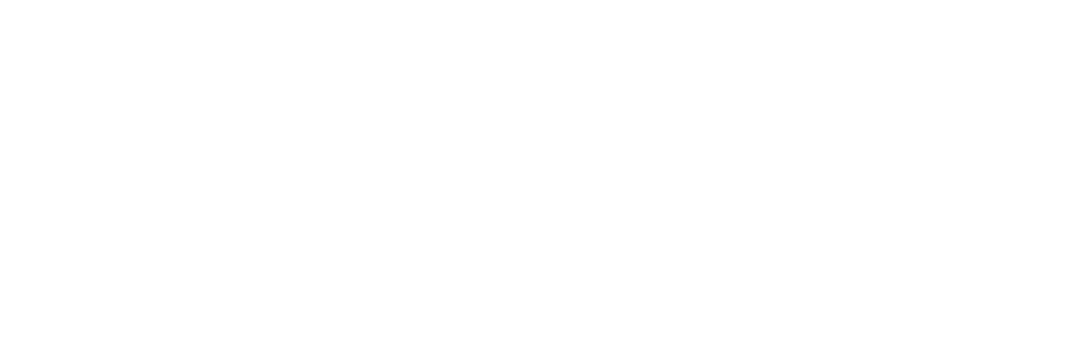

position_v_intensity_cycle_loci_3cycle_by_cond_roi00101


<IPython.core.display.Javascript object>


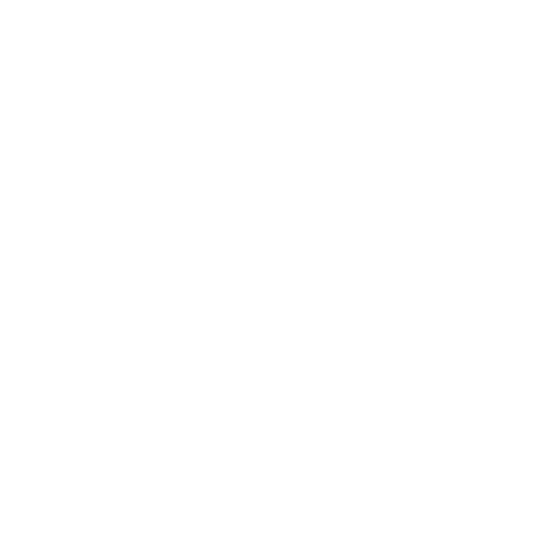

IOError: [Errno 2] No such file or directory: u'/n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/rf_estimates/20190404160119_select_top_magr_magthr_0.02_by_allconds_filter_lowpass_4Hz/ cyclesize3/rf_estimate_params.json'

In [69]:
#### Parse roi trace for each trial into N chunks

# Make output dirs for figures and results:
# -----------------------------------------------------------------------------------------------

roi_traces_dir = os.path.join(output_dir, 'traces_by_roi')
if not os.path.exists(roi_traces_dir):
    os.makedirs(roi_traces_dir)
    
parsed_cycles_dir = os.path.join(output_dir,'cyclesize%i' % chunksize, 'parsed_cycles_by_roi')
if not os.path.exists(parsed_cycles_dir):
    os.makedirs(parsed_cycles_dir)
print "Saving ROI figures to: %s" % parsed_cycles_dir

rf_estimates_dir = os.path.join(output_dir, 'cyclesize%i' % chunksize, 'estimates_by_roi')
if not os.path.exists(rf_estimates_dir):
    os.makedirs(rf_estimates_dir)
# -----------------------------------------------------------------------------------------------

fr_per_cyc = {}
parsing_results = {}
rf_results = {}
processing_results = {}
for rid in roi_list:
    print rid
    raw_traces= dict()
    for cond in trials_by_cond.keys():
        assert len(np.unique(np.diff(stiminfo[cond]['cycle_start_ixs']))) == 1, "Uneven cycle durs! %s" % str(stiminfo[cond]['cycle_start_ixs'])
        fr_per_cyc[cond] = np.unique(np.diff(stiminfo[cond]['cycle_start_ixs']))[0]
        raw_traces[cond] = np.array([extr_traces['File%03d' % f]['processed'][rid, :] \
                                     for f in trials_by_cond[cond]])
        print"%s:" % cond, raw_traces[cond].shape
        
    # Filter traces
    filt_traces = {}
    for cond in raw_traces.keys():
        filt_traces[cond] = np.empty(raw_traces[cond].shape, dtype=raw_traces[cond].dtype)
        for repnum in np.arange(0, raw_traces[cond].shape[0]):
            y = butter_lowpass_filter(raw_traces[cond][repnum,:], cutoff, fs, order)
            filt_traces[cond][repnum, :] = y

    if plot_each_condition:            
        fig, axes = pl.subplots(2,2, sharex=True, sharey=True) #, figsize=(8,))
        for aix, cond in enumerate(['left', 'right', 'bottom', 'top']):
            ax = axes.flat[aix]
            for repnum in np.arange(0, filt_traces[cond].shape[0]):
                ax.plot(filt_traces[cond][repnum, :], 'k', alpha=0.5, lw=0.5)
            filt_label = 'filtered' if aix==1 else None
            raw_label = 'raw' if aix==1 else None
            ax.plot(raw_traces[cond].mean(axis=0), 'g', alpha=1, linewidth=0.7, label=raw_label)
            ax.plot(filt_traces[cond].mean(axis=0), 'k', linewidth=0.7, label=filt_label)
            ax.set_title(cond)
            for cyc in stiminfo[cond]['cycle_start_ixs']:
                ax.axvline(x=cyc, color='k', linestyle='--', linewidth=0.5)
        fig.suptitle("roi %i - cutoff %.2f Hz" % (int(rid+1), cutoff))
        pl.subplots_adjust(hspace=0.3, top=0.8, left=0.06, right=0.8)
        axes.flat[1].legend(bbox_to_anchor=(1, 1))
        
        figname = 'traces_by_cond_roi%05d_lowpass%iHz' % (int(rid+1), cutoff) #%.2f'
        pl.savefig(os.path.join(roi_traces_dir, '%s.png' % figname))
        print figname
        pl.close()
    
    assert len(np.unique([nframes for cond, nframes in fr_per_cyc.items()])) == 1, "Uneven cycle durs across conditions! %s" % str(fr_per_cyc)
    nframes_total = np.unique([nframes for cond, nframes in fr_per_cyc.items()])[0] * stiminfo['right']['n_cycles']
    for cond in raw_traces.keys():
        curr_traces = copy.copy(raw_traces[cond])
        raw_traces[cond] = curr_traces[:, 0:nframes_total]
        curr_traces = copy.copy(filt_traces[cond])
        filt_traces[cond] = curr_traces[:, 0:nframes_total]
        
    #### Use FILTERED or "RAW" traces?
    if filter_traces:
        roi_traces = copy.copy(filt_traces)
    else:
        roi_traces = copy.copy(raw_traces)

    #### Get average N cycles and visualize chunked traces
    # -----------------------------------------------------------------------------------------------
    parsed_traces, parsed_cycle_ixs = get_parsed_cycles(rid, roi_traces, stiminfo, chunksize=chunksize)

    #### Plot averaged cycles by condition:    
    fig = plot_parsed_cycles_by_roi(parsed_traces, parsed_cycle_ixs)
    pl.suptitle('roi %i' % int(rid+1))
    label_figure(fig, data_identifier)
    figname = 'avg_%icycle_by_cond_roi%05d' % (chunksize, int(rid+1))
    pl.savefig(os.path.join(parsed_cycles_dir, '%s.png' % figname))
    print figname
    pl.close()

    #### Identify max, min, and "onset" frame in averaged trace
    # -----------------------------------------------------------------------------------------------
    loci = get_loci_from_averaged_cycle(parsed_traces, parsed_cycle_ixs, stiminfo, \
                                            nstds_above_baseline=nstds_above_baseline, window_nsecs=window_nsecs)

    processing_results[rid] = {'filter_traces': filter_traces,
                          'lowpass_cutoff': cutoff,
                          'filtered_traces': filt_traces,
                          'raw_traces': raw_traces}
    
    parsing_results[rid] = {'parsed_traces': parsed_traces,
                            'parsed_cycle_ixs': parsed_cycle_ixs,
                            'chunksize': chunksize,
                            'roi_traces': roi_traces,
                            'loci': loci}
    
    #### Plot averaged mini-trace, with key loci:
    if any([cond_loci is None for cond, cond_loci in loci.items()]):
        print "*** BAD FITS: roi %i" % int(rid+1)
        bad_conds = [cond for cond, cond_loci in loci.items() if cond_loci is None]
        for cond in bad_conds:
            print "Unable to fit cond: %s" % cond
        continue
        
    fig = plot_loci_from_averaged_cycle(parsed_traces, parsed_cycle_ixs, loci) #, averaged_=None)
    fig.suptitle('roi %i (%i chunks)' % (int(rid+1), chunksize))
    pl.subplots_adjust(wspace=0.2, hspace=0.5, left=0.05, top=0.8)
    label_figure(fig, data_identifier)
    figname = 'time_v_intensity_cycle_loci_%icycle_by_cond_roi%05d' % (chunksize, int(rid+1))
    pl.savefig(os.path.join(parsed_cycles_dir, '%s.png' % figname))
    print figname
    pl.close()

    ### Use interp stim positions to get bar position at each locus
    # -----------------------------------------------------------------------------------------------
    positions_by_cycle = get_positions_per_cycle(stim_positions, parsed_cycle_ixs)
    rf_edges = loci_to_rf_parameters(loci, positions_by_cycle)
    print "Relative coords?", absolute_coords['used_relative']
    print "Lin coords from phase x, y = (%.2f, %.2f)" % (absolute_coords['linX'][rid], absolute_coords['linY'][rid])
    rf_params = get_rf_estimate_params(rid, absolute_coords, rf_edges, verbose=True)

    #### Plot averaged cycle using SPACE coords:
    average_positions = {}
    for c1 in parsed_traces.keys():
        average_positions[c1] = np.array(rf_edges[c1]['bar_positions']).mean(axis=0)

    rf_results[rid] = {'positions_by_cycle': positions_by_cycle,
                      'rf_edges': rf_edges,
                      'rf_params': rf_params}
        
    fig = plot_loci_from_averaged_cycle(parsed_traces, parsed_cycle_ixs, loci, average_positions=average_positions)    
    fig.suptitle('roi %i (%i chunks)' % (int(rid+1), chunksize))
    pl.subplots_adjust(wspace=0.2, hspace=0.5, left=0.05, top=0.8)
    label_figure(fig, data_identifier)
    figname = 'position_v_intensity_cycle_loci_%icycle_by_cond_roi%05d' % (chunksize, int(rid+1))
    pl.savefig(os.path.join(parsed_cycles_dir, '%s.png' % figname))
    print figname
    pl.close()


    # Use calculated edges of RF to draw ellipse
    # -----------------------------------------------------------------------------------------------
    fig = plot_roi_RF(rf_params, screen_info,
                      left_edge=left_edge, right_edge=right_edge, top_edge=top_edge, bottom_edge=bottom_edge)
    fig.suptitle('roi %i' % int(rid+1))
    label_figure(fig, data_identifier)
    pl.savefig(os.path.join(rf_estimates_dir, 'rf_estimate_roi%05d.png' % int(rid+1)))
    pl.close()
    
# SAVE EVERYTING
# -----------------------------------------------------------------------------------------------
rf_estimate_info = {'traces': processing_results,
                    'parsing_results': parsing_results,
                    'rf_results': rf_results,
                    'stiminfo': stiminfo,
                    'roi_list': roi_list,
                    'mag_thr': mag_thr}

rf_estimate_fpath = os.path.join(output_dir, 'cyclesize%i' % chunksize, 'rf_estimate_results.pkl')
with open(rf_estimate_fpath, 'wb') as f:
    pkl.dump(rf_estimate_info, f, protocol=pkl.HIGHEST_PROTOCOL)
    
rf_params_fpath = os.path.join(output_dir,' cyclesize%i' % chunksize, 'rf_estimate_params.json')
rf_params_info = {'roi_list': list(roi_list),
                 'mag_thr': mag_thr,
                 'used_relative_phase': absolute_coords['used_relative'],
                 'delay_thr': delay_thr,
                 'chunksize': chunksize}
with open(rf_params_fpath, 'w') as f:
    json.dump(rf_params_info, f, indent=4)
    

<IPython.core.display.Javascript object>


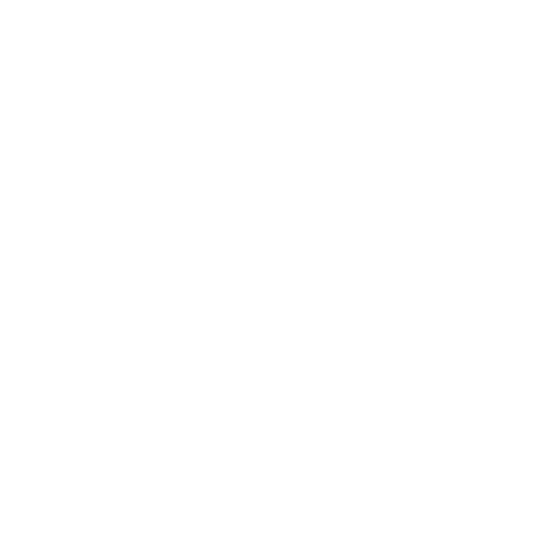

<IPython.core.display.Javascript object>


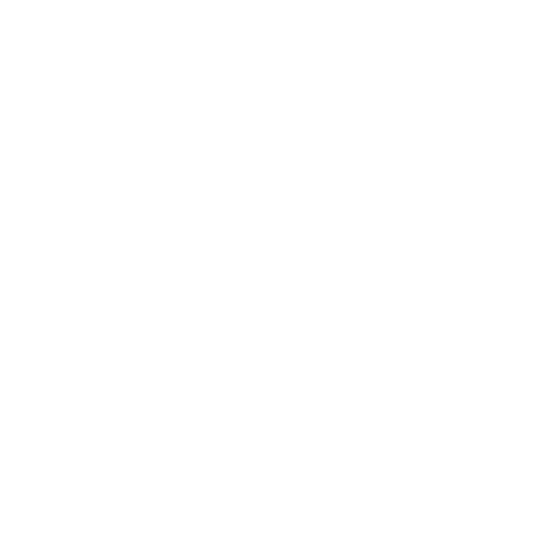

<IPython.core.display.Javascript object>


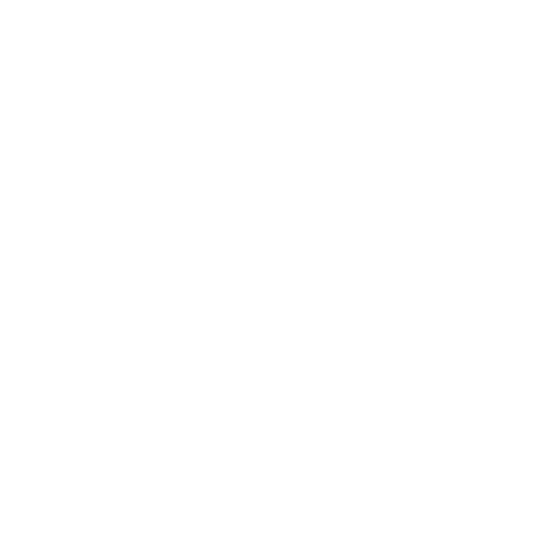

<IPython.core.display.Javascript object>


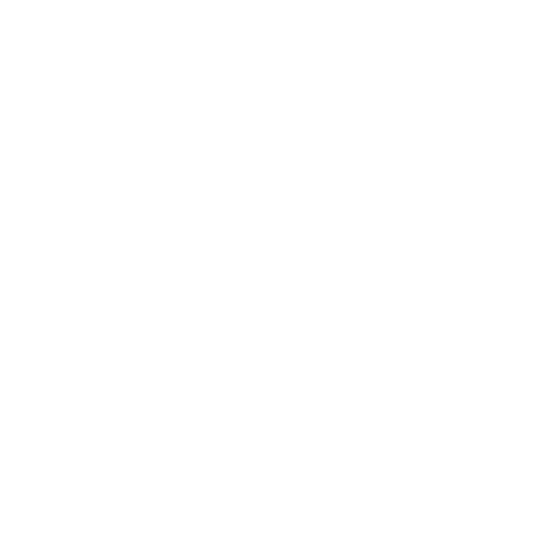

<IPython.core.display.Javascript object>


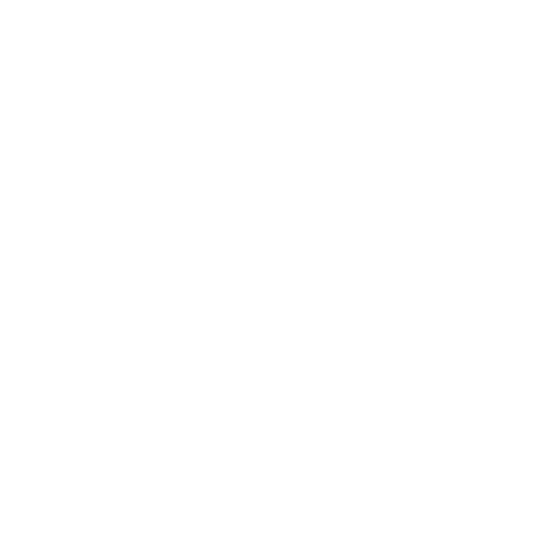

<IPython.core.display.Javascript object>


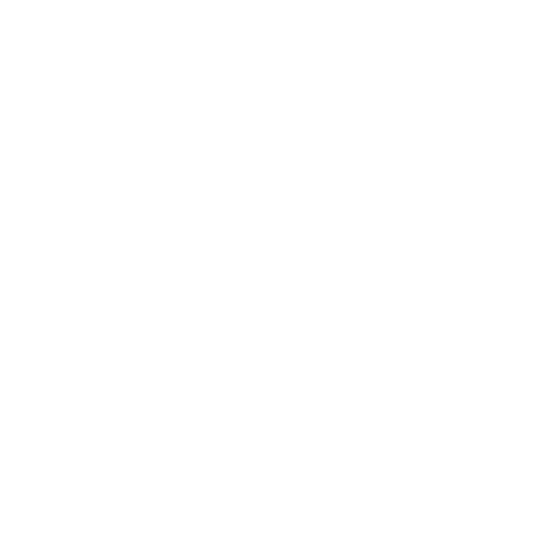

<IPython.core.display.Javascript object>


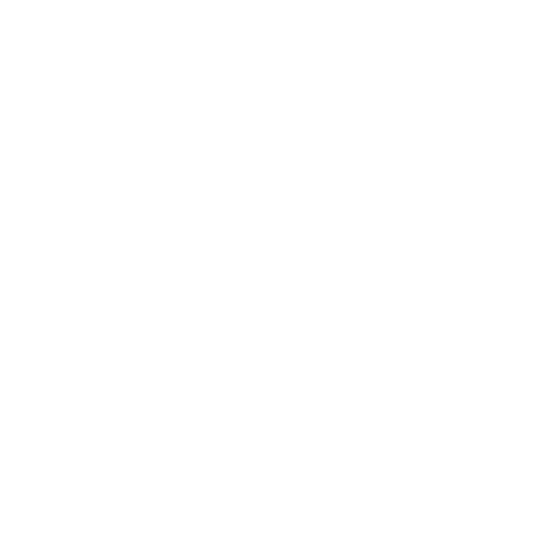

<IPython.core.display.Javascript object>


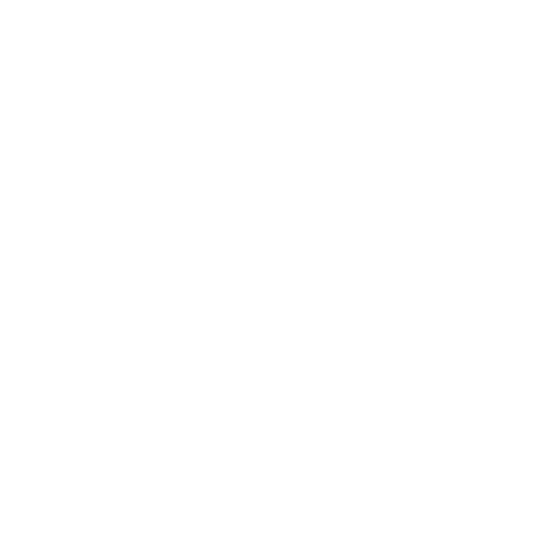

<IPython.core.display.Javascript object>


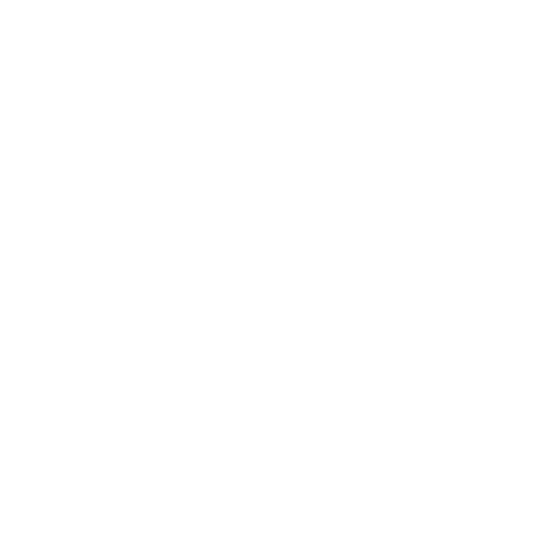

<IPython.core.display.Javascript object>


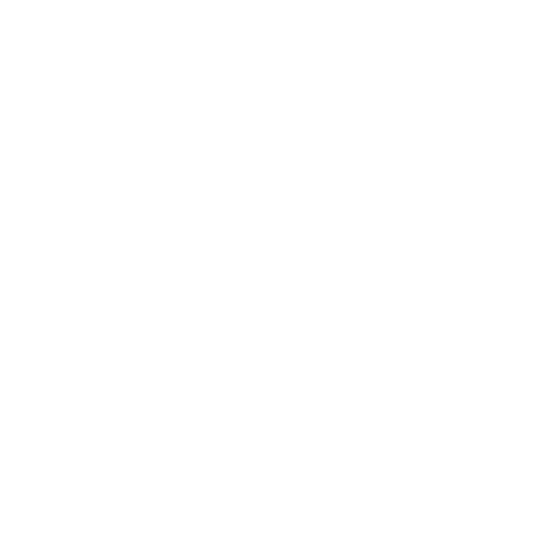

<IPython.core.display.Javascript object>


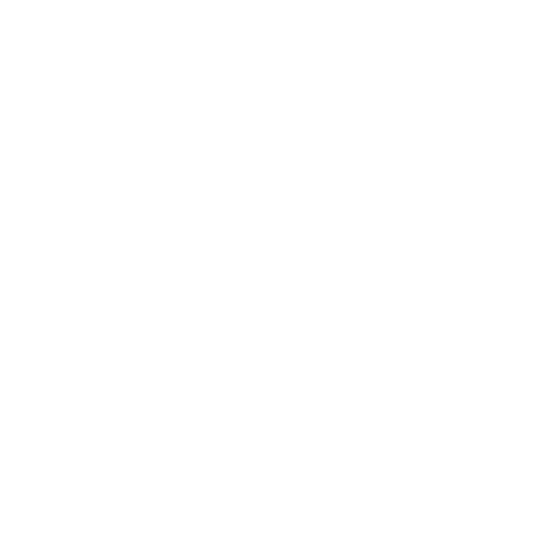

<IPython.core.display.Javascript object>


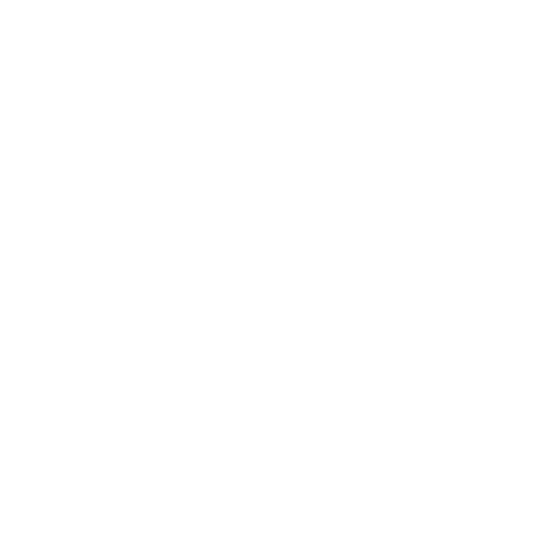

<IPython.core.display.Javascript object>


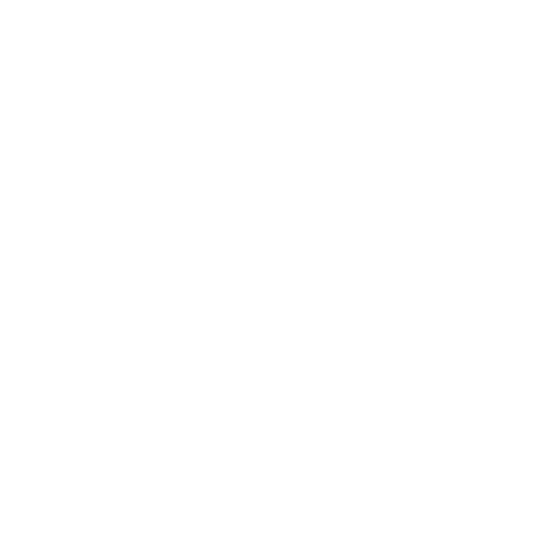

<IPython.core.display.Javascript object>


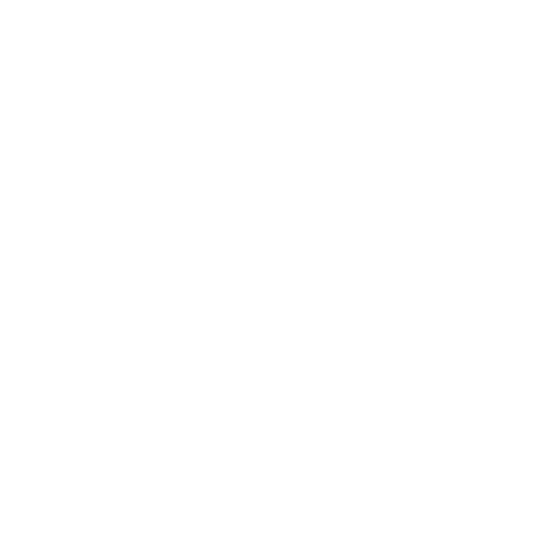

<IPython.core.display.Javascript object>


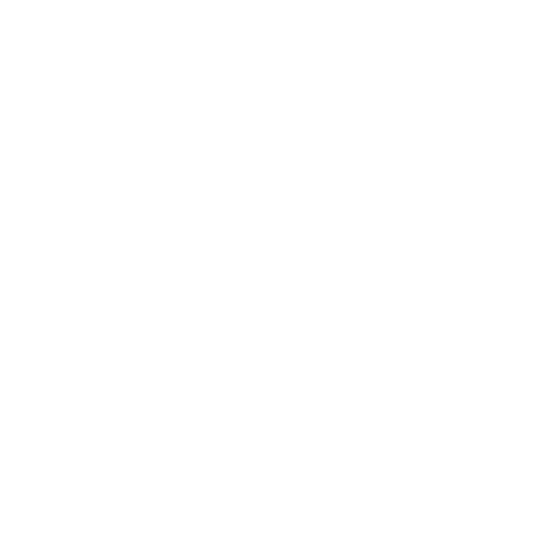

<IPython.core.display.Javascript object>


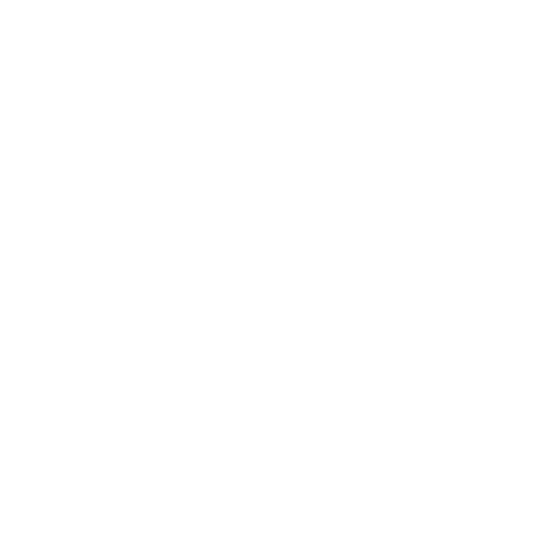

<IPython.core.display.Javascript object>


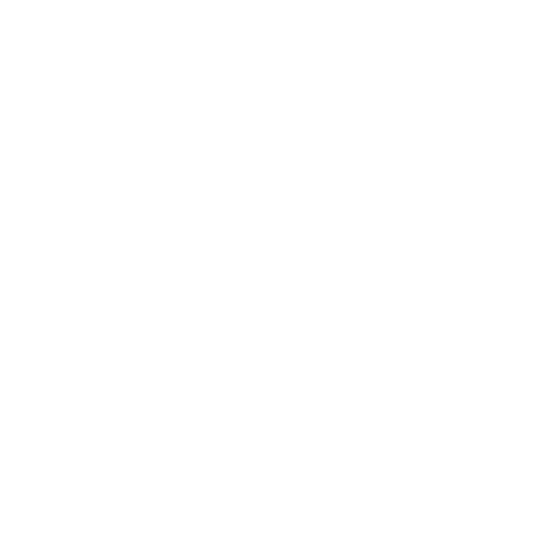

<IPython.core.display.Javascript object>


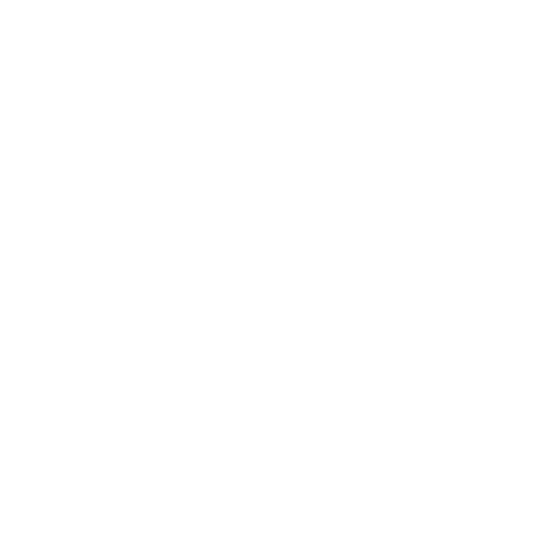

<IPython.core.display.Javascript object>


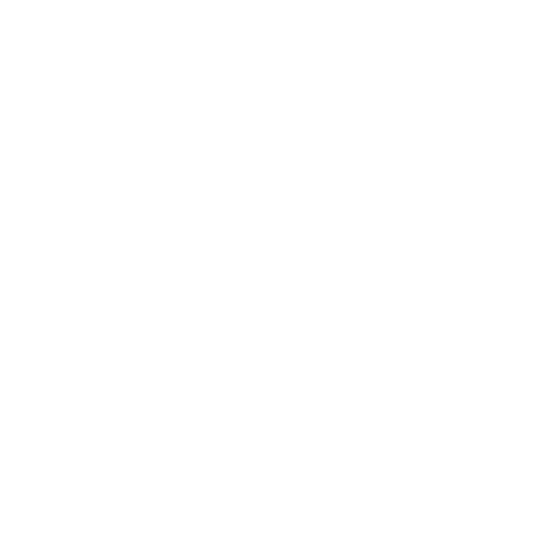

<IPython.core.display.Javascript object>


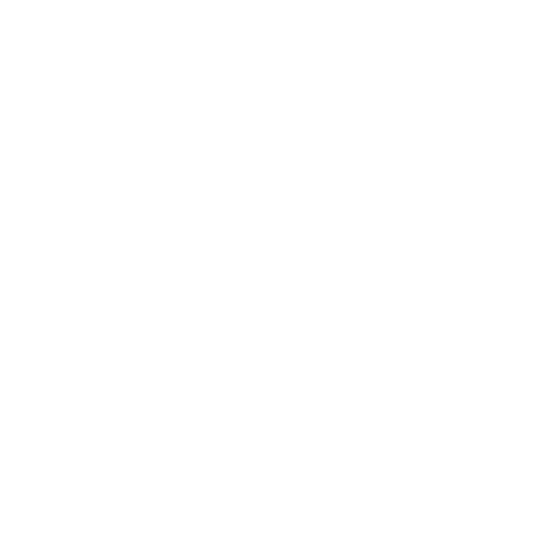

<IPython.core.display.Javascript object>


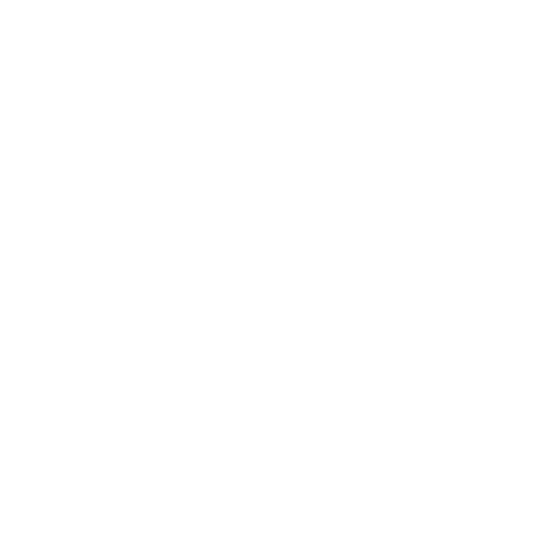

<IPython.core.display.Javascript object>


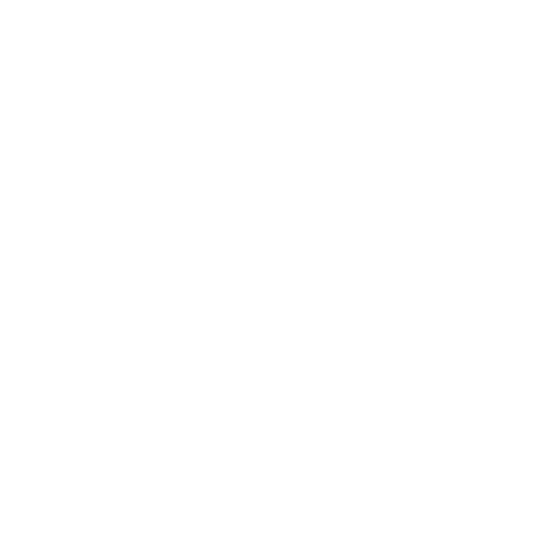

<IPython.core.display.Javascript object>


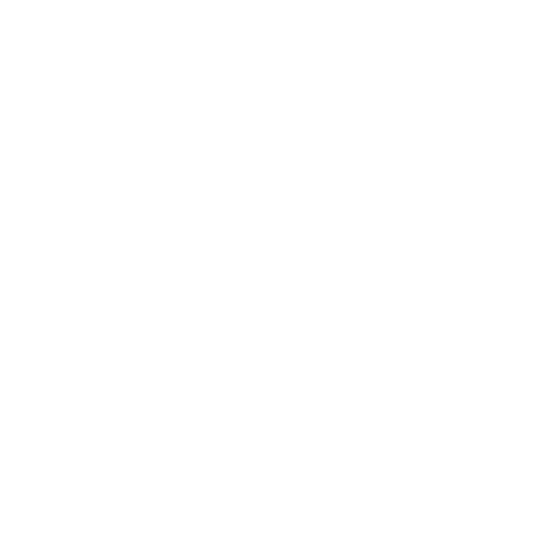

<IPython.core.display.Javascript object>


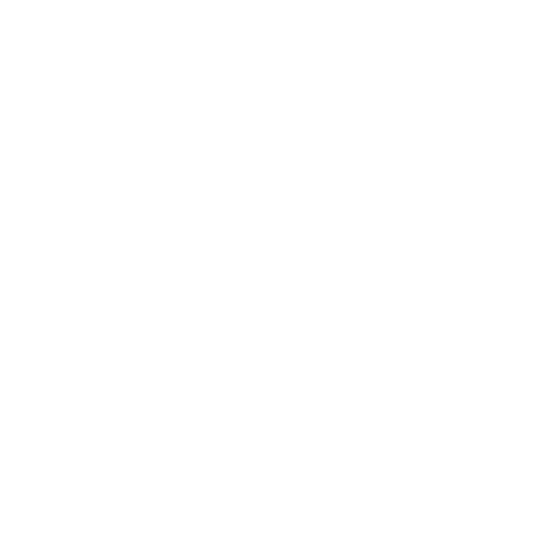

<IPython.core.display.Javascript object>


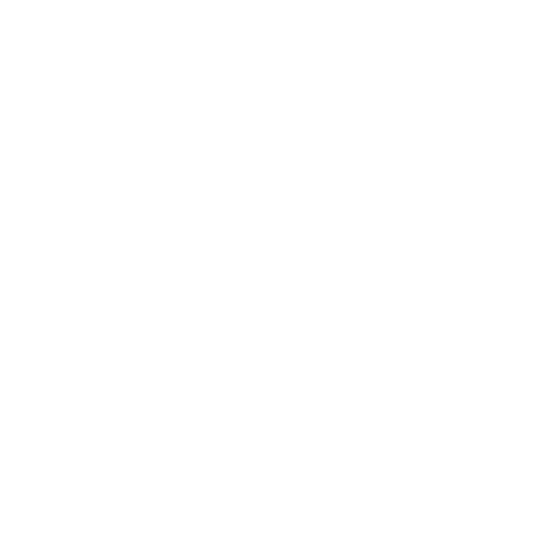

<IPython.core.display.Javascript object>


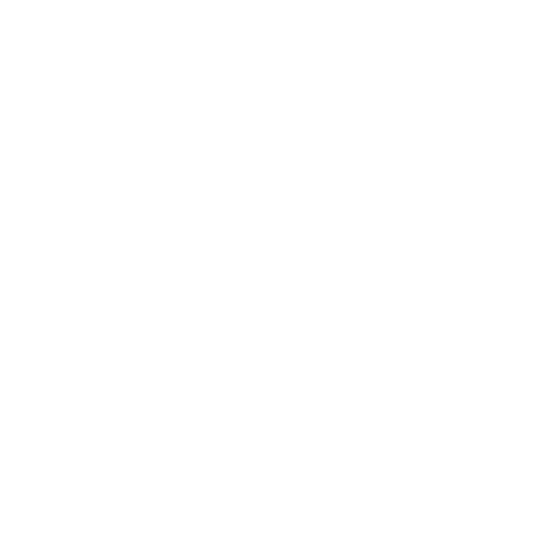

<IPython.core.display.Javascript object>


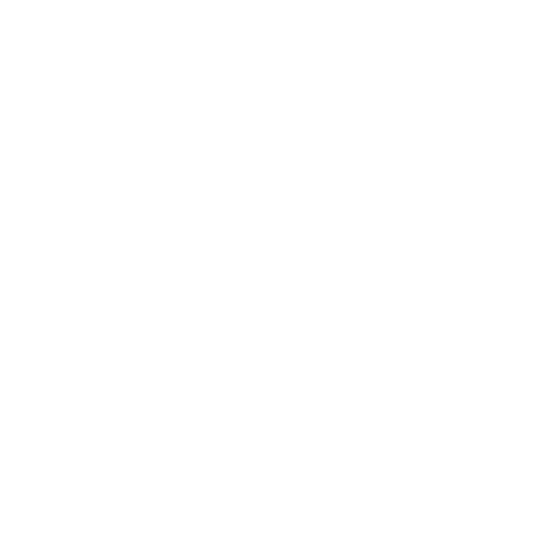

<IPython.core.display.Javascript object>


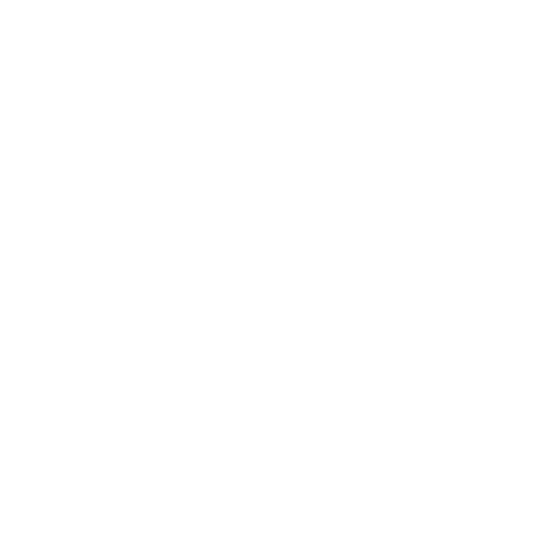

<IPython.core.display.Javascript object>


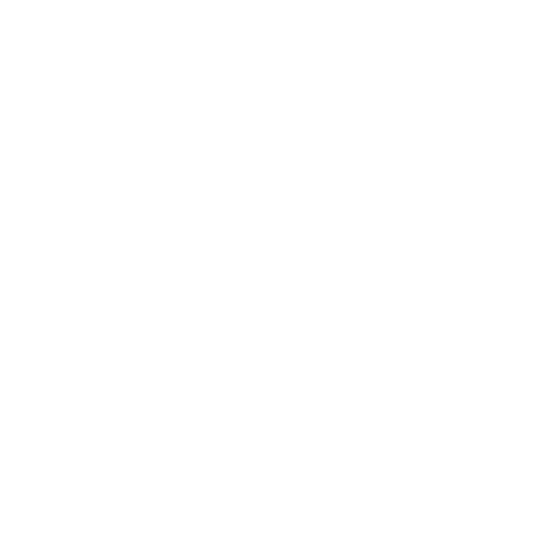

<IPython.core.display.Javascript object>


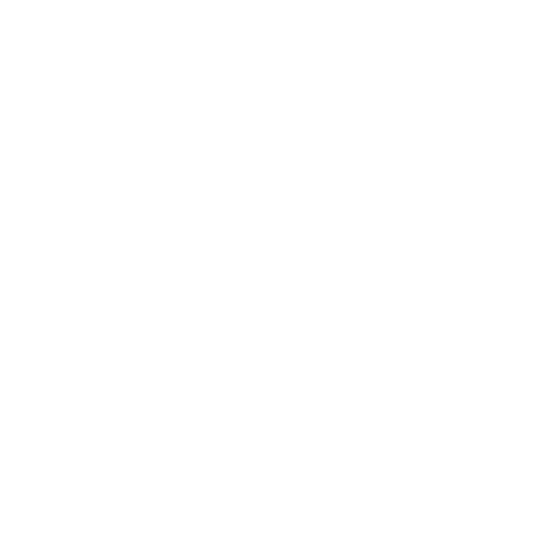

In [73]:
# for rid in roi_list:
#     if rid not in rf_results.keys():
#         continue
        
#     rf_params = rf_results[rid]['rf_params']
#     fig = plot_roi_RF(rf_params, screen_info,
#                       left_edge=left_edge, right_edge=right_edge, top_edge=top_edge, bottom_edge=bottom_edge)
#     fig.suptitle('roi %i' % int(rid+1))
#     label_figure(fig, data_identifier)
#     pl.savefig(os.path.join(rf_estimates_dir, 'rf_estimate_roi%05d.png' % int(rid+1)))
#     pl.close()

# Plot all ROIs together:

In [70]:
from matplotlib.pyplot import cm

nrois_to_plot = 10

# roi_colors = sns.color_palette("bright", nrois_to_plot)
# sns.palplot(roi_colors)


<IPython.core.display.Javascript object>


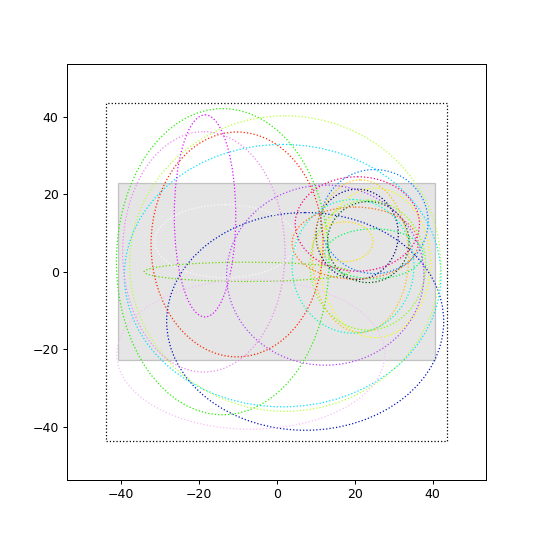

/n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/rf_estimates/20190404160119_select_top_magr_magthr_0.02_by_allconds_filter_lowpass_4Hz top_22_rois_estimated_rfs_thr0.024_max_of_mean_condns


In [71]:

plot_centroid_offset = False

nrois_to_plot = len(roi_list)
color=iter(cm.gist_ncar(np.linspace(0,1,nrois_to_plot)))

travel_width = right_edge - left_edge
travel_height = top_edge - bottom_edge

fig, ax = pl.subplots(1, figsize=(6, 6))
ax.clear()

# Plot travel bounds of bar:
ax.add_patch(Rectangle((left_edge, bottom_edge), travel_width, travel_height, 
                       alpha=1, facecolor='none', edgecolor='k', linestyle=':'))

# Plot physical screen limits
screen_width = screen_info['azimuth']
screen_height = screen_info['elevation']
screen_aspect = screen_width/screen_height
ax.add_patch(Rectangle((-screen_width/2, -screen_height/2), screen_width, screen_height, 
                       alpha=.2, facecolor='gray', edgecolor='k', linestyle='-'))


for ri, rid in enumerate(roi_list[0:nrois_to_plot]):
    if rid not in rf_results.keys():
        continue
    
    roi_color=next(color)


    rfparams = rf_results[rid]['rf_params']

    left, right = rfparams['azimuth_bounds']
    top, bottom = rfparams['elevation_bounds']

    xpos_phase, ypos_phase = rfparams['phase_coords']
    x_center = left + (right - left)/2 #absolute_coords['linX'][rid]
    y_center = bottom + (top - bottom)/2
    ells = [Ellipse(xy=[x_center, y_center], \
                    width=right-left,\
                    height=top-bottom)]

    if plot_centroid_offset:
        ax.plot([xpos_phase, x_center], [ypos_phase, y_center], color=roi_color, marker='*', label=rid)
    #ax.plot(x_center, y_center, 'b*', label='midpoint')

    #ax.set_xlim([-screen_info['azimuth']/2, screen_info['azimuth']/2])
    #ax.set_ylim([-screen_info['elevation']/2, screen_info['elevation']/2])
    ax.set_xlim([left_edge-10, right_edge+10])
    ax.set_ylim([bottom_edge-10, top_edge+10])

    for ei,e in enumerate(ells): #[0:20]):
        ax.add_artist(e)
        e.set_alpha(1)
        e.set_facecolor('none')
        e.set_linestyle(':')
        e.set_edgecolor(roi_color)
    
ax.set_xlim([left_edge-10, right_edge+10])
ax.set_ylim([bottom_edge-10, top_edge+10])

    
    
#ax.legend()

sort_type = 'max_of_mean_condns'

figname = 'top_%i_rois_estimated_rfs_thr%.3f_%s' %  (nrois_to_plot, mag_thr, sort_type)
pl.savefig(os.path.join(output_dir, '%s.png' % figname))


print output_dir,
print figname

In [66]:
sorted_top_rois

array([ 37,  55,   3,  42,  28,  27,  77,  36,  80,  63,  26,  83,  53,
        46,  19,  97,  13, 107,  34,  65,   5, 100])

# Look at single ROI:

In [72]:
rid = 13 #3
print mean_magratios.iloc[rid]

top       0.047110
right     0.032290
left      0.042847
bottom    0.037722
Name: 13, dtype: float64


13


<IPython.core.display.Javascript object>


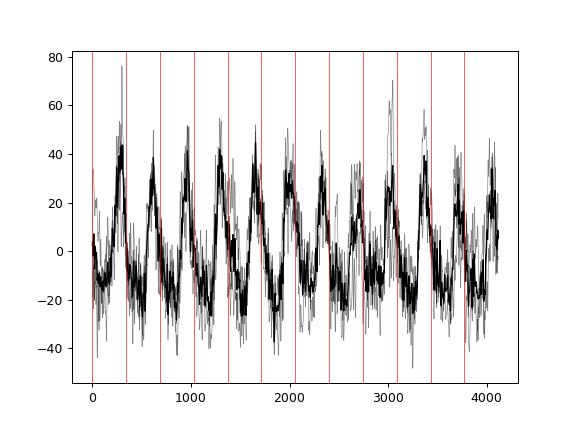

In [73]:
print rid

c1 = 'left'
raw_traces = processing_results[rid]['raw_traces']
filt_traces = processing_results[rid]['filtered_traces']

roi_traces = copy.copy(filt_traces)

pl.figure()
for tr in np.arange(0, roi_traces[c1].shape[0]):
    pl.plot(roi_traces[c1][tr,:], 'k', lw=0.5, alpha=0.5)
pl.plot(roi_traces[c1].mean(axis=0), 'k', lw=1, alpha=1)
for cyc in stiminfo[c1]['cycle_start_ixs']:
    pl.axvline(x=cyc, color='r', lw=0.5)


In [99]:
print phase[trials_by_cond[c2]].iloc[rid]
print phase[trials_by_cond[c2]].iloc[rid].std()
print phase[trials_by_cond[c1]].iloc[rid]
print phase[trials_by_cond[c1]].iloc[rid].std(axis=0)

11   -1.711095
5    -0.856706
6    -0.777510
Name: 38, dtype: float64
0.51766056998
11   -1.711095
5    -0.856706
6    -0.777510
Name: 38, dtype: float64
0.51766056998


In [57]:
# Compare each cond's value to absolute

print "RID: %i" % rid
c1 = 'bottom'
c2 = 'top'
print "--- %s ---" % c1
print phase[trials_by_cond[c1]].iloc[rid], "mean: %.2f" % phase[trials_by_cond[c1]].iloc[rid].mean()
print "--- %s ---" % c2
phase[trials_by_cond[c2]].iloc[rid],  "mean: %.2f" % phase[trials_by_cond[c2]].iloc[rid].mean()

RID: 80
--- bottom ---
12   -0.445633
3    -0.233642
9    -0.505396
Name: 80, dtype: float64 mean: -0.39
--- top ---


(11   -0.445284
 5    -0.381693
 6    -0.331366
 Name: 80, dtype: float64, 'mean: -0.39')

# Fix "offset" in cycle positions

In [58]:
curr_figdir = os.path.join(output_dir, 'parsed_cycles_by_roi', 'cyclesize%i' % chunksize)
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)
print "Saving ROI figures to: %s" % curr_figdir


Saving ROI figures to: /n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/rf_estimates/20190404160119_select_top_magr_magthr_0.02_by_allconds_filter_lowpass_4Hz/parsed_cycles_by_roi/cyclesize1


In [59]:
# Reload stim positions if repeating this for a different ROI:

stim_positions = dict()
stim_tstamps = dict()
for cond in trials_by_cond.keys():
    stim_positions[cond], stim_tstamps[cond] = get_interp_positions(cond, mwinfo, stiminfo, trials_by_cond)


[top]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[right]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[left]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[bottom]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)


<IPython.core.display.Javascript object>


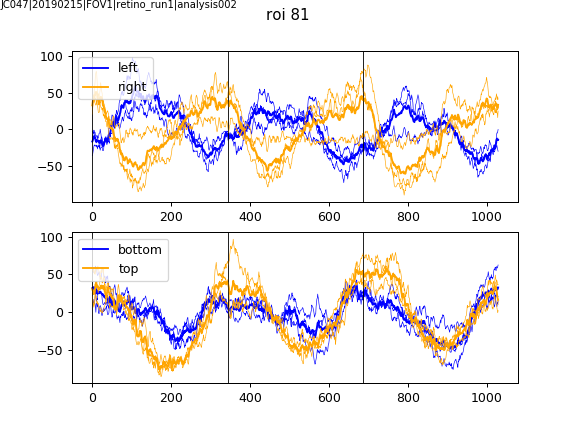

/n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/rf_estimates/20190404160119_select_top_magr_magthr_0.02_by_allconds_filter_lowpass_4Hz/parsed_cycles_by_roi/cyclesize1 avg_3cycle_by_cond_roi00081
avg_3cycle_by_cond_roi00081


In [60]:
raw_traces = processing_results[rid]['raw_traces']
filt_traces = processing_results[rid]['filtered_traces']

roi_traces = copy.copy(raw_traces)

chunksize = 3
plot_each_condition = False

# Set params for calcuting "onset" response:
nstds_above_baseline = 3.0
window_nsecs = 0.5

# Plot colors:
c1_color = 'blue'
c2_color = 'orange'
#%%


#### Get average N cycles and visualize chunked traces
parsed_traces, parsed_cycle_ixs = get_parsed_cycles(rid, roi_traces, stiminfo, chunksize=chunksize)

#### Plot averaged cycles by condition:
fig = plot_parsed_cycles_by_roi(parsed_traces, parsed_cycle_ixs)
pl.suptitle('roi %i' % int(rid+1))
label_figure(fig, data_identifier)
figname = 'avg_%icycle_by_cond_roi%05d' % (chunksize, int(rid+1))
pl.savefig(os.path.join(curr_figdir, '%s.png' % figname))
print curr_figdir, figname
#pl.close()

print figname


#### Plot each rep's "sub cycle":


<IPython.core.display.Javascript object>


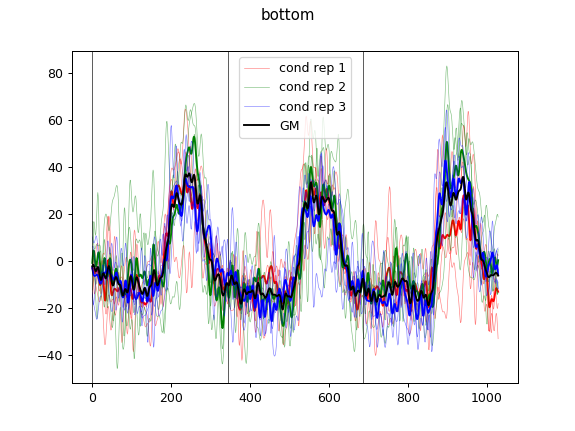

Text(0.5,0.98,u'bottom')

In [140]:
# Plot each rep's "sub cycle":
ncond_reps, nsubcycles_to_avg, nframes_in_subcycle = parsed_traces[c1].shape

condrep_colors = ['r', 'g', 'b', 'purple']
fig, ax = pl.subplots()

for rep in range(ncond_reps):
    for subcycle in range(nsubcycles_to_avg):
        scycle_label = 'cond rep %i' % (int(rep+1)) if subcycle==0 else None
        ax.plot(parsed_traces[c1][rep, subcycle, :], color=condrep_colors[rep], \
                label=scycle_label, lw=0.5, alpha=0.5)
    ax.plot(parsed_traces[c1].mean(axis=1)[rep], color=condrep_colors[rep], alpha=1)
ax.plot(parsed_traces[c1].mean(axis=1).mean(axis=0), 'k', label='GM')
ax.legend()

subcycle_ixs = parsed_cycle_ixs[c1].mean(axis=0)[0,: ]
for cyc in subcycle_ixs: #parsed_cycle_ixs[c2][0:chunksize]:
    ax.axvline(x=cyc, color='k', lw=0.5)

pl.suptitle(c1)

#### Flip reverse condN

<IPython.core.display.Javascript object>


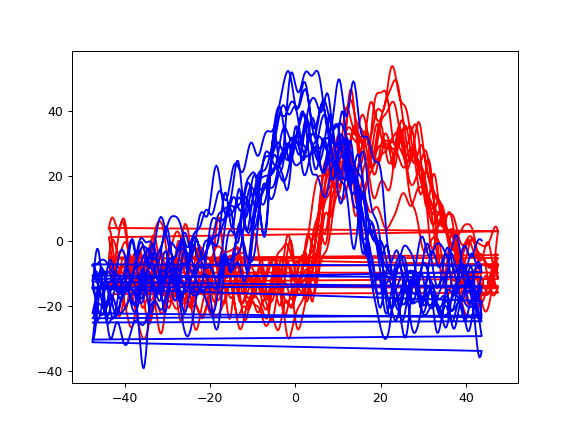

avg_3cycle_by_cond_roi00014


In [142]:
c1_positions = stim_positions[c1].mean(axis=1)
c2_positions = stim_positions[c2].mean(axis=1)

nframes_true = len(c1_positions)

fig, ax = pl.subplots() #pl.figure()
ax.plot(c1_positions, roi_traces[c1].mean(axis=0)[0:nframes_true], 'r', label='fw')
ax.plot(c2_positions[::-1], roi_traces[c2].mean(axis=0)[0:nframes_true][::-1], 'b', label='rev')

pl.savefig(os.path.join(output_dir, 'trace_offset_roi%05d.png' % int(rid+1)))
print figname

In [288]:
print "FW:\n", stim_positions[c1].mean(axis=1).head(), stim_positions[c1].mean(axis=1).tail()

print "REV:\n", stim_positions[c2].mean(axis=1).head(), stim_positions[c2].mean(axis=1).tail()

FW:
0   -43.715256
1   -43.476239
2   -43.207815
3   -42.943670
4   -42.674033
dtype: float64 4120    48.881480
4121    49.146773
4122    49.412066
4123    49.677360
4124    49.942653
dtype: float64
REV:
0    43.732899
1    43.770181
2    43.771502
3    43.769278
4    43.766868
dtype: float64 4120   -45.738662
4121   -46.014926
4122   -46.286691
4123   -46.557355
4124   -46.831416
dtype: float64


#### "Fix" offset 

In [143]:
# Test flipping with average trace:

c1_positions = stim_positions[c1].mean(axis=1)
c2_positions = stim_positions[c2].mean(axis=1)

end_of_cyc1 = stiminfo[c2]['cycle_start_ixs'][1]

# Find corresponding start position of REV condN for 1st cycle:
align_step = int(np.where(abs(c2_positions[0:end_of_cyc1]-c1_positions[0]) \
                          == min(abs(c2_positions[0:end_of_cyc1]-c1_positions[0])))[0])
offset = c2_positions[end_of_cyc1-1] - c2_positions[328]
print rep, align_step, offset

# Flip tail to front:
REV_positions = []
REV_frames = []
for ci, cyc in enumerate(stiminfo[c2]['cycle_start_ixs']):
    if ci == len(stiminfo[c2]['cycle_start_ixs'])-1:
        curr_pos = list(c2_positions[cyc+align_step:].values)
        curr_frs = list(np.arange(cyc+align_step, len(c2_positions.values)))
    else:
        curr_pos = list(c2_positions[cyc+align_step:stiminfo[c2]['cycle_start_ixs'][ci+1]].values)
        curr_frs = list(np.arange(cyc+align_step, stiminfo[c2]['cycle_start_ixs'][ci+1]))
    curr_pos = [-1*c for c in curr_pos] # flip position side
    curr_pos.extend(c2_positions[cyc:cyc+align_step].values)
    curr_frs.extend(list(np.arange(cyc, cyc+align_step)))

    REV_positions.extend(curr_pos)
    REV_frames.extend(curr_frs)


tmp_traces = roi_traces['right'][rep, :]
REV_traces = []
for ci, cyc in enumerate(stiminfo[c2]['cycle_start_ixs']):
    # Pull tail in front:
    if ci == len(stiminfo[c2]['cycle_start_ixs'])-1:
        curr_val = list(tmp_traces[cyc+align_step:])
    else:
        curr_val = list(tmp_traces[cyc+align_step:stiminfo[c2]['cycle_start_ixs'][ci+1]])
    curr_val.extend(list(tmp_traces[cyc:cyc+align_step]))
    REV_traces.extend(curr_val)

FW_traces = roi_traces['left'].mean(axis=0)


2 328 -3.73913531141


<IPython.core.display.Javascript object>


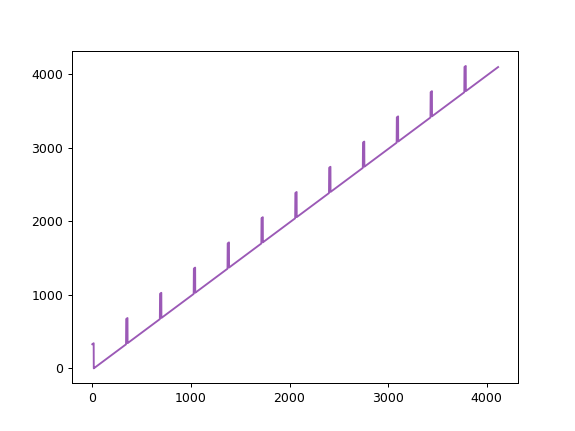

In [144]:
pl.figure()
pl.plot(c1_positions.index.tolist(), REV_frames)

pl.savefig(os.path.join(output_dir, 'frames_shifted_roi%05d.png' % int(rid+1)))


#### Replot by position with SHIFT

In [145]:
print "FW:", c1_positions.min(), c1_positions.max()
print "REV:", np.array(REV_positions).min(), np.array(REV_positions).max()

FW: -43.7152557373 47.5635349829
REV: -43.5600263671 47.5966346189


<IPython.core.display.Javascript object>


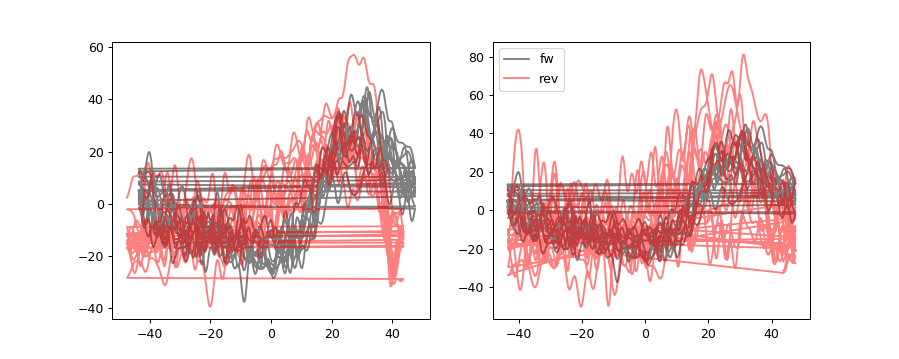

In [146]:

fig, axes = pl.subplots(1,2, figsize=(10,4)) #pl.figure()
ax=axes[0]
ax.plot(c1_positions, roi_traces['left'].mean(axis=0), 'k', label='fw', alpha=0.5)
ax.plot(c2_positions[::-1], roi_traces['right'].mean(axis=0)[::-1], 'r', label='rev', alpha=0.5)

ax=axes[1]
ax.plot(c1_positions, FW_traces, 'k', label='fw', alpha=0.5)
ax.plot(REV_positions[::-1], REV_traces[::-1], 'r', label='rev', alpha=0.5)
ax.legend()

pl.savefig(os.path.join(output_dir, 'trace_offset_shifted_roi%05d.png' % int(rid+1)))


#### Flip both "reverse" conditions and overwrite arrays

In [147]:
c1 = 'left'
c2 = 'right'

for (c1, c2) in [('left', 'right'), ('bottom', 'top')]:
    for rep in range(len(trials_by_cond[c1])):

        c1_positions = stim_positions[c1][trials_by_cond[c1][rep]] #.mean(axis=1)
        c2_positions = stim_positions[c2][trials_by_cond[c2][rep]] #.mean(axis=1)

        end_of_cyc1 = stiminfo[c2]['cycle_start_ixs'][1]

        # Find corresponding start position of REV condN for 1st cycle:
        align_step = int(np.where(abs(c2_positions[0:end_of_cyc1]-c1_positions[0]) \
                                  == min(abs(c2_positions[0:end_of_cyc1]-c1_positions[0])))[0])
        offset = c2_positions[end_of_cyc1-1] - c2_positions[328]
        print rep, align_step, offset

        # Flip tail to front:
        REV_positions = []
        REV_frames = []
        for ci, cyc in enumerate(stiminfo[c2]['cycle_start_ixs']):
            if ci == len(stiminfo[c2]['cycle_start_ixs'])-1:
                curr_pos = list(c2_positions[cyc+align_step:].values)
                curr_frs = list(np.arange(cyc+align_step, len(c2_positions.values)))
            else:
                curr_pos = list(c2_positions[cyc+align_step:stiminfo[c2]['cycle_start_ixs'][ci+1]].values)
                curr_frs = list(np.arange(cyc+align_step, stiminfo[c2]['cycle_start_ixs'][ci+1]))
            curr_pos = [-1*c for c in curr_pos] # flip position side
            curr_pos.extend(c2_positions[cyc:cyc+align_step].values)
            curr_frs.extend(list(np.arange(cyc, cyc+align_step)))

            REV_positions.extend(curr_pos)
            REV_frames.extend(curr_frs)

        stim_positions[c2][trials_by_cond[c2][rep]] = REV_positions

        tmp_traces = roi_traces[c2][rep, :]
        REV_traces = []
        for ci, cyc in enumerate(stiminfo[c2]['cycle_start_ixs']):
            # Pull tail in front:
            if ci == len(stiminfo[c2]['cycle_start_ixs'])-1:
                curr_val = list(tmp_traces[cyc+align_step:])
            else:
                curr_val = list(tmp_traces[cyc+align_step:stiminfo[c2]['cycle_start_ixs'][ci+1]])
            curr_val.extend(list(tmp_traces[cyc:cyc+align_step]))
            REV_traces.extend(curr_val)

        #FW_traces = roi_traces['left'].mean(axis=0)
        roi_traces[c2][rep, :] = REV_traces


0 328 -3.73188601254
1 328 -3.75451388719
2 328 -3.73150950683
0 328 -3.73979853835
1 328 -3.74236950678
2 328 -3.7352378891


In [148]:
curr_figdir

u'/n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/rf_estimates/20190404143221_select_top_magr_magthr_0.02_by_allconds_filter_lowpass_4Hz/parsed_cycles_by_roi/cyclesize1'

<IPython.core.display.Javascript object>


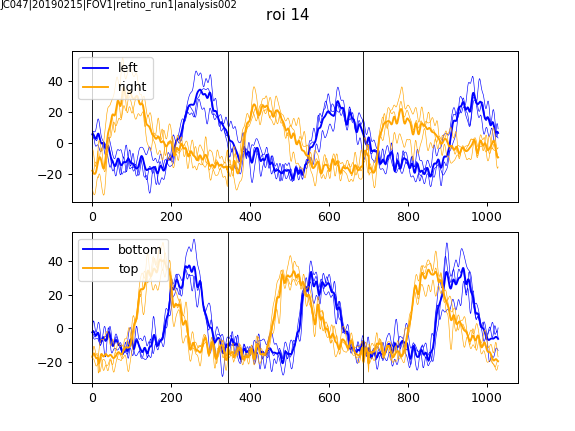

/n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/rf_estimates/20190404143221_select_top_magr_magthr_0.02_by_allconds_filter_lowpass_4Hz/parsed_cycles_by_roi/cyclesize1 avg_3cycle_by_cond_roi00014_shift


In [149]:
parsed_traces, parsed_cycle_ixs = get_parsed_cycles(rid, roi_traces, stiminfo, chunksize=chunksize)


#### Plot averaged cycles by condition -- **with SHIFT

fig = plot_parsed_cycles_by_roi(parsed_traces, parsed_cycle_ixs)
pl.suptitle('roi %i' % int(rid+1))
label_figure(fig, data_identifier)
figname = 'avg_%icycle_by_cond_roi%05d_shift' % (chunksize, int(rid+1))
pl.savefig(os.path.join(curr_figdir, '%s.png' % figname))
print curr_figdir, figname



# Check centroid from FFT-phase vs. ellipse

In [150]:
mean_phase = pd.concat([pd.Series(sp.stats.circmean(phase[repnums], axis=1, low=-np.pi, high=np.pi),\
                                  name=cond) for cond, repnums in trials_by_cond.items()], axis=1)
corrected_phase = targ.correct_phase_wrap(phase)
c_mean_phase = pd.concat([pd.Series(sp.stats.circmean(corrected_phase[repnums], axis=1, low=0, high=2*np.pi),\
                                  name=cond) for cond, repnums in trials_by_cond.items()], axis=1) 
print mean_phase.shape
print mean_phase.head()

(108, 4)
        top     right      left    bottom
0 -0.586720  1.759148 -2.593130 -0.625134
1  0.072540  0.198160 -0.060520  2.735313
2 -1.710808 -0.797809  1.545796 -2.629949
3 -0.336081  0.854199 -2.299201 -0.777062
4 -0.372178  1.102320 -2.701137 -1.451129


In [151]:


abs_az = (mean_phase['left'] - mean_phase['right']) / 2.
abs_el = (mean_phase['bottom'] - mean_phase['top']) / 2.

abs_az_c = targ.correct_phase_wrap((c_mean_phase['left'] - c_mean_phase['right']) / 2.)
abs_el_c = targ.correct_phase_wrap((c_mean_phase['bottom'] - c_mean_phase['top']) / 2.)

#abs_az_c = targ.correct_phase_wrap(abs_az)
#abs_el_c = targ.correct_phase_wrap(abs_el)

print abs_az[rid], "min/max:", abs_az.min(), abs_az.max()
print abs_az_c[rid], "min/max:", abs_az_c.min(), abs_az_c.max()


1.38562380348 min/max: -2.25702205378 2.47186804466
4.52721645707 min/max: 0.138097608965 6.28067349929


In [152]:
linminX = stim_positions['left'].mean(axis=1).iloc[0]
linmaxX = stim_positions['left'].mean(axis=1).iloc[-1]
print "lin X Min/Max:", linminX, linmaxX

linminY = stim_positions['bottom'].mean(axis=1).iloc[0]
linmaxY = stim_positions['bottom'].mean(axis=1).iloc[-1]
print "lin Y Min/Max:", linminY, linmaxY

lin X Min/Max: -43.7152557373 47.5321096507
lin Y Min/Max: -43.7152557373 47.5550120546


In [153]:
screen_w = linmaxX-linminX
screen_h = linmaxY-linminY
print "screen W/H:", screen_w, screen_h

x = np.array([round(xi, 2) for xi in np.linspace(-np.pi, np.pi, screen_w*4)])
y = np.array([round(yi, 2) for yi in np.linspace(-np.pi, np.pi, screen_h*4)])

xc = np.array([round(xi, 2) for xi in np.linspace(0, 2*np.pi, screen_w*4)])
yc = np.array([round(yi, 2) for yi in np.linspace(0, 2*np.pi, screen_h*4)])
#xv, yv = np.meshgrid(x, y)

linx = np.array([round(xi, 2) for xi in np.linspace(linminX, linmaxX, screen_w*4)])
liny = np.array([round(xi, 2) for xi in np.linspace(linminY, linmaxY, screen_h*4)])
print liny.min(), liny.max()

screen W/H: 91.247365388 91.2702677919
-43.72 47.56


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  """
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely 

In [154]:
#rid = 13 # 102 #31 #13
#rid = 23
print "RID: %i" % rid
az_abs_ix = np.where(x == min(x, key=lambda z:abs(z-abs_az[rid])))[0][0]
az_abs_ix_c = np.where(xc == min(xc, key=lambda z:abs(z-abs_az_c[rid])))[0][0]

el_abs_ix = np.where(y == min(y, key=lambda z:abs(z-abs_el[rid])))[0][0]
el_abs_ix_c = np.where(yc == min(yc, key=lambda z:abs(z-abs_el_c[rid])))[0][0]

print "--- AZIMUTH ---"
print "uncorrected: Phase (%.2f) ix %i, closest at: %.2f -- lin: %.2f" % (abs_az[rid], az_abs_ix, x[az_abs_ix], linx[az_abs_ix])
print "corrected: Phase (%.2f) ix %i, closest at: %.2f -- lin: %.2f" % (abs_az_c[rid], az_abs_ix_c, xc[az_abs_ix_c], linx[az_abs_ix_c])
print "--- ALTITUDE ---"
print "uncorrected: Phase (%.2f) ix %i, closest at: %.2f -- lin: %.2f" % (abs_el[rid], el_abs_ix, y[el_abs_ix], liny[el_abs_ix])
print "corrected: Phase (%.2f) ix %i, closest at: %.2f -- lin: %.2f" % (abs_el_c[rid], el_abs_ix_c, yc[el_abs_ix_c], liny[el_abs_ix_c])


RID: 13
--- AZIMUTH ---
uncorrected: Phase (1.39) ix 262, closest at: 1.39 -- lin: 22.14
corrected: Phase (4.53) ix 262, closest at: 4.53 -- lin: 22.14
--- ALTITUDE ---
uncorrected: Phase (2.40) ix 321, closest at: 2.40 -- lin: 36.77
corrected: Phase (5.55) ix 321, closest at: 5.54 -- lin: 36.77


In [155]:
print phase[trials_by_cond['bottom']].iloc[rid]
print phase[trials_by_cond['top']].iloc[rid]

12    1.987748
3     1.904225
9     1.868439
Name: 13, dtype: float64
11   -2.911787
5    -2.881142
6    -2.870121
Name: 13, dtype: float64


In [156]:
el_ix1 = np.where(y == min(y, key=lambda z:abs(z-mean_phase['bottom'].iloc[rid])))[0][0]
print "bottom:", el_ix1, liny[el_ix1]
el_ix2 = np.where(y == min(y, key=lambda z:abs(z-mean_phase['top'].iloc[rid])))[0][0]
print "top:", el_ix2, liny[::-1][el_ix2]


bottom: 293 29.75
top: 15 43.79


In [157]:
az_ix1 = np.where(x == min(x, key=lambda z:abs(z-mean_phase['left'].iloc[rid])))[0][0]
print "left:", az_ix1, linx[az_ix1]
az_ix2 = np.where(x == min(x, key=lambda z:abs(z-mean_phase['right'].iloc[rid])))[0][0]
print "right:", az_ix2, linx[::-1][az_ix2]


left: 243 17.37
right: 82 26.92


In [158]:

assert round(screen_h, 0) == round(screen_w, 0), "Uneven travel distances!"
traveled_dist = round(screen_h, 0)


est_phase_az = abs_az[rid]
if est_phase_az < 0:
    frac_traveled = est_phase_az / (2*np.pi)
elif est_phase_az > 0:
    frac_traveled = (est_phase_az + np.pi) / (2*np.pi)
else:
    frac_traveled = np.pi
    
dist_from_end_lin = traveled_dist - (traveled_dist*frac_traveled)
est_pos_az = linmaxX - dist_from_end_lin
print "[AZ]: Frac traveled: %.2f, about %.2f deg from end - estimed pos is %.2f deg" % (frac_traveled, dist_from_end_lin, est_pos_az)

est_phase_el = abs_el[rid]
if est_phase_el < 0:
    frac_traveled = abs(est_phase_el) / (2*np.pi)
elif est_phase_el > 0:
    frac_traveled = (est_phase_el + np.pi) / (2*np.pi)
else:
    frac_traveled = np.pi
    
dist_from_end_lin = traveled_dist - (traveled_dist*frac_traveled)
est_pos_el = linmaxY - dist_from_end_lin
print "[EL]: Frac traveled: %.2f, about %.2f deg from end - estimed pos is %.2f deg" % (frac_traveled, dist_from_end_lin, est_pos_el)



[AZ]: Frac traveled: 0.72, about 25.43 deg from end - estimed pos is 22.10 deg
[EL]: Frac traveled: 0.88, about 10.68 deg from end - estimed pos is 36.87 deg


In [159]:
print mean_phase.iloc[rid]
print "---------------------"
print c_mean_phase.iloc[rid]

top      -2.887683
right    -1.711855
left      1.059392
bottom    1.920128
Name: 13, dtype: float64
---------------------
top       2.887683
right     1.711855
left      5.223793
bottom    4.363057
Name: 13, dtype: float64


In [160]:
print abs_el[rid], (mean_phase.iloc[rid]['bottom'] - mean_phase.iloc[rid]['top']) /  2
print abs_el_c[rid], (c_mean_phase.iloc[rid]['bottom'] - c_mean_phase.iloc[rid]['top']) /  2


2.4039053094 2.4039053094
5.54549796299 0.737687344187


In [161]:
print az_abs_ix, x[az_abs_ix], linx[az_abs_ix]
print az_abs_ix_c, xc[az_abs_ix_c], linx[az_abs_ix_c]

262 1.39 22.14
262 4.53 22.14


In [162]:
print targ.convert_values(abs_az, newmin=linminX, newmax=linmaxX,
                                    oldmin=-np.pi, oldmax=np.pi)[rid]
print targ.convert_values(abs_az_c, newmin=linminX, newmax=linmaxX,
                                       oldmin=0, oldmax=2*np.pi)[rid]

print targ.convert_values(abs_el, newmin=linminY, newmax=linmaxY,
                                    oldmin=-np.pi, oldmax=np.pi)[rid]
print targ.convert_values(abs_el_c, newmin=linminY, newmax=linmaxY,
                                       oldmin=0, oldmax=2*np.pi)[rid]



22.0311060287
22.0311060287
36.8392813927
36.8392813927


In [163]:
absolute_coords['linX'][rid], absolute_coords['linY'][rid]

(22.031106028670337, 36.839281392670316)

In [164]:
rid

13

In [139]:
targ.convert_values(1.37, newmin=linminX, newmax=linmaxX,
                                    oldmin=-np.pi, oldmax=np.pi)

21.804209823187861

In [140]:
absolute_coords['linX'][rid], absolute_coords['linY'][rid]

(22.031106028670337, 36.839281392670316)

In [141]:
[12, 13, 14, 15, 17]

[12, 13, 14, 15, 17]

In [142]:
absolute_coords['linX'][14], absolute_coords['linY'][14]

(21.971589840125503, 39.163175686116176)

###### Plot loci found for current roi's GM trace

In [143]:
cycle_starts = [int(c) for c in parsed_cycle_ixs[c1].mean(axis=0)[0,:]] # only need first chunk
print cycle_starts

[0, 343, 686, 1029, 1372, 1715, 2058, 2401, 2744, 3087, 3430, 3773]


<IPython.core.display.Javascript object>


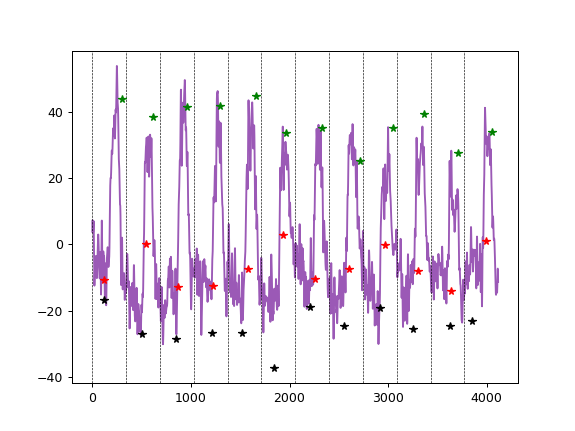

In [147]:

#### Identify max, min, and "onset" frame in averaged trace
loci = get_loci_from_averaged_cycle(parsed_traces, parsed_cycle_ixs, stiminfo, \
                                        nstds_above_baseline=nstds_above_baseline, window_nsecs=window_nsecs)


pl.figure()
pl.plot(parsed_traces['bottom'].mean(axis=1).mean(axis=0))
for cyc in parsed_cycle_ixs['bottom'][0][0]:
    pl.axvline(x=cyc, linestyle='--', color='k', linewidth=0.5)
for mn in loci['left']['maxima']:
    pl.plot(mn[0], mn[1], 'g*')
for mn in loci['left']['minima']:
    pl.plot(mn[0], mn[1], 'k*')
for on in loci['left']['onsets']:
    pl.plot(on[0], on[1], 'r*')

#### Plot onset-peak for each subcycle

<IPython.core.display.Javascript object>


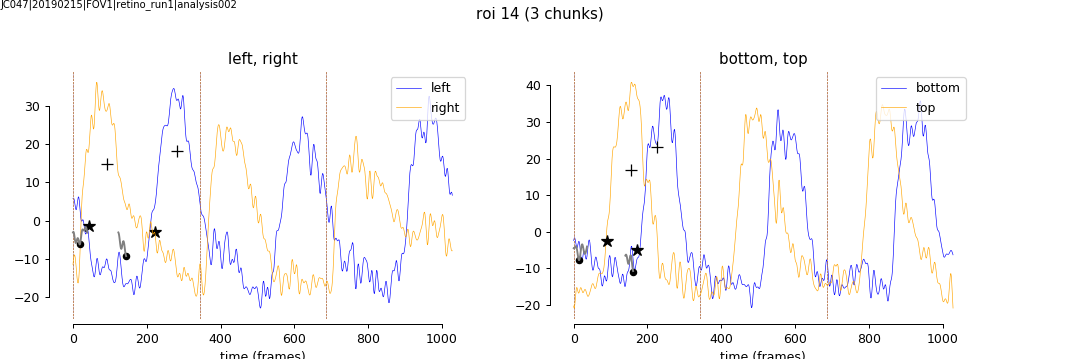

time_v_intensity_cycle_loci_3cycle_by_cond_roi00014


In [138]:

#### Plot averaged mini-trace, with key loci
fig = plot_loci_from_averaged_cycle(parsed_traces, parsed_cycle_ixs, loci, plot_loci=True) #, averaged_=None)

fig.suptitle('roi %i (%i chunks)' % (int(rid+1), chunksize))
pl.subplots_adjust(wspace=0.2, hspace=0.5, left=0.05, top=0.8)
label_figure(fig, data_identifier)
figname = 'time_v_intensity_cycle_loci_%icycle_by_cond_roi%05d' % (chunksize, int(rid+1))
pl.savefig(os.path.join(output_dir, 'parsed_cycles_by_roi', '%s.png' % figname))
print figname
#pl.close()

##### Plot onset-peak by POSITION:

[top] Onset 4.15 deg (std 18.43). Peak @ -14.35 deg.
[right] Onset 35.49 deg (std 0.67). Peak @ 9.73 deg.
[bottom] Onset 26.92 deg (std 5.39). Peak @ 45.06 deg.
[left] Onset 24.33 deg (std 3.89). Peak @ 52.44 deg.
Relative coords? False
Lin coords from phase x, y = (31.57, -19.77)
ROI 8 - summary - 
Phase coords (x, y): (31.57, -19.77)
Left/Right edges: [24.33, 35.49]
--> left onsets: [ 28.22120941  20.4335029 ]
--> right onsets: [ 34.81849529  36.15936688]
Bottom/Top edges: [26.92, 4.15]
--> top onsets: [ 22.57346956 -14.27853019]
--> bottom onsets: [ 32.30275003  21.52804379]


<IPython.core.display.Javascript object>


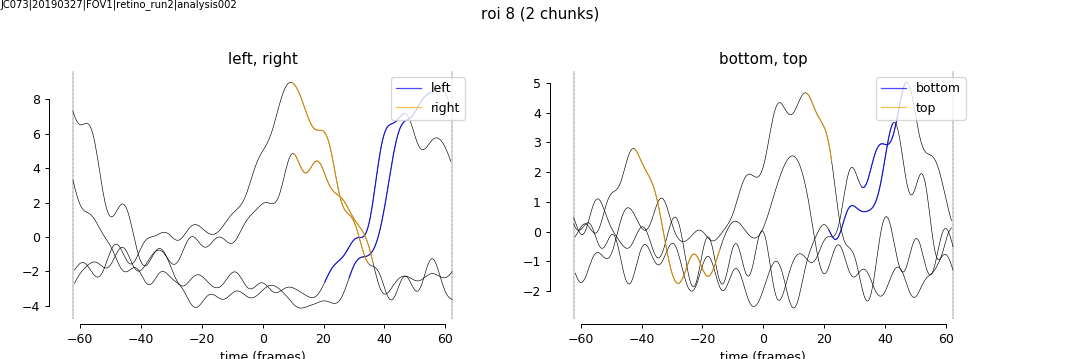

position_v_intensity_cycle_loci_2cycle_by_cond_roi00008


In [730]:

### Use interp stim positions to get bar position at each locus
positions_by_cycle = get_positions_per_cycle(stim_positions, parsed_cycle_ixs)
rf_edges = loci_to_rf_parameters(loci, positions_by_cycle)
print "Relative coords?", absolute_coords['used_relative']
print "Lin coords from phase x, y = (%.2f, %.2f)" % (absolute_coords['linX'][rid], absolute_coords['linY'][rid])
rfparams = get_rf_estimate_params(rid, absolute_coords, rf_edges, verbose=True)

#### Plot averaged cycle using SPACE coords:
average_positions = {}
for c1 in parsed_traces.keys():
    average_positions[c1] = np.array(rf_edges[c1]['bar_positions']).mean(axis=0)

fig = plot_loci_from_averaged_cycle(parsed_traces, parsed_cycle_ixs, loci, average_positions=average_positions)    
fig.suptitle('roi %i (%i chunks)' % (int(rid+1), chunksize))
pl.subplots_adjust(wspace=0.2, hspace=0.5, left=0.05, top=0.8)
label_figure(fig, data_identifier)
figname = 'position_v_intensity_cycle_loci_%icycle_by_cond_roi%05d' % (chunksize, int(rid+1))
pl.savefig(os.path.join(output_dir, 'parsed_cycles_by_roi', '%s.png' % figname))
print figname
#pl.close()


<IPython.core.display.Javascript object>


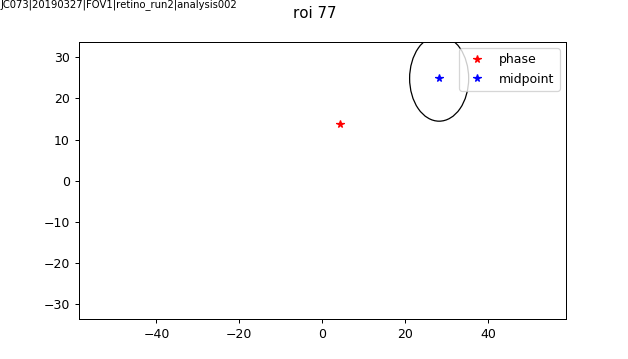

In [490]:

# Use calculated edges of RF to draw ellipse
curr_figdir = os.path.join(output_dir, 'estimates_by_roi')
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)

fig = plot_roi_RF(rfparams, screen_info)
fig.suptitle('roi %i' % int(rid+1))
label_figure(fig, data_identifier)
pl.savefig(os.path.join(curr_figdir, 'rf_estimate_roi%05d.png' % int(rid+1)))

In [348]:
print c1, "start"
print stim_positions[c1].head()

print c1, "tail"
print stim_positions[c1].tail()

bottom start
          12         2          5 
0 -60.690170 -60.690170 -60.690170
1 -60.422246 -60.480607 -60.580831
2 -60.067673 -60.115032 -60.212198
3 -59.709886 -59.758302 -59.863111
4 -59.348544 -59.396028 -59.488295
bottom tail
             12         2          5 
4120  64.662803  64.427702  64.575288
4121  65.027826  64.764318  64.928753
4122  65.392849  65.100935  65.282218
4123  65.757873  65.437552  65.635684
4124  66.122896  65.774168  65.989149


In [371]:
print c2, "start"
print stim_positions[c2].head()

print c2, "tail"
print stim_positions[c2].tail()

top start
          10         1          7 
0  60.690170  60.690170  60.690170
1  60.366302  60.437931  60.306079
2  60.015209  60.077796  59.948720
3  59.658968  59.722217  59.602462
4  59.289903  59.352993  59.237856
top tail
             10         1          7 
4120 -64.777292 -64.682674 -64.642937
4121 -65.153484 -65.050596 -65.004847
4122 -65.529677 -65.418517 -65.366757
4123 -65.905870 -65.786439 -65.728667
4124 -66.282062 -66.154360 -66.090577
